In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Memory management
import gc 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [2]:
#from pandas_profiling import ProfileReport
#import lux

import numpy as np
import pandas as pd

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import scipy
import scipy.stats as stats
from scipy.stats import normaltest
import gc

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score

from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier


from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model  import LogisticRegression


from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
)

from sklearn.feature_selection import (
    f_classif,
    f_regression,
    mutual_info_classif, 
    mutual_info_regression,
    VarianceThreshold
)
# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile

# wrapper methods
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# embedded methods
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE


# imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import (
    TomekLinks,
    EditedNearestNeighbours,
)

from imblearn.over_sampling import (
    SMOTE,
)

from imblearn.combine import SMOTEENN, SMOTETomek

import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

from pycaret.classification import *


# COMMON FUNCTIONS 

In [3]:
def discover_app_train_features(feature,label_rotation=False,horizontal_layout=True):
    temp = app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Loan Contract Distribution': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc['TARGET'] = cat_perc['TARGET']*100
    
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    #print(df1.head())
    tot = df1['Loan Contract Distribution'].sum()
    df1['Loan Contract Distribution'] = round(df1['Loan Contract Distribution'] / tot * 100)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    

    
    s = sns.barplot(ax=ax1, x = feature, y="Loan Contract Distribution",data=df1)
    for index, row in df1.iterrows():
        s.text(row.name,row[1], row[1], color='black', ha="center")        
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    for index, row in cat_perc.iterrows():
        s.text(row.name,row[1], round(row[1],0), color='black', ha="center")        
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Loan Default Percentages [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

In [4]:
# Function to display box plot for univariate analysis 
def disp_boxplot(column):
    plt.figure(figsize=[10,2])
    sns.boxplot(column)
    plt.show()
    
# Function to cap the higher outliers of  the column to the 99 quantile value
def cap_higher_range(df,col_name): 
    q2 = df[col_name].quantile(0.99)
    df[col_name][df[col_name]>=q2]=q2
    
   


In [5]:
def findnulls(df): 
    collist = []
    for col in df.columns : 
        if df[col].isnull().sum() > 0 :
            print (col)
            print (df[col].isnull().sum() * 100 / len(df[col]))

In [6]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Dataset Important Features ')
    plt.tight_layout()


In [7]:
def discover_feature_importance(feat_importance):
    feats = [f for f in data.columns if f not in ['SK_ID_CURR']]
    n_fold = 0
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = feat_importance
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    display_importances(feature_importance_df)


In [8]:
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(app_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()   

In [9]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = app_train.loc[app_train['TARGET'] != 0]
    t0 = app_train.loc[app_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(30,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [10]:
def plot_box_comp(var,nrow=2):
    
    i = 0

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(24,3*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        #plt.subplot(2,2,i)
        sns.boxplot(app_train[feature])
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
        
    plt.show();

def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = app_train.loc[app_train['TARGET'] != 0]
    t0 = app_train.loc[app_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

#### Encode Categorical features

In [11]:
# function to obtain Categorical Features
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# function to factorize categorical features
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# function to create dummy variables of categorical features
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

def applyLabelEncoding(df, collist):
    le = LabelEncoder()
    le_count = 0
    for col in collist:
        le.fit(app_train[col])
        # Transform both training and testing data
        df[col] = le.transform(df[col])
    return df

def _applyLabelEncoding(df,collist):
    le = LabelEncoder()
    le_count = 0
    for col in collist :
        le.fit(df[col])
        # Transform both training and testing data
        df[col] = le.transform(df[col])
        
    return df 

def CategoricalEncoding_WOE(df,variable,target_variable):
    # now we calculate the probability of target=1 
    prob_df = df.groupby([variable])[target_variable].mean()
    prob_df = pd.DataFrame(prob_df)
    
    # and now the probability of target = 0 
    # and we add it to the dataframe
    prob_df['target_0'] = 1-prob_df[target_variable]
    prob_df.loc[prob_df[target_variable] == 0, target_variable] = 0.001
    prob_df['WoE'] = np.log(prob_df[target_variable]/prob_df['target_0'])
    ordered_labels = prob_df['WoE'].to_dict()
    df[variable+'_ordered'] = df[variable].map(ordered_labels)
    
def apply_feat_encoding(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    labelencodedfeaturelist =  [col for col in feats if df[col].nunique() <= 3]
    woefeaturelist = [col for col in feats if df[col].nunique() > 3]
    df = _applyLabelEncoding(df,labelencodedfeaturelist)
    target = 'TARGET'
    for col in woefeaturelist:
        CategoricalEncoding_WOE(df,col,target)
    df.drop(woefeaturelist, axis = 1, inplace=True)    
    return df

# get categorical features
#data_cats = _get_categorical_features(data)
#prev_app_cats = _get_categorical_features(previous_application)
#bureau_cats = _get_categorical_features(bureau)
#pcb_cats = _get_categorical_features(pcb)
#ccbal_cats = _get_categorical_features(credit_card_balance)

# create additional dummy features - 
#previous_application = _get_dummies(previous_application, prev_app_cats)
#bureau = _get_dummies(bureau, bureau_cats)
#pcb = _get_dummies(pcb, pcb_cats)
#credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)

# factorize the categorical features from train and test data
#data = _factorize_categoricals(data, data_cats)

### Missing value functions

In [12]:
def find_missing_columns(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            print (col)
            print (df[col].isnull().sum()* 100 / len(df[col]))

In [13]:
def fill_missing_columns(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(0, inplace = True)

In [14]:
def fill_missing_columns_other_than_target(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if col != 'TARGET':
                df[col].fillna(0, inplace = True)

In [15]:
def get_column_categories(df):
    categorical_columns = []
    for col in df.columns:
        if df[col].dtype in ['object']:
            categorical_columns.append(col)
    numerical_columns = []
    for col in df.columns:
        if col not in categorical_columns:
            numerical_columns.append(col)
    return categorical_columns, numerical_columns

def normal_test(df, significance = .01):
    """
    Function to perform ks test and test against normal distribution using  
    D’Agostino, R. B. (1971), “An omnibus test of normality for moderate and large sample size”
    
    frame: a pandas dataframe
    significance: float. Alpha level for which the null hypotesis will be rejected (H0: series comes from a normal distribution)
    plot: Boolean, whether or not plot a histogram for resulting columns
    
    returns a dataframe with only those columns that follow a normal distribution according to test.
"""
    columns = df.columns.tolist()
    non_normal_columns = []

    for col in columns:
        aux = df[col]
    
        _, p = normaltest(aux)
    
        if p <= significance:
            # col is not normally distributed
            non_normal_columns.append(col)
        
    normal_columns = [cols for cols in columns if cols not in non_normal_columns]
    return normal_columns, non_normal_columns

# Outlier treatment for Normal distribution
#Treating outliers with top coding-Any value greater than maximum limit will be capped at maximum
def outliers_TopCoding_gaussian(df,variable):
    # top coding: upper boundary for outliers according to gaussian rule
    Upper_fence = df[variable].mean()+3*df[variable].std()
    df.loc[df[variable]>Upper_fence, variable] = Upper_fence
    
    
#Treating outliers with top coding-Any value less than minimum limit will be capped at minimum
def outliers_BottomCoding_gaussian(df,variable):
    # bottom coding: lower boundary for outliers according to gaussian rule
    Lower_fence = df[variable].mean()-3*df[variable].std()
    df.loc[df[variable]<Lower_fence, variable] = Lower_fence    
    
#Outlier treatment for Non-Normal distribution
#Treating outliers with zero coding-Any value less than zero will be made zero
def outliers_ZeroCoding(X,variable):
    X.loc[X[variable]<0, variable] = 0
    
#Treating outliers with top coding-Any value greater than maximum limit will be capped at maximum
def outliers_TopCoding_quantile(df,variable):
    # top coding: upper boundary for outliers according to interquantile proximity rule
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    Upper_fence = df[variable].quantile(0.75) + (IQR * 3)
    df.loc[df[variable]>Upper_fence, variable] = Upper_fence
    
#Treating outliers with top coding-Any value less than minimum limit will be capped at minimum
def outliers_BottomCoding_quantile(df,variable):
    # bottom coding: lower boundary for outliers according to interquantile proximity rule
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    Lower_fence = df[variable].quantile(0.25) - (IQR * 3)
    df.loc[df[variable]<Lower_fence, variable] = Lower_fence    

In [16]:
def disp_box(df,collist,nrow=3):
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(24,3*nrow))
    i = 0

    for col in collist:
        i += 1
        plt.subplot(nrow,2,i)
        sns.boxplot(df[col])
        plt.xlabel(col, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

def disp_dist(df,collist,nrow=3):

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(24,4*nrow))
    i = 0

    for col in collist:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(df[col], bw=0.5)
        plt.xlabel(col, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()


In [17]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [18]:
# One-hot encoding for categorical columns with get_dummies
def old_one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [19]:
def CategoricalEncoding_WOE(df,variable,target_variable):
    # now we calculate the probability of target=1 
    prob_df = df.groupby([variable])[target_variable].mean()
    prob_df = pd.DataFrame(prob_df)
    
    # and now the probability of target = 0 
    # and we add it to the dataframe
    prob_df['target_0'] = 1-prob_df[target_variable]
    prob_df.loc[prob_df[target_variable] == 0, target_variable] = 0.001
    prob_df['WoE'] = np.log(prob_df[target_variable]/prob_df['target_0'])
    ordered_labels = prob_df['WoE'].to_dict()
    df[variable+'_ordered'] = df[variable].map(ordered_labels)
    
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    woefeaturelist = [col for col in feats if df[col].nunique() > 1]
    target = 'TARGET'
    for col in woefeaturelist:
        CategoricalEncoding_WOE(df,col,target)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.drop(woefeaturelist, axis = 1, inplace=True)   
    
    return df, new_columns


In [20]:
def remove_columns_app_train(train):
    collist = []
    for col in train.columns:
        if (train[col].isnull().sum() *100 / len(train[col])) > 47 :
            if col.startswith('EXT_SOURCE') or col.startswith('HOUSETYPE_MODE') or col.startswith('EMERGENCYSTATE_MODE'):
                i=0
            else :
                collist.append(col)
    train.drop(collist, axis = 1, inplace=True)
    collist = []
    for col in train.columns:
        if col.startswith('FLAG_DOC'):
                collist.append(col)
    collist.remove('FLAG_DOCUMENT_3')
    train.drop(collist, axis = 1, inplace=True)
    columns_drop = ['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT']
    train.drop(columns_drop, axis = 1, inplace=True)
    


#    APPLICATION DATASET MISSING VALUE TREATMENT 
def treat_missing_values_app_train(train):
    # EXT_SOURCE_1 : 173378 entries ( 56%) have null values out of a total of 307511 Entries. The median value is 0.506. 
    train['EXT_SOURCE_1'].fillna(0.506, inplace = True)
    # EXT_SOURCE_2 : 660 entries have null values out of a total of 307511 Entries. The median value is 0.566. 
    train['EXT_SOURCE_2'].fillna(0.566, inplace = True)
    # EXT_SOURCE_3 : 60965 entries (19.8% )have null values out of a total of 307511 Entries. The median value is 0.535. 
    train['EXT_SOURCE_3'].fillna(0.535, inplace = True)
    # NAME_TYPE_SUITE : 1292 entries have null values out of 307511. Value imputed to "Unaccompanied" which is highest value 248526 for field
    train['NAME_TYPE_SUITE'].fillna("Unaccompanied", inplace = True)
    #DEF_30_CNT_SOCIAL_CIRCLE : 1021 entries have null values out of 307511. Missing value imputed to median value of 0.0
    train['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0.0, inplace = True)
    #DEF_60_CNT_SOCIAL_CIRCLE : 1021 entries have null values out of 307511. Missing value imputed to median value of 0.0
    train['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0.0, inplace = True)
    #OBS_30_CNT_SOCIAL_CIRCLE : 1021 entries have null values out of 307511. Missing value imputed to median value of 0.0
    train['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(0.0, inplace = True)
    #OBS_60_CNT_SOCIAL_CIRCLE : 1021 entries have null values out of 307511. Missing value imputed to median value of 0.0
    train['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(0.0, inplace = True)
    train['CNT_FAM_MEMBERS'] = train['CNT_FAM_MEMBERS'].fillna(0)
    train['HOUSETYPE_MODE'].fillna('block of flats', inplace=True)
    train['EMERGENCYSTATE_MODE'].fillna('No', inplace=True)
    train['OCCUPATION_TYPE'].fillna('Others', inplace=True)
   
    
    # TREAT THE AMT COLUMNS. FIX OUTLIERS AND ANOMALIES. REMOVE NULLS AND MISSING VALUES 
    for col in train.columns:
        if col.startswith('AMT'):
            train[col] = train[col] / 100000
    train['AMT_INCOME_TOTAL'][train['AMT_INCOME_TOTAL'] > 3] = 3
    train['AMT_INCOME_TOTAL'][train['AMT_INCOME_TOTAL'] < 0.5] = 0.5
    train['AMT_CREDIT'][train['AMT_CREDIT'] > 11] = 11
    train['AMT_ANNUITY'][train['AMT_ANNUITY'] > 0.45] = 0.45
    train['AMT_GOODS_PRICE'][train['AMT_GOODS_PRICE'] > 10] = 10
    for col in train.columns:
        if col.startswith('AMT'):
            train[col] = train[col] * 100000
    train['AMT_REQ_CREDIT_BUREAU_YEAR'][train['AMT_REQ_CREDIT_BUREAU_YEAR'] > 3.5] = 3.5
    for col in train.columns:
        if col.startswith('AMT'):
            if train[col].isnull().sum() > 0:
                #print (col)
                #print (train[col].isnull().sum() / len(train[col]*100))
                train[col].fillna(0, inplace = True)    

    train['CNT_CHILDREN'][train['CNT_CHILDREN'] > 5] = 5
    train['CNT_FAM_MEMBERS'][train['CNT_FAM_MEMBERS'] > 5] = 5
    train['REGION_POPULATION_RELATIVE'][train['REGION_POPULATION_RELATIVE'] > 0.05] = 0.05
    train['OBS_30_CNT_SOCIAL_CIRCLE'][train['OBS_30_CNT_SOCIAL_CIRCLE'] > 10] = 10
    train['OBS_60_CNT_SOCIAL_CIRCLE'][train['OBS_60_CNT_SOCIAL_CIRCLE'] > 10] = 10
    train['DEF_30_CNT_SOCIAL_CIRCLE'][train['DEF_30_CNT_SOCIAL_CIRCLE'] > 3] = 3
    train['DEF_60_CNT_SOCIAL_CIRCLE'][train['DEF_60_CNT_SOCIAL_CIRCLE'] > 3] = 3
                
    
    # TREAT THE DAYS COLUMNS. FIX OUTLIERS AND ANOMALIES. REMOVE NULLS AND MISSING VALUES 
    for col in train.columns:
        if col.startswith('DAY'):
            if train[col].isnull().sum() > 0:
                train[col].fillna(0, inplace = True)
            train[col] = train[col] / 365
    train['DAYS_EMPLOYED'][train['DAYS_EMPLOYED'] > 1000] = 0
    train['DAYS_EMPLOYED'][train['DAYS_EMPLOYED'] < -10] = -10
    train['DAYS_REGISTRATION'][train['DAYS_REGISTRATION'] < -27] = -27
    train['DAYS_LAST_PHONE_CHANGE'][train['DAYS_LAST_PHONE_CHANGE'] < -6] =-6
    # FIX ANOMALIES AND MISSING VALUES
    train['CODE_GENDER'].value_counts()
    train['CODE_GENDER'].replace('XNA', 'F', inplace =True)
    

    return train    

In [21]:
#            BUREAU MISSING VALUE TREATMENT 
def treat_missing_values_bureau(df_bueau):
    df_bueau['DAYS_CREDIT_ENDDATE'][df_bueau['DAYS_CREDIT_ENDDATE'] < -2300] = -2300
    df_bueau['DAYS_CREDIT_ENDDATE'][df_bueau['DAYS_CREDIT_ENDDATE'] > 1600] = 1600
    df_bueau['DAYS_ENDDATE_FACT'][df_bueau['DAYS_ENDDATE_FACT'] < -2000] = -2000
    df_bueau['AMT_CREDIT_SUM'][df_bueau['AMT_CREDIT_SUM'] > 500000] = 500000
    df_bueau['AMT_CREDIT_SUM_DEBT'][df_bueau['AMT_CREDIT_SUM_DEBT'] > 50000]  = 50000
    df_bueau['AMT_CREDIT_SUM_DEBT'][df_bueau['AMT_CREDIT_SUM_DEBT'] < -600] = -600
    df_bueau['DAYS_CREDIT_UPDATE'][df_bueau['DAYS_CREDIT_UPDATE'] < -1500] = -1500
    df_bueau['DAYS_CREDIT_ENDDATE'].fillna(-330, inplace =True)
    df_bueau['AMT_CREDIT_SUM'].fillna(125518.5, inplace = True)
    df_bueau['DAYS_ENDDATE_FACT'].fillna(-897, inplace =True)
    df_bueau['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace =True)
    # CREDIT_DAY_OVERDUE majority are 0.. can be dropped
    # only 7 % of data is above zero
    # CNT_CREDIT_PROLONG only 0.5% of data is above zero
    #AMT_CREDIT_SUM_LIMIT only a fraction of values are not zero
    return df_bueau

def remove_columns_bureau(df_bueau):
    coldrop = ['CREDIT_DAY_OVERDUE', 'AMT_CREDIT_MAX_OVERDUE','CNT_CREDIT_PROLONG','AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE','AMT_ANNUITY'] 
    df_bueau.drop(coldrop, axis = 1, inplace=True)


In [22]:
#            PREV_APP MISSING VALUE TREATMENT 
def treat_missing_values_prev_app(df_prev_app):
    df_prev_app['AMT_ANNUITY'][df_prev_app['AMT_ANNUITY'] > 20000] = 20000
    df_prev_app['AMT_ANNUITY'][df_prev_app['AMT_ANNUITY'] < 5000] = 5000
    df_prev_app['AMT_APPLICATION'][df_prev_app['AMT_APPLICATION'] > 200000] = 200000
    df_prev_app['AMT_CREDIT'][df_prev_app['AMT_CREDIT'] > 250000] = 250000
    df_prev_app['AMT_GOODS_PRICE'][df_prev_app['AMT_GOODS_PRICE'] > 250000] = 250000
    df_prev_app['HOUR_APPR_PROCESS_START'][df_prev_app['HOUR_APPR_PROCESS_START'] >17] = 17
    df_prev_app['HOUR_APPR_PROCESS_START'][df_prev_app['HOUR_APPR_PROCESS_START'] <8] = 8
    df_prev_app['SELLERPLACE_AREA'][df_prev_app['SELLERPLACE_AREA'] > 100 ] = 100
    df_prev_app['DAYS_DECISION'][df_prev_app['DAYS_DECISION'] < -2000] = -2000
    df_prev_app['RATE_DOWN_PAYMENT'][df_prev_app['RATE_DOWN_PAYMENT'] >0.125] = 0.125
    df_prev_app['CNT_PAYMENT'][df_prev_app['CNT_PAYMENT'] > 25 ] = 25
    df_prev_app['DAYS_LAST_DUE'][df_prev_app['DAYS_LAST_DUE'] > 0 ] = 0
    df_prev_app['DAYS_LAST_DUE'][df_prev_app['DAYS_LAST_DUE'] <-1500 ] = -1500
    df_prev_app['DAYS_LAST_DUE_1ST_VERSION'][df_prev_app['DAYS_LAST_DUE_1ST_VERSION'] > 0 ]= 0
    df_prev_app['DAYS_LAST_DUE_1ST_VERSION'][df_prev_app['DAYS_LAST_DUE_1ST_VERSION'] < -1400 ] = -1400
    df_prev_app['DAYS_FIRST_DUE'][df_prev_app['DAYS_FIRST_DUE'] > -250 ] = -250
    df_prev_app['DAYS_DECISION'][df_prev_app['DAYS_DECISION'] < -1750 ] = -1750
    df_prev_app['DAYS_FIRST_DUE'][df_prev_app['DAYS_FIRST_DUE'] < -1700 ] = -1700
    df_prev_app['DAYS_TERMINATION'][df_prev_app['DAYS_TERMINATION'] > 0 ] = 0
    df_prev_app['DAYS_TERMINATION'][df_prev_app['DAYS_TERMINATION'] < -1700 ] = -1700
    df_prev_app['AMT_ANNUITY'].fillna(11250.0, inplace=True)
    df_prev_app['AMT_CREDIT'].fillna(80541.0, inplace=True)
    df_prev_app['AMT_GOODS_PRICE'].fillna(112320.0, inplace=True)
    df_prev_app['RATE_DOWN_PAYMENT'].fillna(0.0516, inplace=True)
    df_prev_app['CNT_PAYMENT'].fillna(12.0, inplace=True)
    df_prev_app['DAYS_FIRST_DUE'].fillna(-831.0, inplace=True)
    df_prev_app['DAYS_LAST_DUE_1ST_VERSION'].fillna(-361, inplace=True)
    df_prev_app['DAYS_LAST_DUE'].fillna(-537.0, inplace=True)
    df_prev_app['DAYS_TERMINATION'].fillna(-499.0, inplace=True)
    df_prev_app['NFLAG_INSURED_ON_APPROVAL'].fillna(0, inplace=True)
    df_prev_app['PRODUCT_COMBINATION'].fillna("Cash", inplace = True)
    df_prev_app['NAME_CONTRACT_TYPE'][df_prev_app['NAME_CONTRACT_TYPE'] == 'XNA'] = "Cash loans"
    return df_prev_app

def remove_columns_prev_app(df_prev_app):
    coldrop = ['DAYS_FIRST_DRAWING','AMT_DOWN_PAYMENT','RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED','NAME_TYPE_SUITE']
    df_prev_app.drop(coldrop, axis = 1, inplace=True)


In [23]:
#            POS_CASH_BAL MISSING VALUE TREATMENT 
def treat_missing_values_pos_cash_bal(df_pos_cash_bal):
    df_pos_cash_bal['CNT_INSTALMENT_FUTURE'][df_pos_cash_bal['CNT_INSTALMENT_FUTURE'] > 15 ] = 15
    df_pos_cash_bal['MONTHS_BALANCE'][df_pos_cash_bal['MONTHS_BALANCE'] < -70 ] = -70
    df_pos_cash_bal['CNT_INSTALMENT'][df_pos_cash_bal['CNT_INSTALMENT'] > 25 ] = 25
    df_pos_cash_bal['CNT_INSTALMENT'].fillna(12.0, inplace=True)
    df_pos_cash_bal['CNT_INSTALMENT_FUTURE'].fillna(7.0, inplace=True)
    return df_pos_cash_bal

def remove_columns_pos_cash_bal(df_pos_cash_bal):
    coldrop = ['SK_DPD','SK_DPD_DEF']
    df_pos_cash_bal.drop(coldrop, axis = 1, inplace=True)

In [24]:
#            CREDIT_CARD DATASET MISSING VALUE TREATMENT 
def treat_missing_values_cc_bal(df_cc_bal):
    df_cc_bal['AMT_ANNUITY'][df_cc_bal['AMT_ANNUITY'] > 25000 ] = 25000
    df_cc_bal['AMT_APPLICATION'][df_cc_bal['AMT_APPLICATION'] > 200000 ] = 200000
    df_cc_bal['AMT_GOODS_PRICE'][df_cc_bal['AMT_GOODS_PRICE'] > 300000 ] = 300000
    df_cc_bal['AMT_CREDIT'][df_cc_bal['AMT_CREDIT'] > 300000 ] = 300000
    df_cc_bal['HOUR_APPR_PROCESS_START'][df_cc_bal['HOUR_APPR_PROCESS_START'] > 17 ] = 17
    df_cc_bal['HOUR_APPR_PROCESS_START'][df_cc_bal['HOUR_APPR_PROCESS_START'] < 8 ] = 8
    df_cc_bal['RATE_DOWN_PAYMENT'][df_cc_bal['RATE_DOWN_PAYMENT'] >0.15] = 0.15
    df_cc_bal['DAYS_DECISION'][df_cc_bal['DAYS_DECISION'] < -1750 ] = -1750
    df_cc_bal['SELLERPLACE_AREA'][df_cc_bal['SELLERPLACE_AREA'] > 100 ] = 100
    df_cc_bal['CNT_PAYMENT'][df_cc_bal['CNT_PAYMENT'] > 25 ] = 25
    df_cc_bal['DAYS_LAST_DUE'][df_cc_bal['DAYS_LAST_DUE'] <-1500 ] = -1500
    df_cc_bal['DAYS_LAST_DUE_1ST_VERSION'][df_cc_bal['DAYS_LAST_DUE_1ST_VERSION'] > 0 ]= 0
    df_cc_bal['DAYS_LAST_DUE_1ST_VERSION'][df_cc_bal['DAYS_LAST_DUE_1ST_VERSION'] < -1400 ] = -1400
    df_cc_bal['DAYS_FIRST_DUE'][df_cc_bal['DAYS_FIRST_DUE'] > -250 ] = -250    
    df_cc_bal['DAYS_FIRST_DUE'][df_cc_bal['DAYS_FIRST_DUE'] < -1700 ] = -1700
    df_cc_bal['DAYS_TERMINATION'][df_cc_bal['DAYS_TERMINATION'] > 0 ] = 0
    df_cc_bal['DAYS_TERMINATION'][df_cc_bal['DAYS_TERMINATION'] < -1700 ] = -1700
    df_cc_bal['AMT_ANNUITY'].fillna(11250.0, inplace=True)
    df_cc_bal['AMT_CREDIT'].fillna(80541.0, inplace=True)
    df_cc_bal['AMT_GOODS_PRICE'].fillna(112320.0, inplace=True)
    df_cc_bal['RATE_DOWN_PAYMENT'].fillna(0.0516, inplace=True)
    df_cc_bal['CNT_PAYMENT'].fillna(12.0, inplace=True)
    df_cc_bal['DAYS_FIRST_DUE'].fillna(-831.0, inplace=True)
    df_cc_bal['DAYS_LAST_DUE_1ST_VERSION'].fillna(-361, inplace=True)
    df_cc_bal['DAYS_LAST_DUE'].fillna(-537.0, inplace=True)
    df_cc_bal['DAYS_TERMINATION'].fillna(-499.0, inplace=True)
    df_cc_bal['NFLAG_INSURED_ON_APPROVAL'].fillna(0, inplace=True)
    df_cc_bal['PRODUCT_COMBINATION'].fillna("Cash", inplace = True)
    df_cc_bal['NAME_CONTRACT_TYPE'][df_prev_app['NAME_CONTRACT_TYPE'] == 'XNA'] = "Cash loans"
    return df_cc_bal

def remove_columns_cc_bal(df_cc_bal):
    coldrop = ['DAYS_FIRST_DRAWING','AMT_DOWN_PAYMENT','RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED','NAME_TYPE_SUITE']
    df_cc_bal.drop(coldrop, axis = 1, inplace=True)

In [25]:
#            INSTALLMENT PAYMENT DATASET MISSING VALUE TREATMENT 
def treat_missing_values_inst_pay(df_inst_pay):
    df_inst_pay['AMT_PAYMENT'][df_inst_pay['AMT_PAYMENT'] > 30000 ] = 30000
    df_inst_pay['AMT_PAYMENT'].fillna(8125.515, inplace = True)
    df_inst_pay['AMT_INSTALMENT'][df_inst_pay['AMT_INSTALMENT'] > 30000 ] = 30000
    df_inst_pay['AMT_INSTALMENT'].fillna(8884.08, inplace = True)
    df_inst_pay['DAYS_ENTRY_PAYMENT'].fillna(-827.0, inplace = True)
    df_inst_pay['DAYS_ENTRY_PAYMENT'][df_inst_pay['DAYS_ENTRY_PAYMENT'] < -2000 ] = -2000
    df_inst_pay['DAYS_INSTALMENT'][df_inst_pay['DAYS_INSTALMENT'] < -2000 ] = -2000
    df_inst_pay['NUM_INSTALMENT_NUMBER'][df_inst_pay['NUM_INSTALMENT_NUMBER'] > 35 ] = 35    
    return df_inst_pay

# CLASS IMBALANCE TECHNIQUES

In [26]:
# method for testing
def run_method(method, df, target):
    class_cnt = df[target].value_counts()
    print('Before run size majority:{0}, minority:{1}'.format(class_cnt[0], class_cnt[1]))
    df_sampled = method(df,target)
    class_cnt = df_sampled[target].value_counts()
    print('After run size majority:{0}, minority:{1}'.format(class_cnt[0], class_cnt[1]))
    return df_sampled

In [27]:
def apply_adasyn_oversampling(df, target, strategy='auto'):
    
    # define oversampling strategy
    ada = ADASYN(
        sampling_strategy=strategy,  # samples only the minority class
        random_state=0,  # for reproducibility
        n_neighbors=5,
        n_jobs=4
    )   
    
    #separate train and test
    x_train = df.drop(columns=[target])
    y_train=df[target]
    
    # fit and apply the transform
    x_train_resampled, y_train_resampled = ada.fit_resample(x_train, y_train)
    
    # merging y to x
    x_train_resampled[target] = y_train_resampled
    return x_train_resampled

In [28]:
def apply_smote_oversampling(df, target, strategy='auto'):
    sm = SMOTE(
        random_state=42,
        sampling_strategy=strategy,
        n_jobs=4
    )

    x_train = df.drop(columns=[target])
    y_train=df[target]
    
    x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

    x_train_sm[target] = y_train_sm
    return x_train_sm

In [29]:
def apply_sm_tomek_sampling(df, target, strategy='auto'):
    
    # define oversampling strategy
    sm = SMOTE(
        sampling_strategy=strategy,  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        n_jobs=4
    )
    
    # define under sampling strategy
    # need tomek as argument of SMOTETomek
    tl = TomekLinks(
        sampling_strategy='all',
        n_jobs=4)

    smtomek = SMOTETomek(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        smote=sm,
        tomek=tl,
        n_jobs=4
    )
    
    #separate train and test
    x_train = df.drop(columns=[target])
    y_train=df[target]
    
    # fit and apply the transform
    x_train_resampled, y_train_resampled = smtomek.fit_resample(x_train, y_train)
    
    # merging y to x
    x_train_resampled[target] = y_train_resampled
    return x_train_resampled

# FEATURE ENGINEERING METHODS

In [30]:
def feature_engineering_application_train_test(df):

    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
    #Annuity as a percentage of income 
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    #Annuity as a percentage of credit 
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    #Available credit as a percentage of income
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']    
    
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
#    df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
#    df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
#    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
#    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
#    df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
#    df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
#    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
#    df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']

    return df

### MODEL FUNCTIONS


In [31]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    submission = pd.DataFrame()
    feature_importances = pd.DataFrame()
    metrics = pd.DataFrame()

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    features,test_features = features.align(test_features, join='inner',axis=1)
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR','TARGET'])
    
    
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier( nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.071545473,
            reg_lambda=0.0935294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    feature_importances = pd.DataFrame()
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

# FEATURE SELECTION TECHNIQUES

In [32]:
def step_forward_selection_reg(x_train, y_train, k = 10, print_res=False):
    # review to increase the n_estimators
    sfs = SFS(RandomForestRegressor(n_estimators=10, n_jobs=4, random_state=10), 
           k_features=30, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=2)

    sfs = sfs.fit(np.array(x_train), y_train)
    selected_feat = x_train.columns[list(sfs.k_feature_idx_)]
    if print_res:
        print(selected_feat)
        
    return x_train[selected_feat]

In [33]:
def step_backward_selection_clf(x_train, y_train, k = 10, print_res=False):
    # review to increase the n_estimators
    sfs = SFS(RandomForestClassifier(n_estimators=10, n_jobs=4, random_state=0), 
           k_features=30, # the more features we want, the longer it will take to run
           forward=False, 
           floating=False, # see the docs for more details in this parameter
           verbose=2, # this indicates how much to print out intermediate steps
           scoring='roc_auc',
           cv=2)

    sfs = sfs.fit(np.array(x_train), y_train)
    selected_feat = x_train.columns[list(sfs.k_feature_idx_)]
    if print_res:
        print(selected_feat)
        
    return x_train[selected_feat]

In [34]:
def random_forest_selection_reg_rfe(x_train, y_train, print_res=False):
    sel = RFE(RandomForestRegressor(n_estimators=10, random_state=10), n_features_to_select=30)

    sel.fit(x_train, y_train)
    selected_feat = x_train.columns[(sel.get_support())]
    if print_res:
        print(selected_feat)
    #return sel.transform(x_train)
    return (selected_feat)

# APPLICATION_TRAIN

#### LOADING DATASET

In [35]:
dataset_path = 'application_train.csv'
app_train = pd.read_csv(dataset_path, parse_dates=True, keep_date_col=True)
print('Current Loans Train dataset shape: ',app_train.shape)

Current Loans Train dataset shape:  (307511, 122)


In [38]:
train = app_train
collist = []
for col in train.columns:
        if (train[col].isnull().sum() *100 / len(train[col])) > 47 :
            if col.startswith('EXT_SOURCE') or col.startswith('HOUSETYPE_MODE') or col.startswith('EMERGENCYSTATE_MODE'):
                i=0
            else :
                collist.append(col)

In [41]:
for col in train.columns:
        if col.startswith('FLAG_DOC'):
                collist.append(col)
collist.remove('FLAG_DOCUMENT_3')

In [45]:
len(collist)

65

In [ ]:
    for col in train.columns:
        if (train[col].isnull().sum() *100 / len(train[col])) > 47 :
            if col.startswith('EXT_SOURCE') or col.startswith('HOUSETYPE_MODE') or col.startswith('EMERGENCYSTATE_MODE'):
                i=0
            else :
                collist.append(col)
    train.drop(collist, axis = 1, inplace=True)
    collist = []
    for col in train.columns:
        if col.startswith('FLAG_DOC'):
                collist.append(col)
    collist.remove('FLAG_DOCUMENT_3')
    train.drop(collist, axis = 1, inplace=True)
    columns_drop = ['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT']


##### MISSING VALUE ANALYSIS 

(0.0, 100.0)

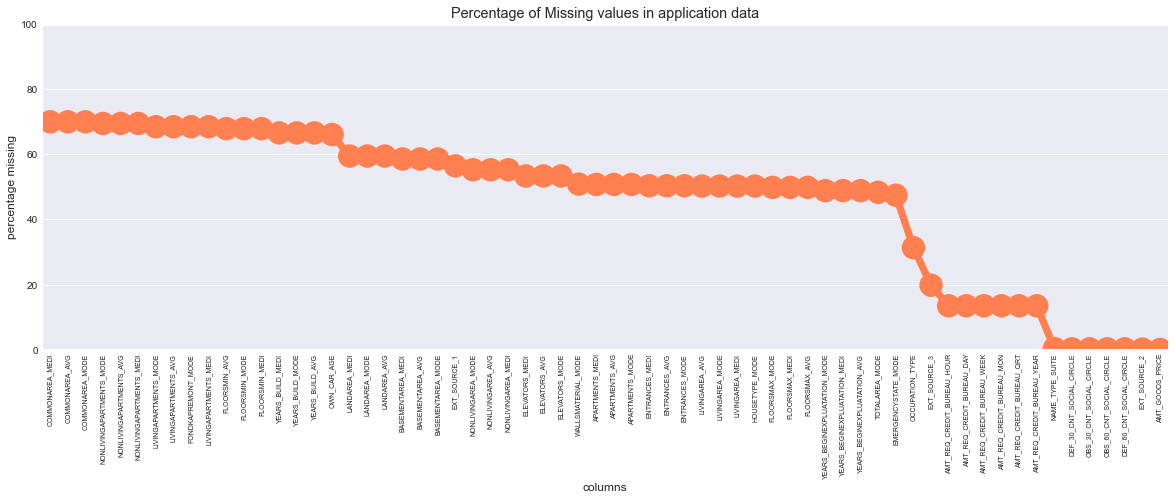

In [168]:
# fig = plt.figure(figsize=(18,6))
# df = app_train
# # Percentage of missing values
# mis_val_percent = 100 * df.isnull().sum() / len(df)
# mm = pd.DataFrame(mis_val_percent.round(1).sort_values(ascending=False))
# miss_data = pd.DataFrame(mm).reset_index()
# miss_data = miss_data[miss_data[0]>0]
# miss_data["type"] = "application data"
# sns.set_style('darkgrid')
# ax = sns.pointplot("index",0,data=miss_data, color='coral')
# plt.xticks(rotation =90,fontsize =7)
# plt.title("Percentage of Missing values in application data")
# plt.ylabel("percentage missing")
# plt.xlabel("columns")
# plt.ylim((0,100))

#### CHECK FOR CLASS IMBALANCE

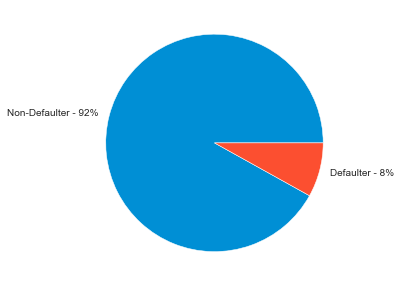

In [169]:
# Values = ['Non-Defaulter - 92%', 'Defaulter - 8%'] 

# # Creating plot 
# fig = plt.figure(figsize =(5, 5)) 
# plt.pie(app_train['TARGET'].value_counts(), labels = Values) 
  
# # show plot 
# plt.show() 

#### FEATURE ELIMINATION

In [46]:
remove_columns_app_train(app_train)

In [49]:
app_train.dtypes

SK_ID_CURR                       int64
TARGET                           int64
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
AMT_GOODS_PRICE                float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                    int64
DAYS_REGISTRATION              float64
DAYS_ID_PUBLISH                  int64
FLAG_MOBIL                       int64
FLAG_EMP_PHONE                   int64
FLAG_WORK_PHONE                  int64
FLAG_CONT_MOBILE                 int64
FLAG_PHONE               

In [48]:
collist = []
for col in app_train.columns:
    if app_train[col].dtype in ['object']:
        collist.append(col)
print (len(collist))

14


#### DATA ANALYSIS 

In [37]:
categorical_columns = []
numerical_columns = []
normal_columns = pd.DataFrame()
non_normal_columns = pd.DataFrame()
categorical_columns, numerical_columns = get_column_categories(app_train)
normal_columns, non_normal_columns = normal_test(app_train[numerical_columns], significance = .01)

#### NUMERICAL COLUMNS BEFORE DATA PREPARATION

<Figure size 432x288 with 0 Axes>

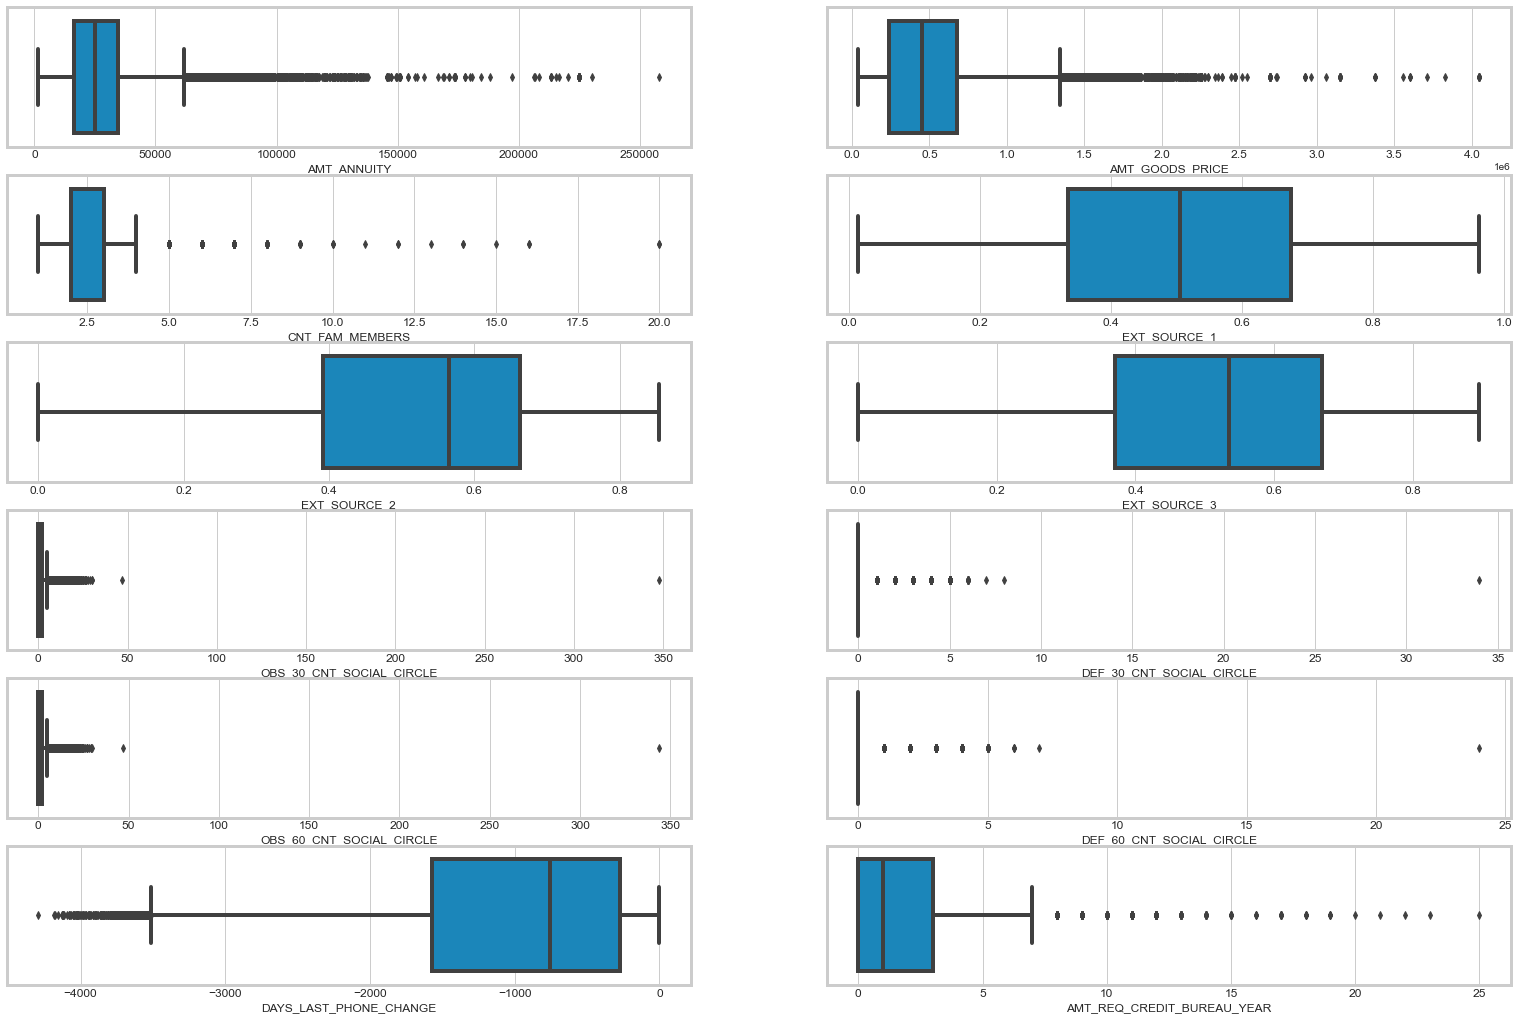

In [63]:
 plot_box_comp(normal_columns, nrow = 6)

<Figure size 432x288 with 0 Axes>

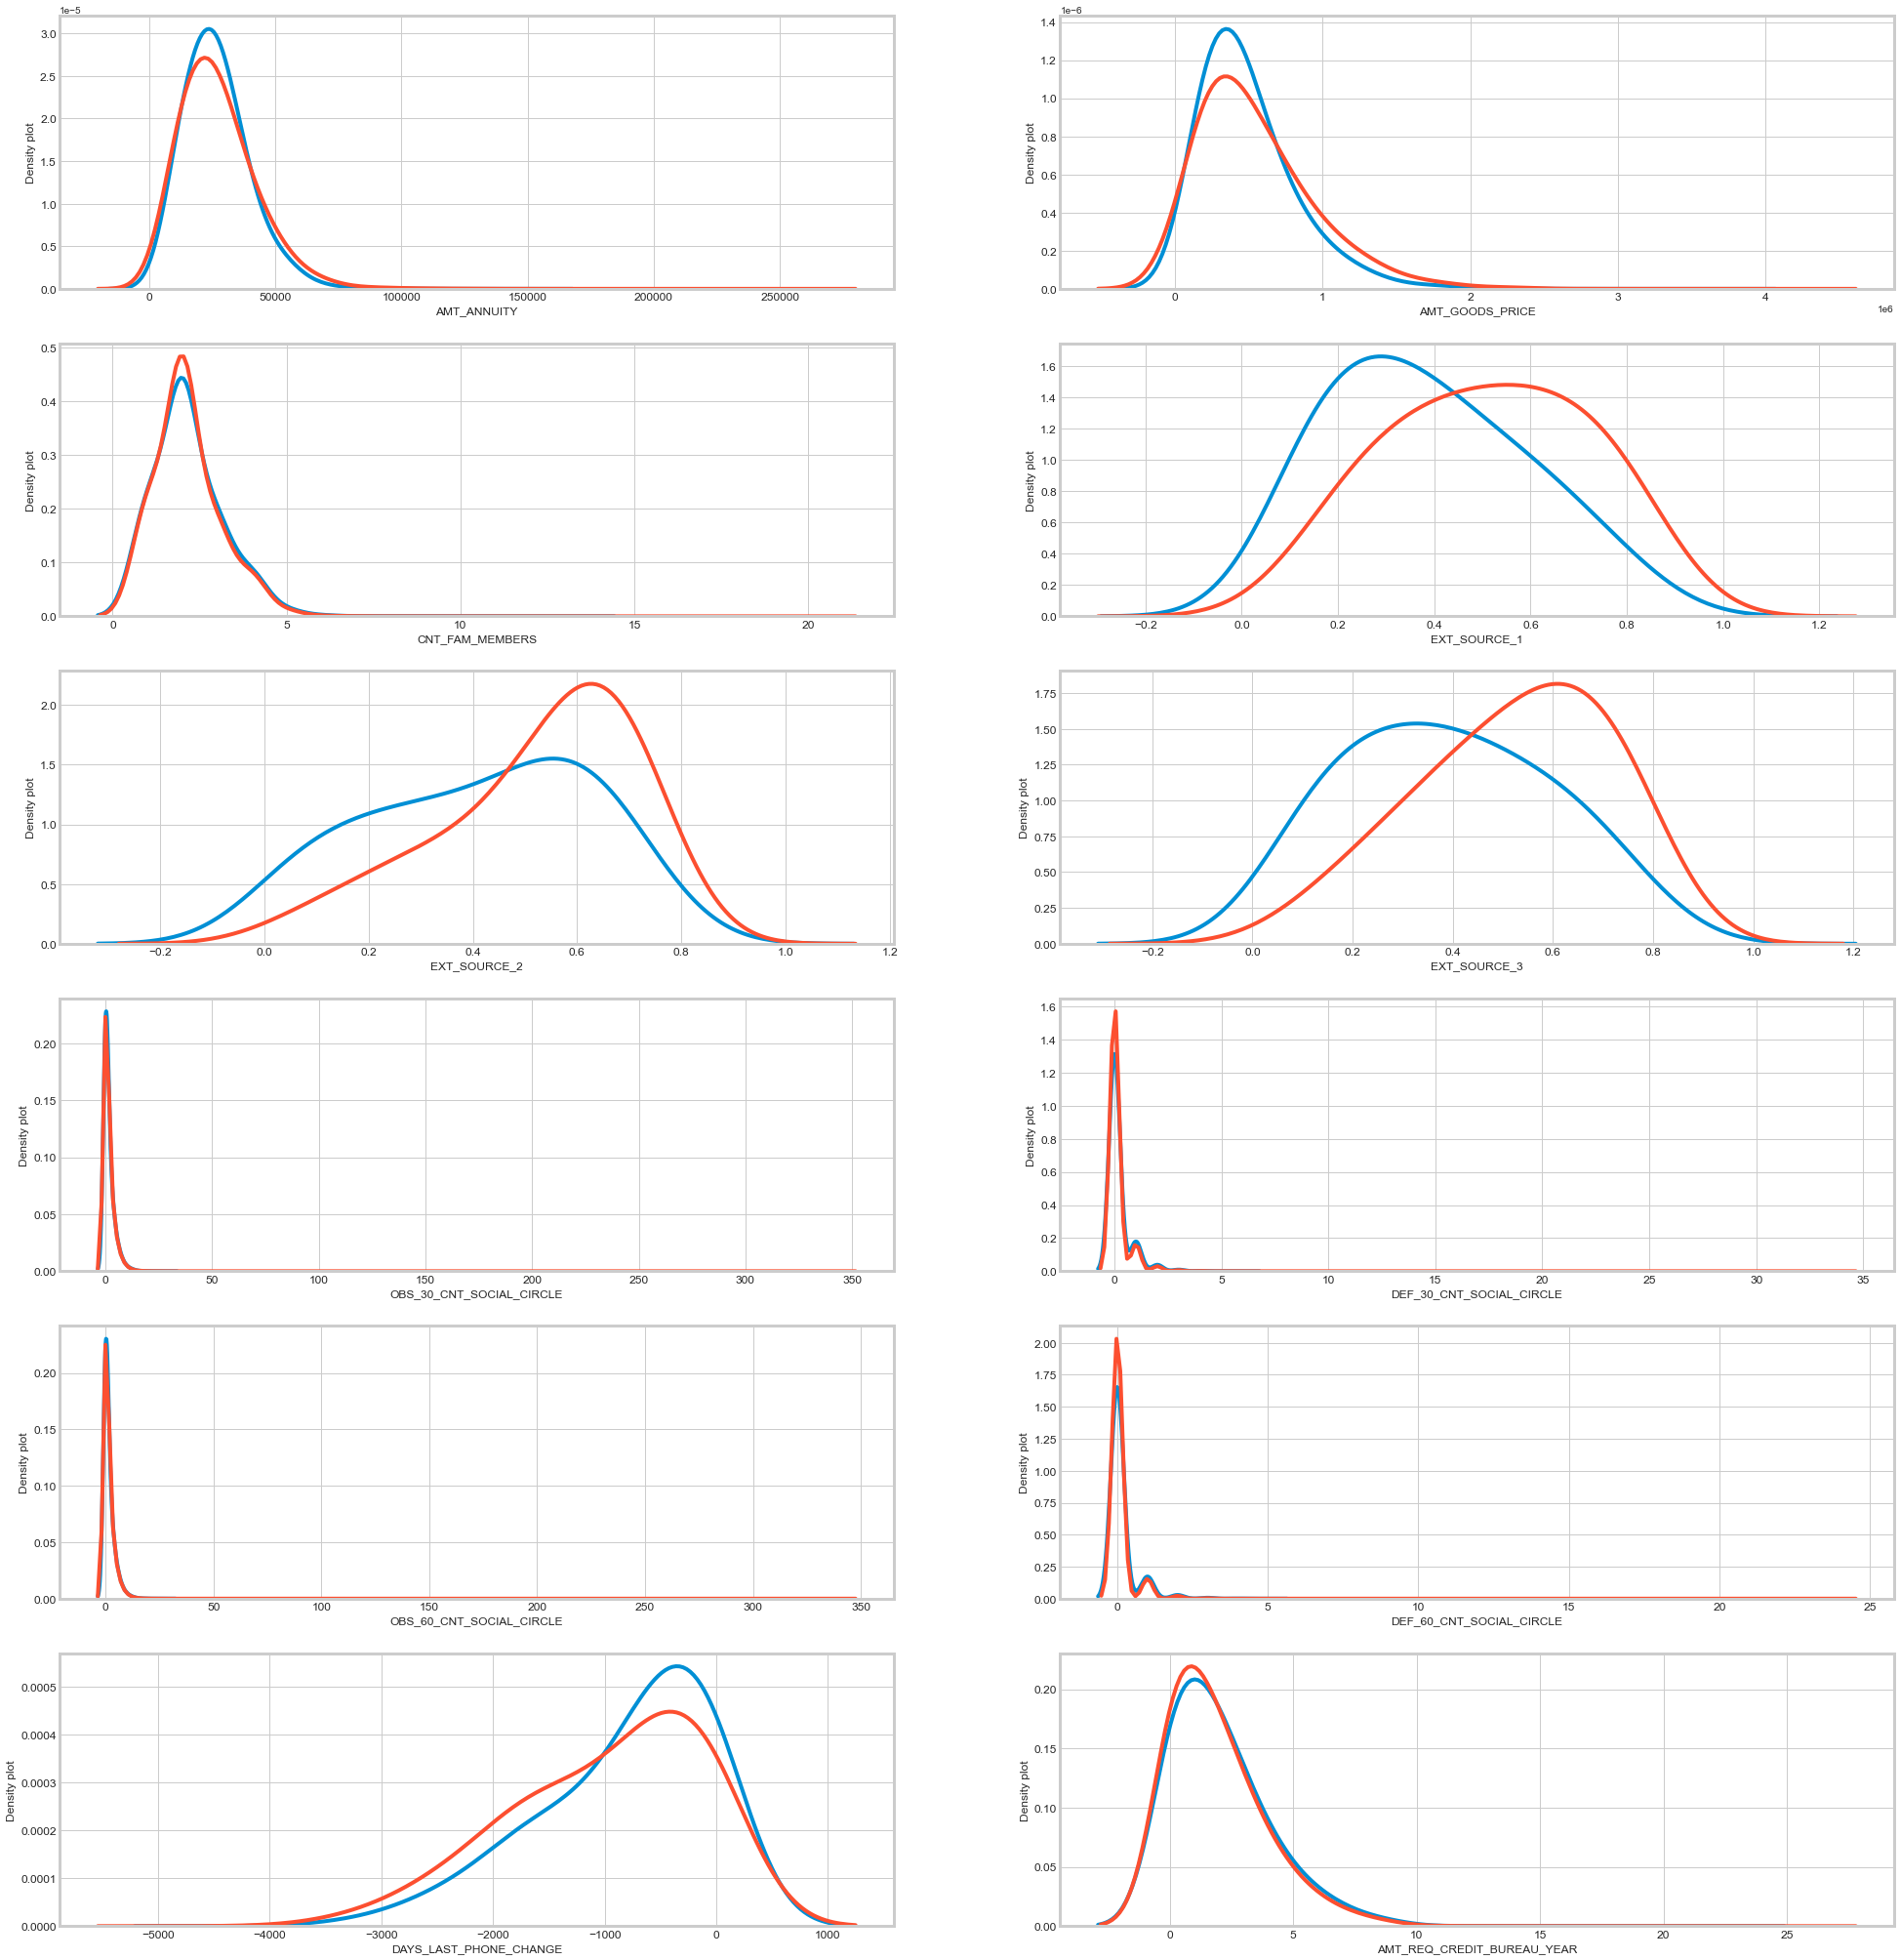

In [64]:
 plot_distribution_comp(normal_columns,nrow=6)

In [65]:
non_normal_columns.remove('SK_ID_CURR')
non_normal_columns.remove('TARGET')

<Figure size 432x288 with 0 Axes>

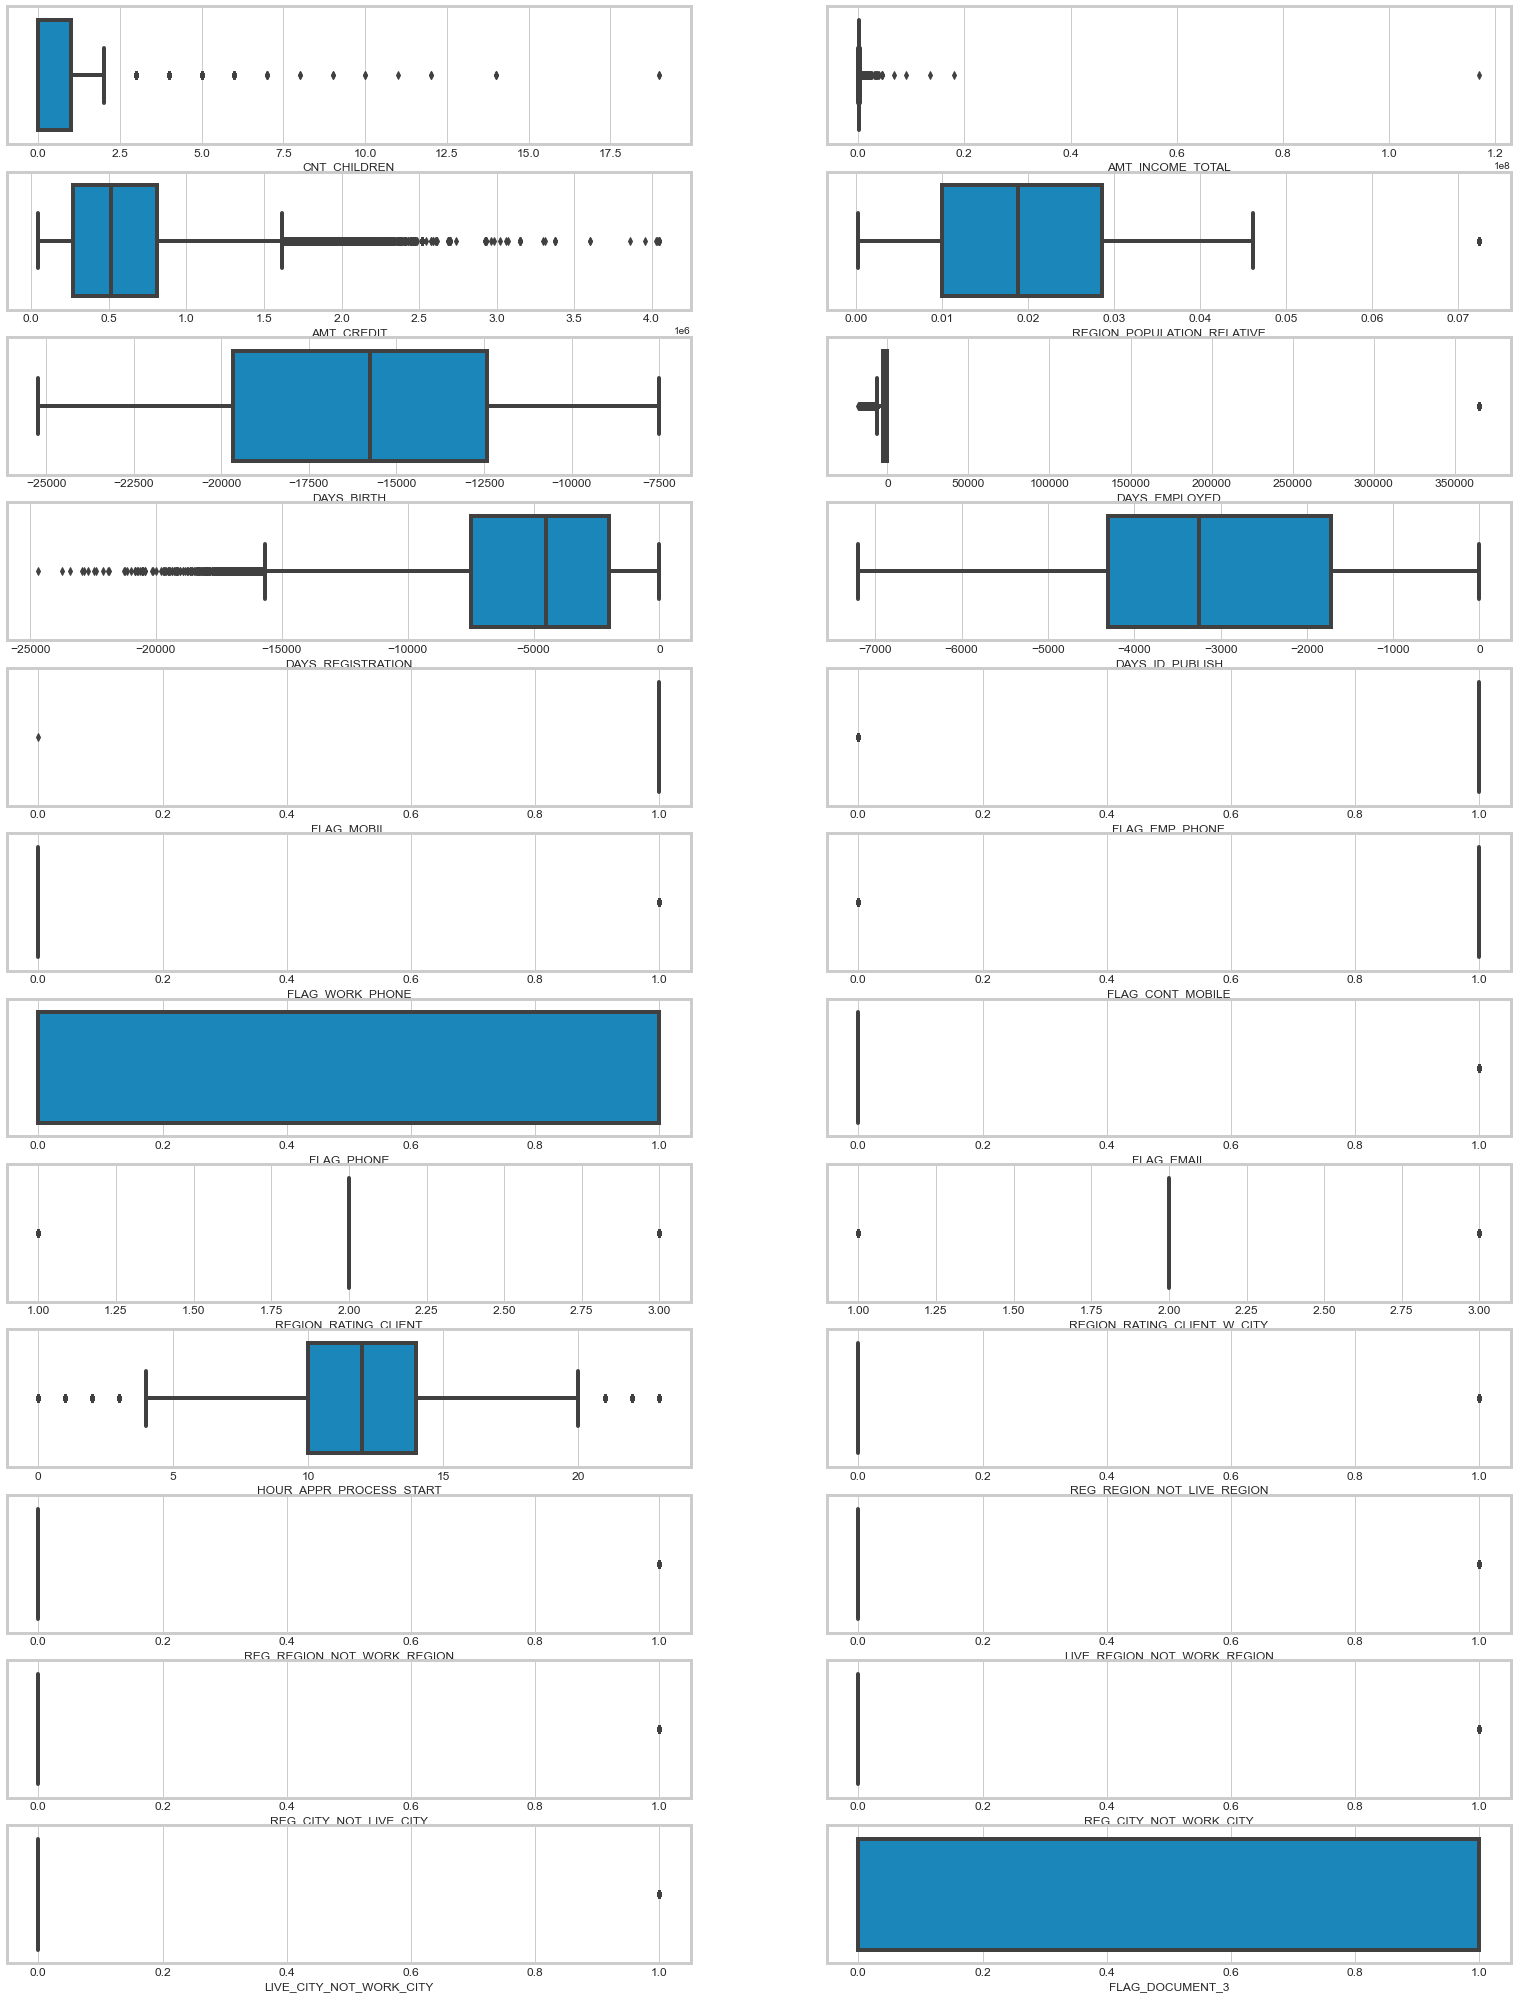

In [66]:
plot_box_comp(non_normal_columns, nrow = 12)

ValueError: num must be 1 <= num <= 12, not 13

<Figure size 432x288 with 0 Axes>

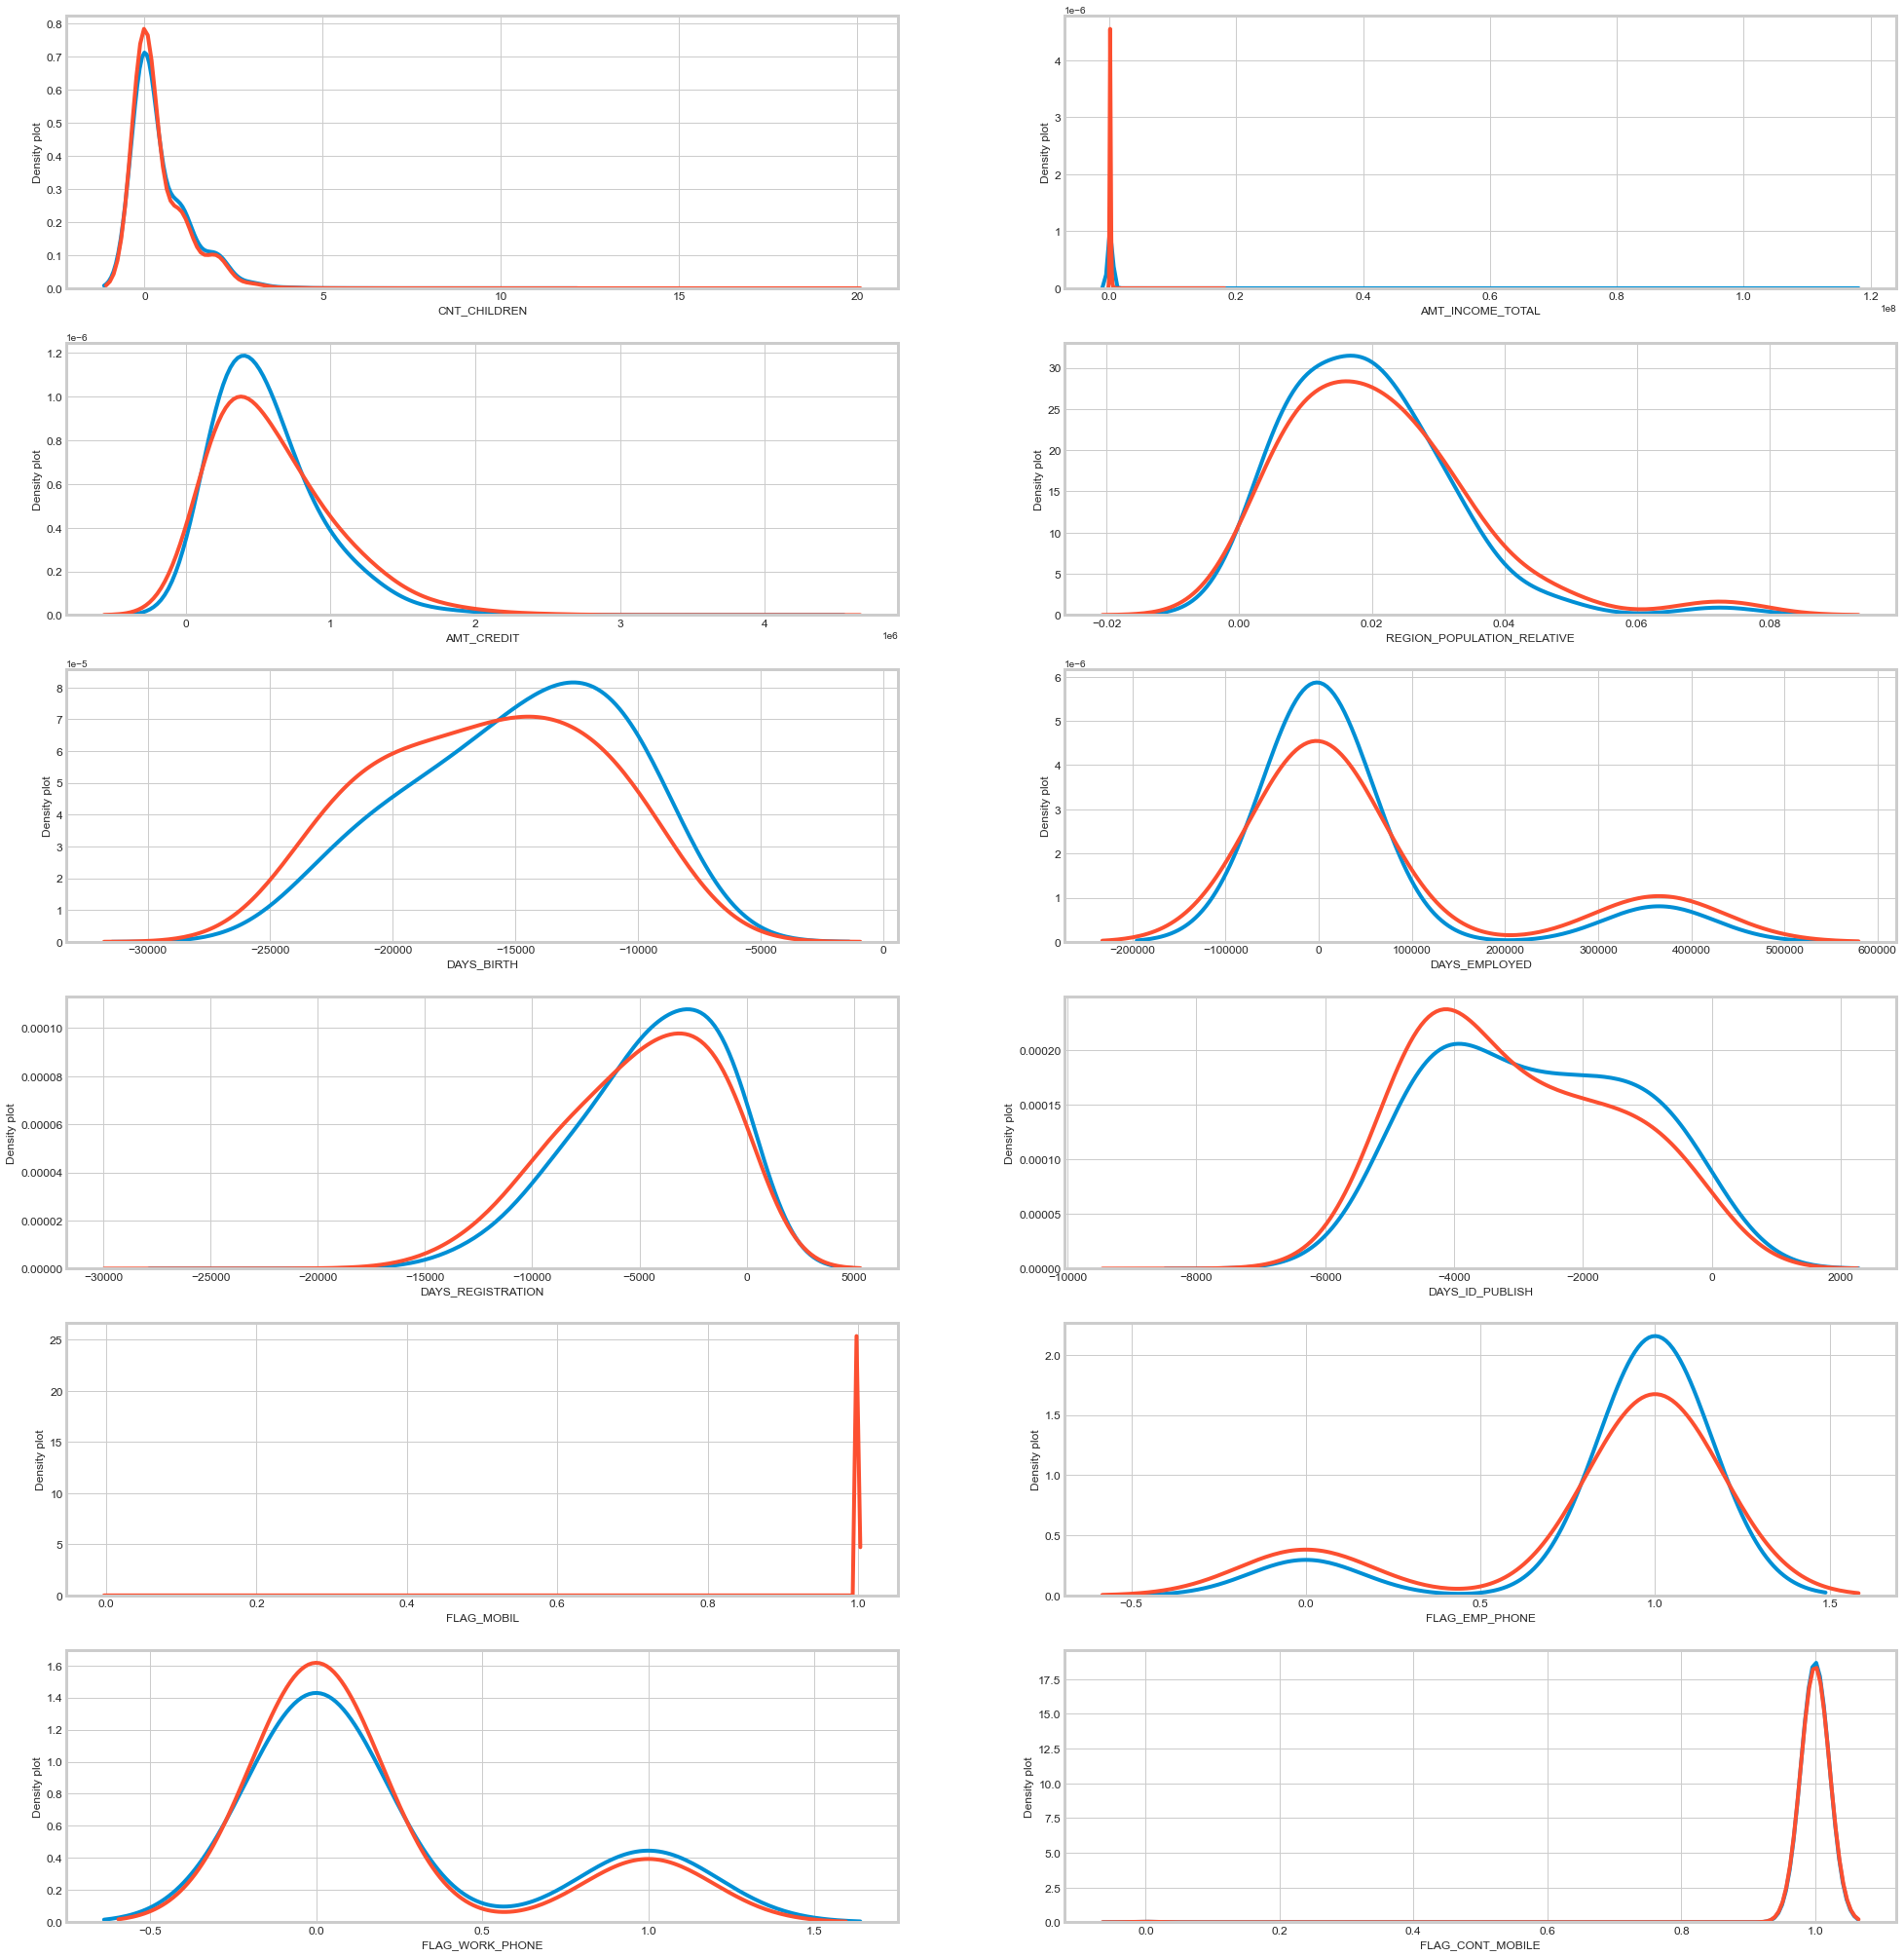

In [68]:
plot_distribution_comp(non_normal_columns,nrow=6)

#### TREAT MISSING VALUES 

In [53]:
app_train = treat_missing_values_app_train(app_train)

#### DATA ANALYSIS AFTER OUTLIER TREATMENT AND MISSING VALUE TREATMENT AND ANOMALY TREATMENT

<Figure size 432x288 with 0 Axes>

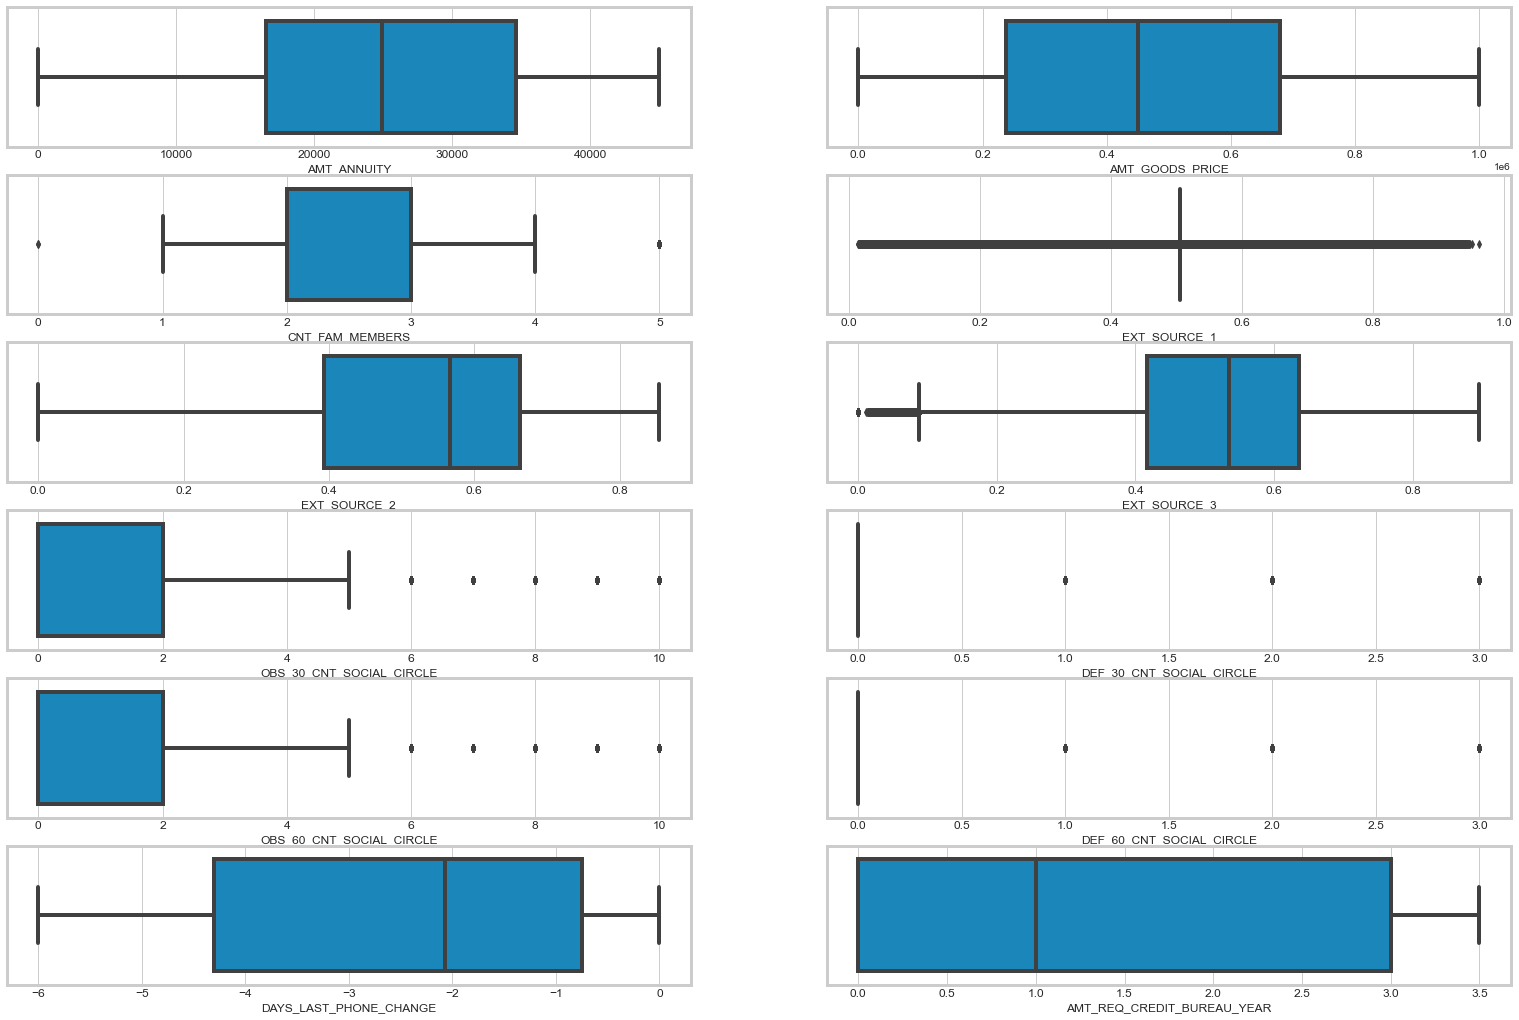

In [70]:
plot_box_comp(normal_columns, nrow = 6)

<Figure size 432x288 with 0 Axes>

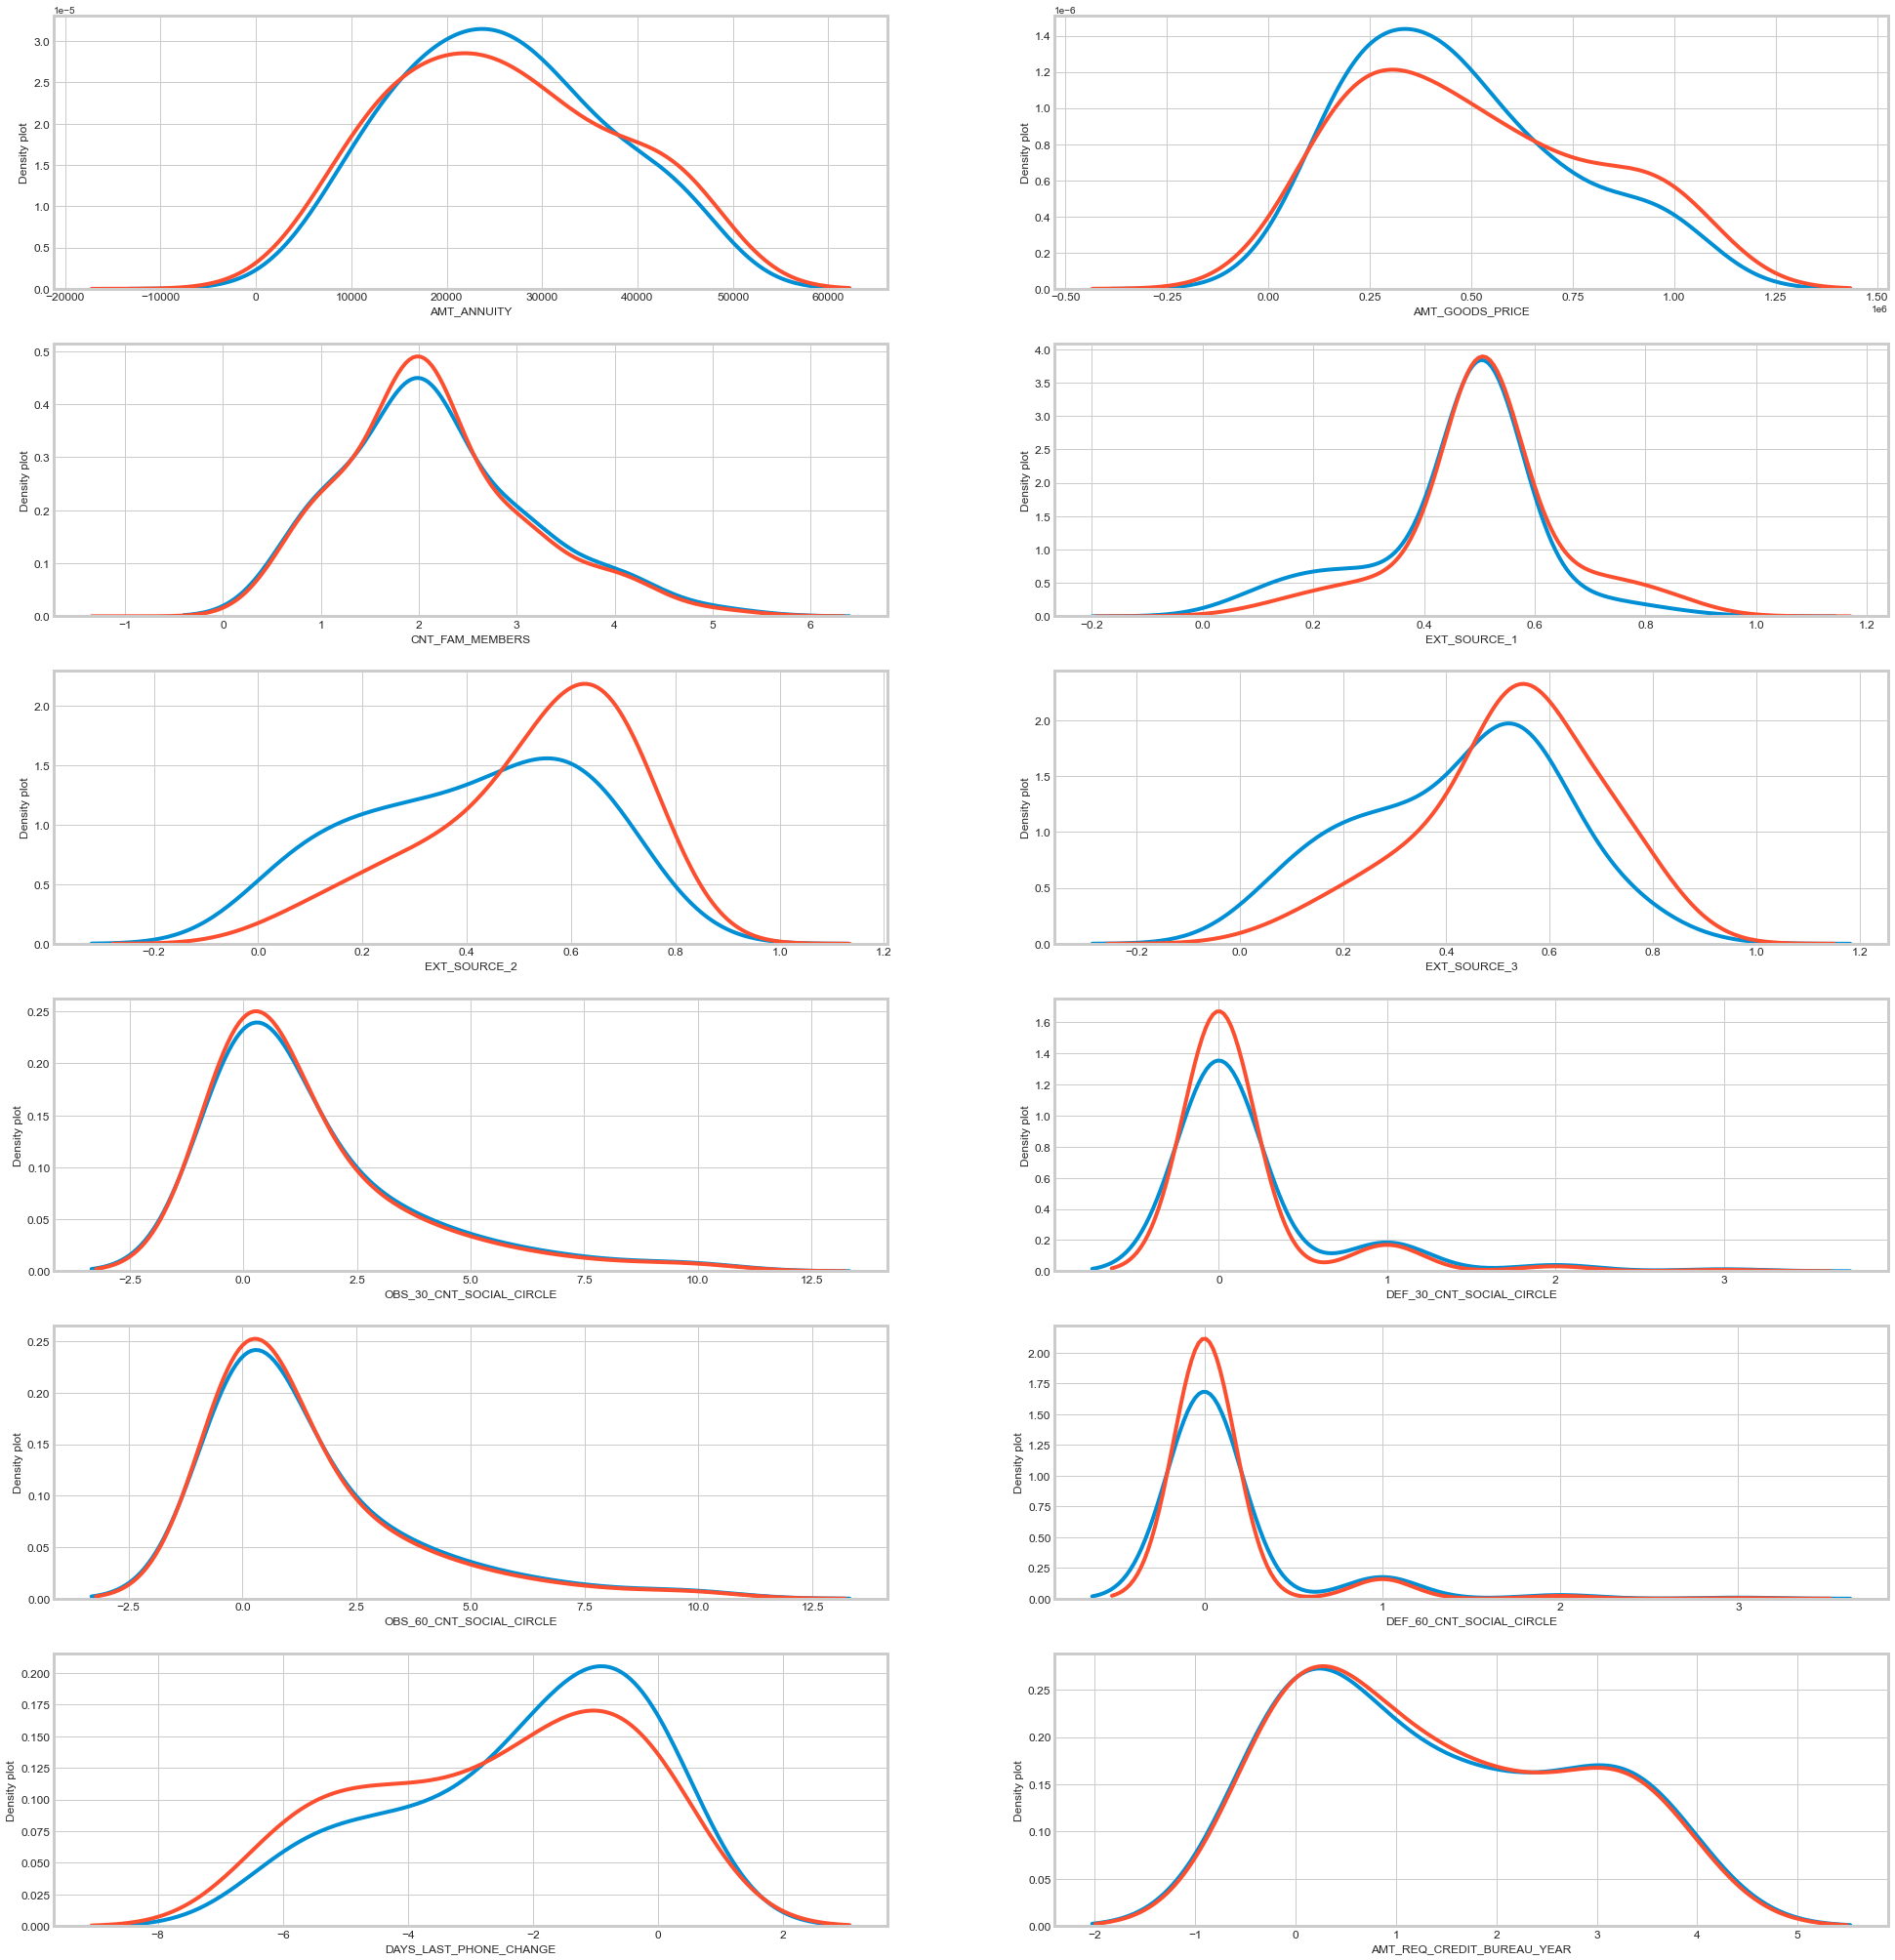

In [71]:
plot_distribution_comp(normal_columns,nrow=6)


<Figure size 432x288 with 0 Axes>

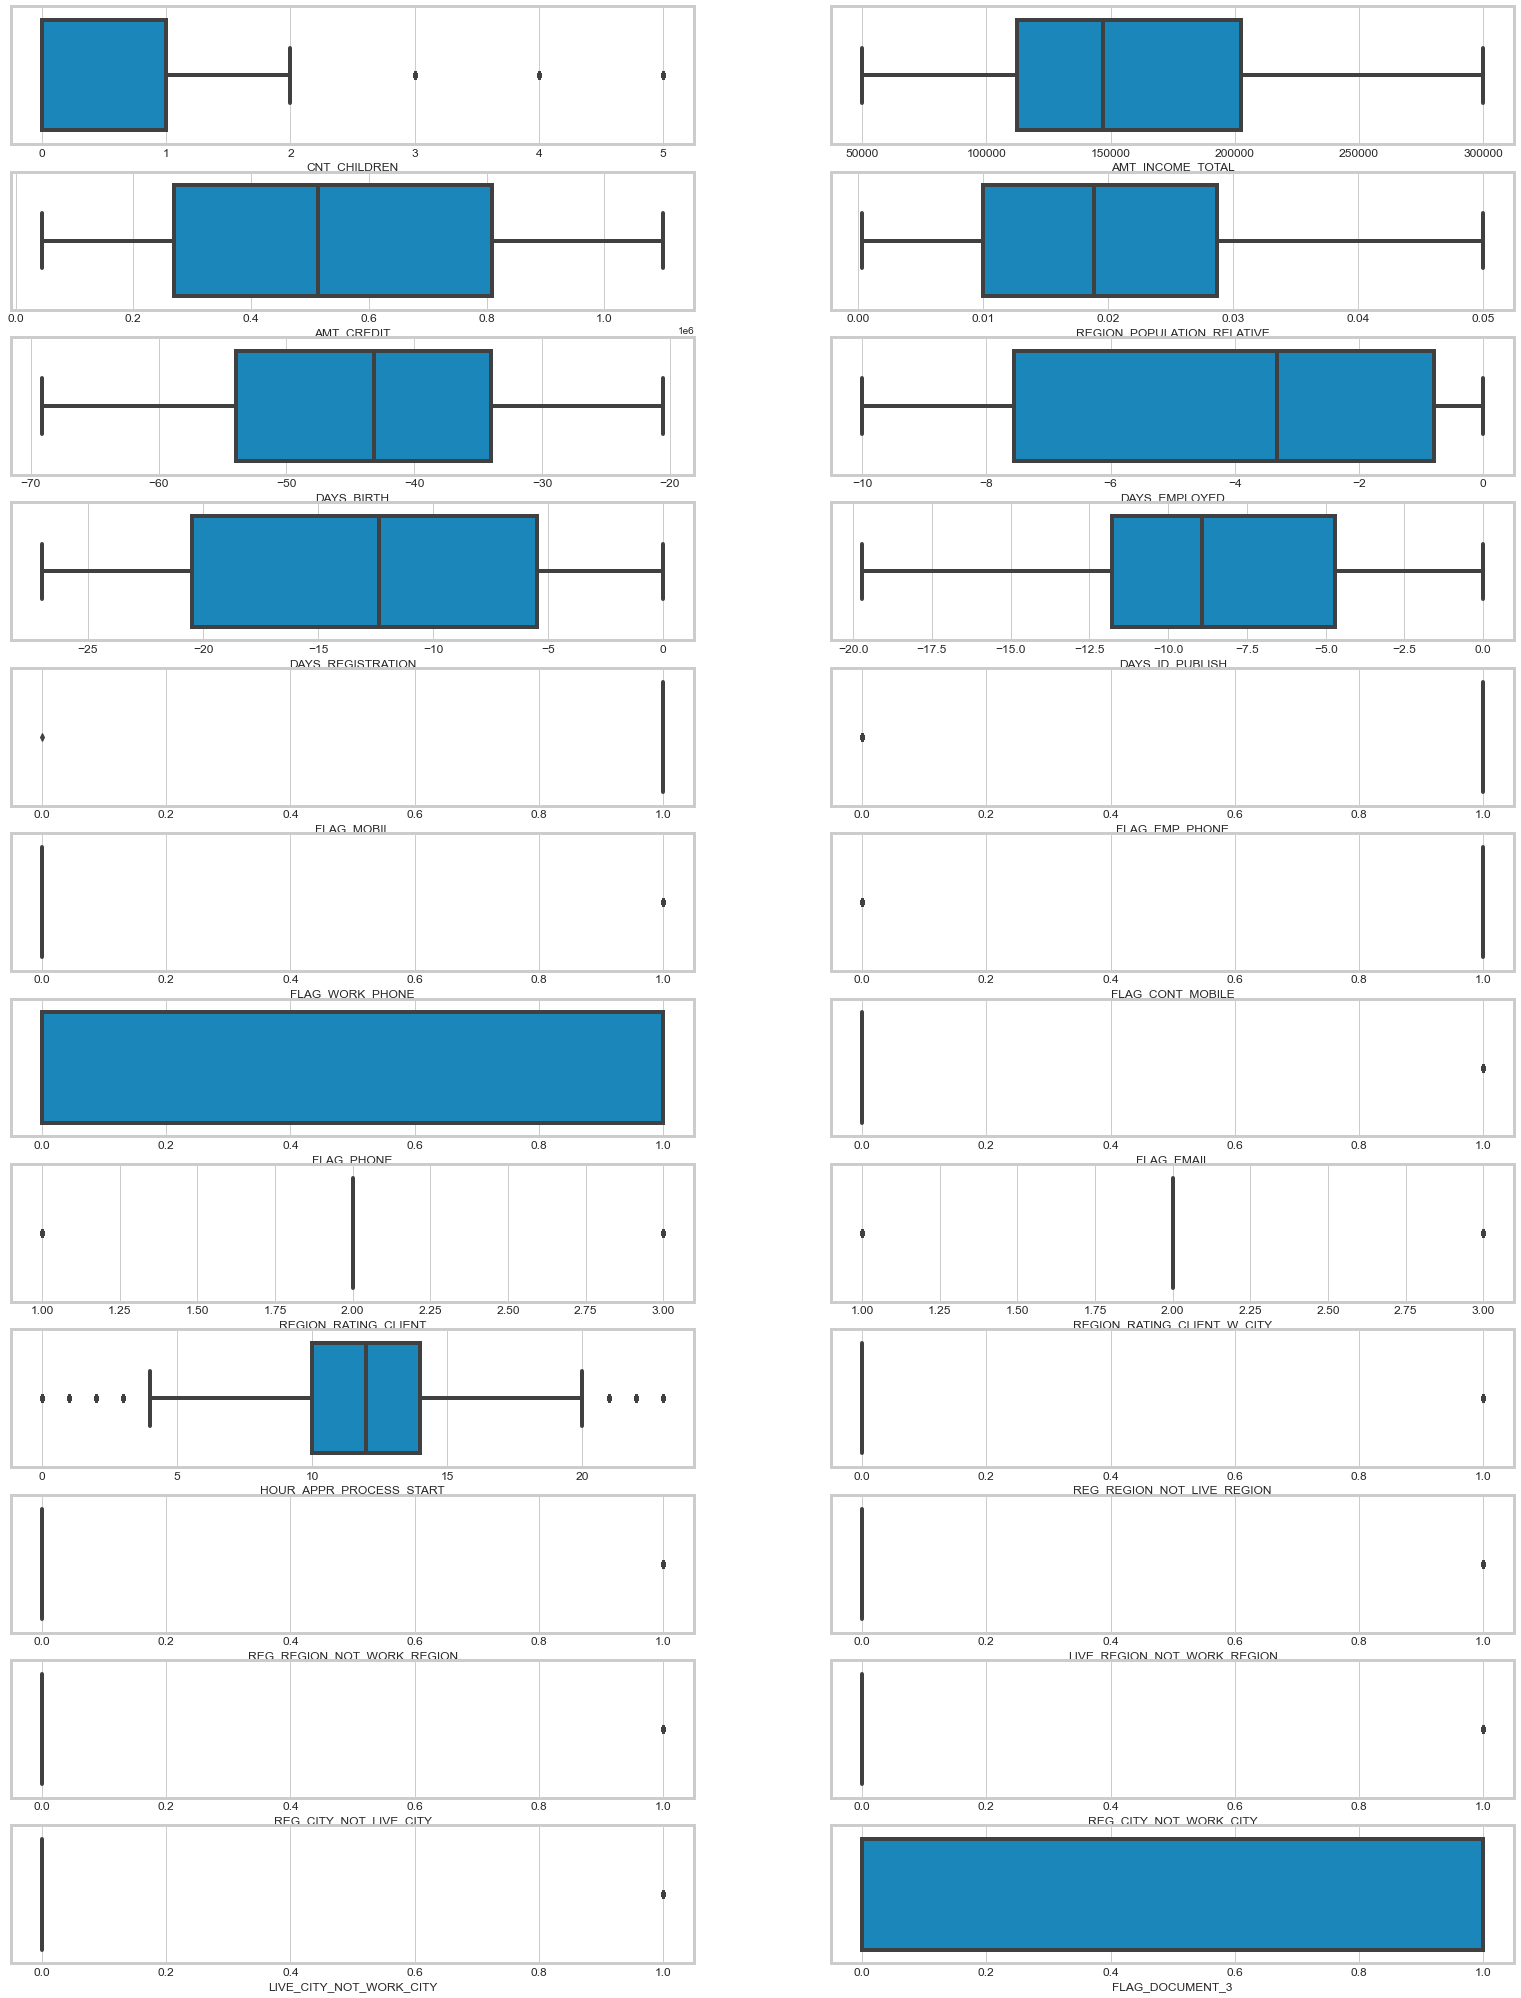

In [72]:
 plot_box_comp(non_normal_columns, nrow = 12)

ValueError: num must be 1 <= num <= 12, not 13

<Figure size 432x288 with 0 Axes>

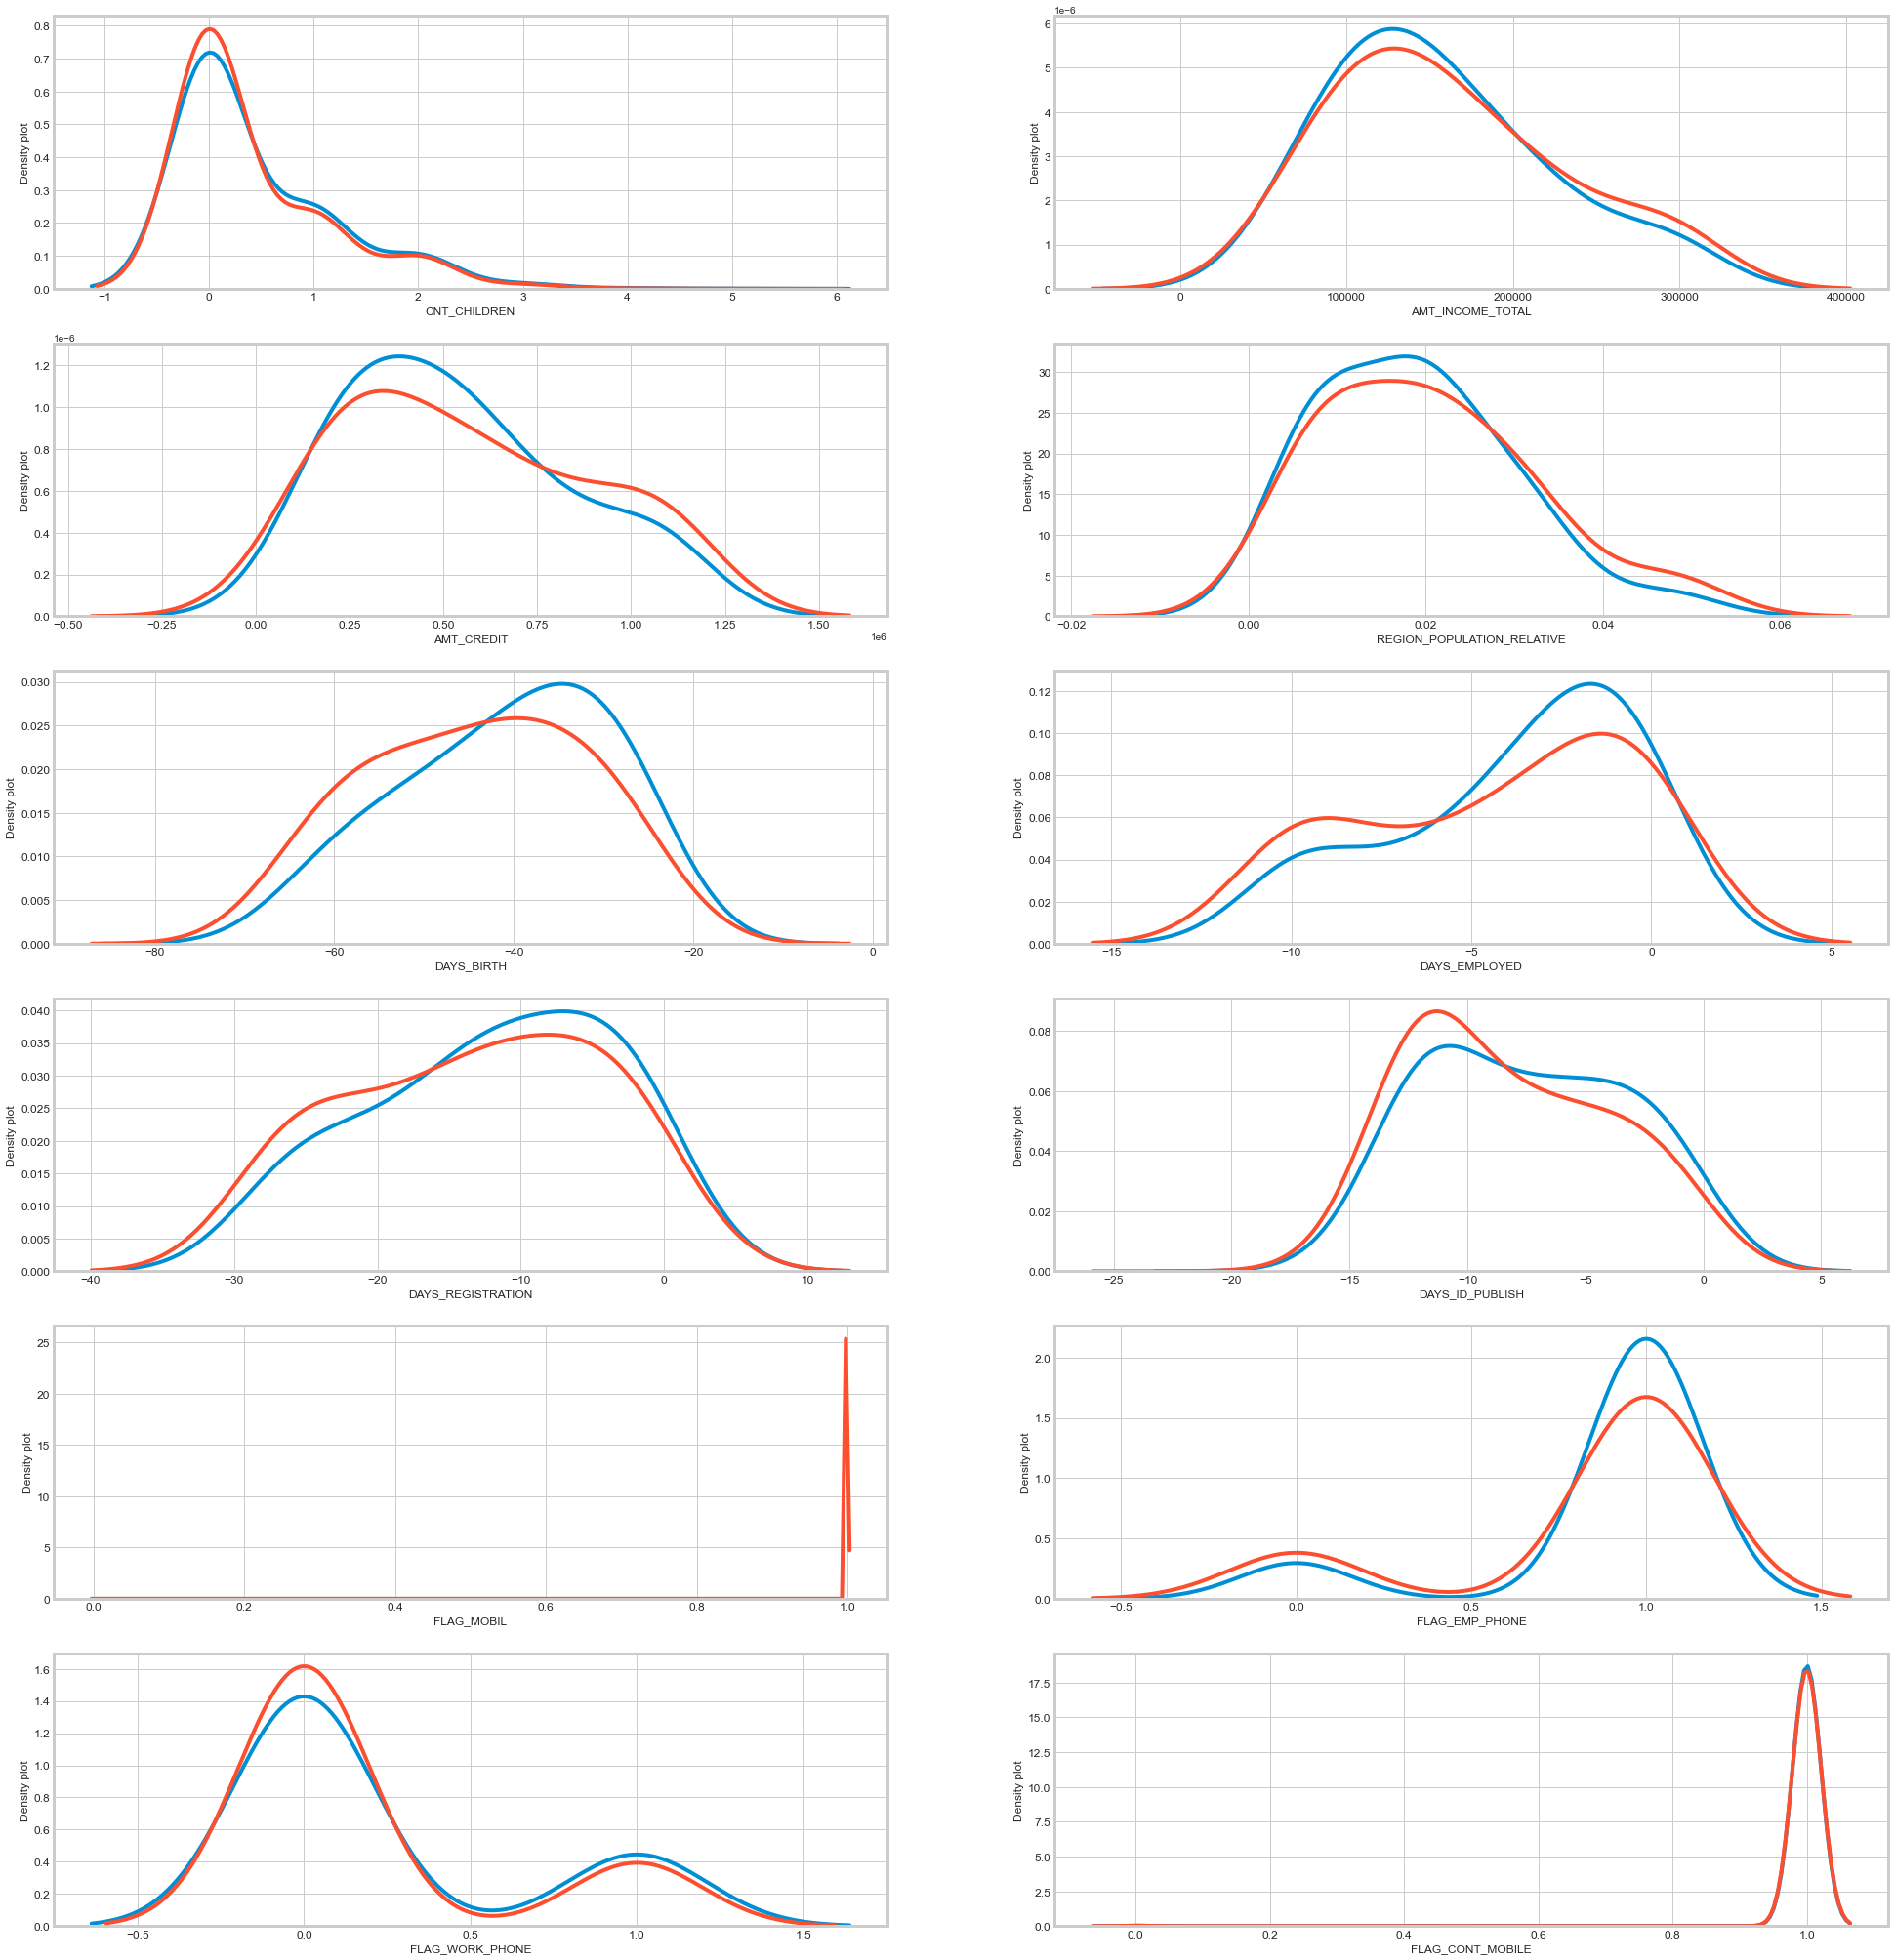

In [73]:
 plot_distribution_comp(non_normal_columns,nrow=6)

In [39]:
app_train.shape

(307511, 52)

#### FEATURE ENGINEERING

In [40]:
app_train = feature_engineering_application_train_test(app_train)

In [41]:
app_train.shape

(307511, 62)

In [55]:
for col in app_train.columns:
    if app_train[col].dtype in ['object']:
        print (col, app_train[col].nunique())

NAME_CONTRACT_TYPE 2
CODE_GENDER 2
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
NAME_TYPE_SUITE 7
NAME_INCOME_TYPE 8
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 6
NAME_HOUSING_TYPE 6
OCCUPATION_TYPE 19
WEEKDAY_APPR_PROCESS_START 7
ORGANIZATION_TYPE 58
HOUSETYPE_MODE 3
EMERGENCYSTATE_MODE 2


In [56]:
collist = ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE','NAME_FAMILY_STATUS']

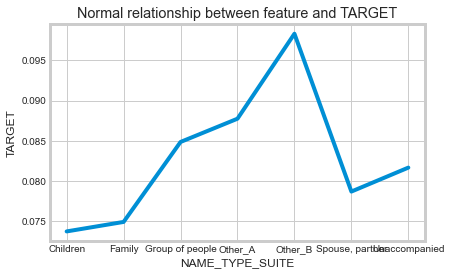

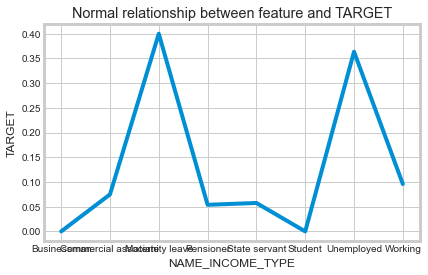

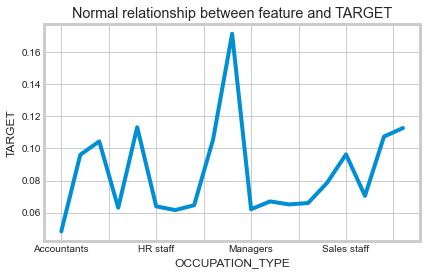

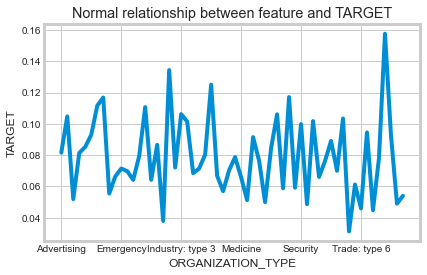

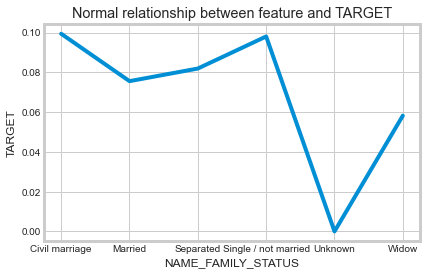

In [64]:
# plot the original variable
for feature in collist:
    fig = plt.figure()
    fig = app_train.groupby([feature])['TARGET'].mean().plot()
    fig.set_title('Normal relationship between feature and TARGET')
    fig.set_ylabel('TARGET')



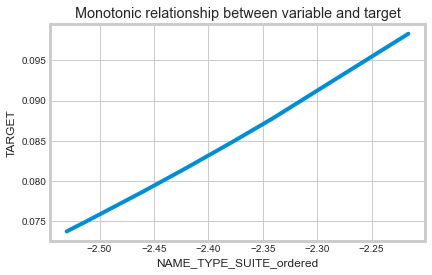

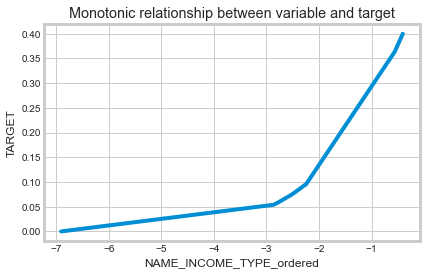

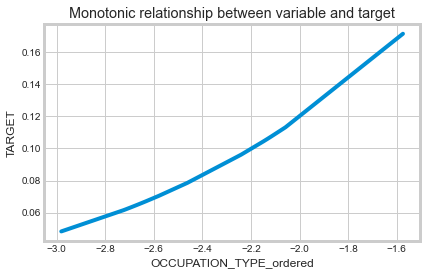

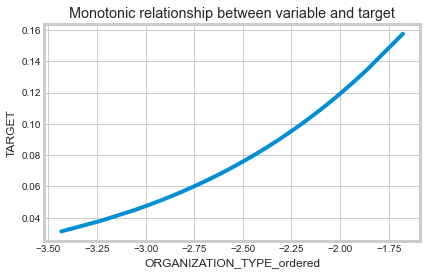

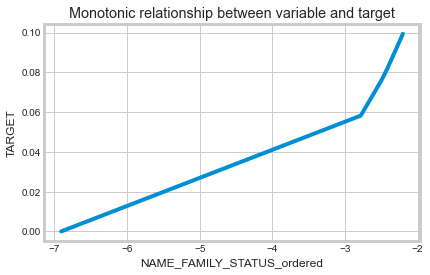

In [67]:
# plot the transformed result: the monotonic variable
for feature in collist:
    feature = str(feature) + "_ordered"
    fig = plt.figure()
    fig = app_train.groupby([feature])['TARGET'].mean().plot()
    fig.set_title('Monotonic relationship between variable and target')
    fig.set_ylabel('TARGET')

#### FEATURE ENCODING

In [65]:
app_train = apply_feat_encoding(app_train)

In [181]:
print('Current Loans Train dataset shape: ',app_train.shape)
app_train.info()

Current Loans Train dataset shape:  (307511, 62)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 62 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   SK_ID_CURR                          307511 non-null  int64  
 1   TARGET                              307511 non-null  int64  
 2   NAME_CONTRACT_TYPE                  307511 non-null  int32  
 3   CODE_GENDER                         307511 non-null  int32  
 4   FLAG_OWN_CAR                        307511 non-null  int32  
 5   FLAG_OWN_REALTY                     307511 non-null  int32  
 6   CNT_CHILDREN                        307511 non-null  int64  
 7   AMT_INCOME_TOTAL                    307511 non-null  float64
 8   AMT_CREDIT                          307511 non-null  float64
 9   AMT_ANNUITY                         307511 non-null  float64
 10  AMT_GOODS_PRICE                     307511 

634

# BUREAU

#### LOAD DATASET

In [76]:
dataset_path = 'bureau.csv'
df_bueau = pd.read_csv(dataset_path, parse_dates=True, keep_date_col=True)
print('Bureau data shape: ', df_bueau.shape)

dataset_path = 'bureau_balance.csv'
df_bueau_balance = pd.read_csv(dataset_path, parse_dates=True, keep_date_col=True)
print('Burau Balance data shape: ', df_bueau_balance.shape)

Bureau data shape:  (1716428, 17)
Burau Balance data shape:  (27299925, 3)


#### FEATURE ELIMINATION

In [77]:
remove_columns_bureau(df_bueau)

#### DATA ANALYSIS 

In [ ]:
# get plot for categorical variables 
df = pd.DataFrame(columns=('Feature Names', '# of Categories'))
i = 0
for col in df_bueau.columns:
    if df_bueau[col].dtype in ['object']:
        #print (col, app_train[col].nunique())
        df.loc[i] = [col, df_bueau[col].nunique()]
        i = i +1
df = df.sort_values( by='# of Categories', ascending=False)
#s = sns.barplot( y = df.feat, x=df.val ,data=df)
s = sns.barplot( y = 'Feature Names', x='# of Categories' ,data=df)
for index, row in df.iterrows():
    #s.text(row.name,row[1],  color='black', ha="left")        
    s.text(row.name,row[1], row[1], color='black', ha="left")
s.set_title("Bureau Dataset")

In [80]:
df_bueau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   SK_ID_CURR           int64  
 1   SK_ID_BUREAU         int64  
 2   CREDIT_ACTIVE        object 
 3   CREDIT_CURRENCY      object 
 4   DAYS_CREDIT          int64  
 5   DAYS_CREDIT_ENDDATE  float64
 6   DAYS_ENDDATE_FACT    float64
 7   AMT_CREDIT_SUM       float64
 8   AMT_CREDIT_SUM_DEBT  float64
 9   CREDIT_TYPE          object 
 10  DAYS_CREDIT_UPDATE   int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 144.0+ MB


In [81]:
collist = []
for col in df_bueau.columns:
    if str(df_bueau[col].dtype) not in ("object"):
        collist.append(col)
collist.remove('SK_ID_CURR')
collist.remove('SK_ID_BUREAU')
collist

['DAYS_CREDIT',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'DAYS_CREDIT_UPDATE']

#### BEFORE TREATMENT

<Figure size 432x288 with 0 Axes>

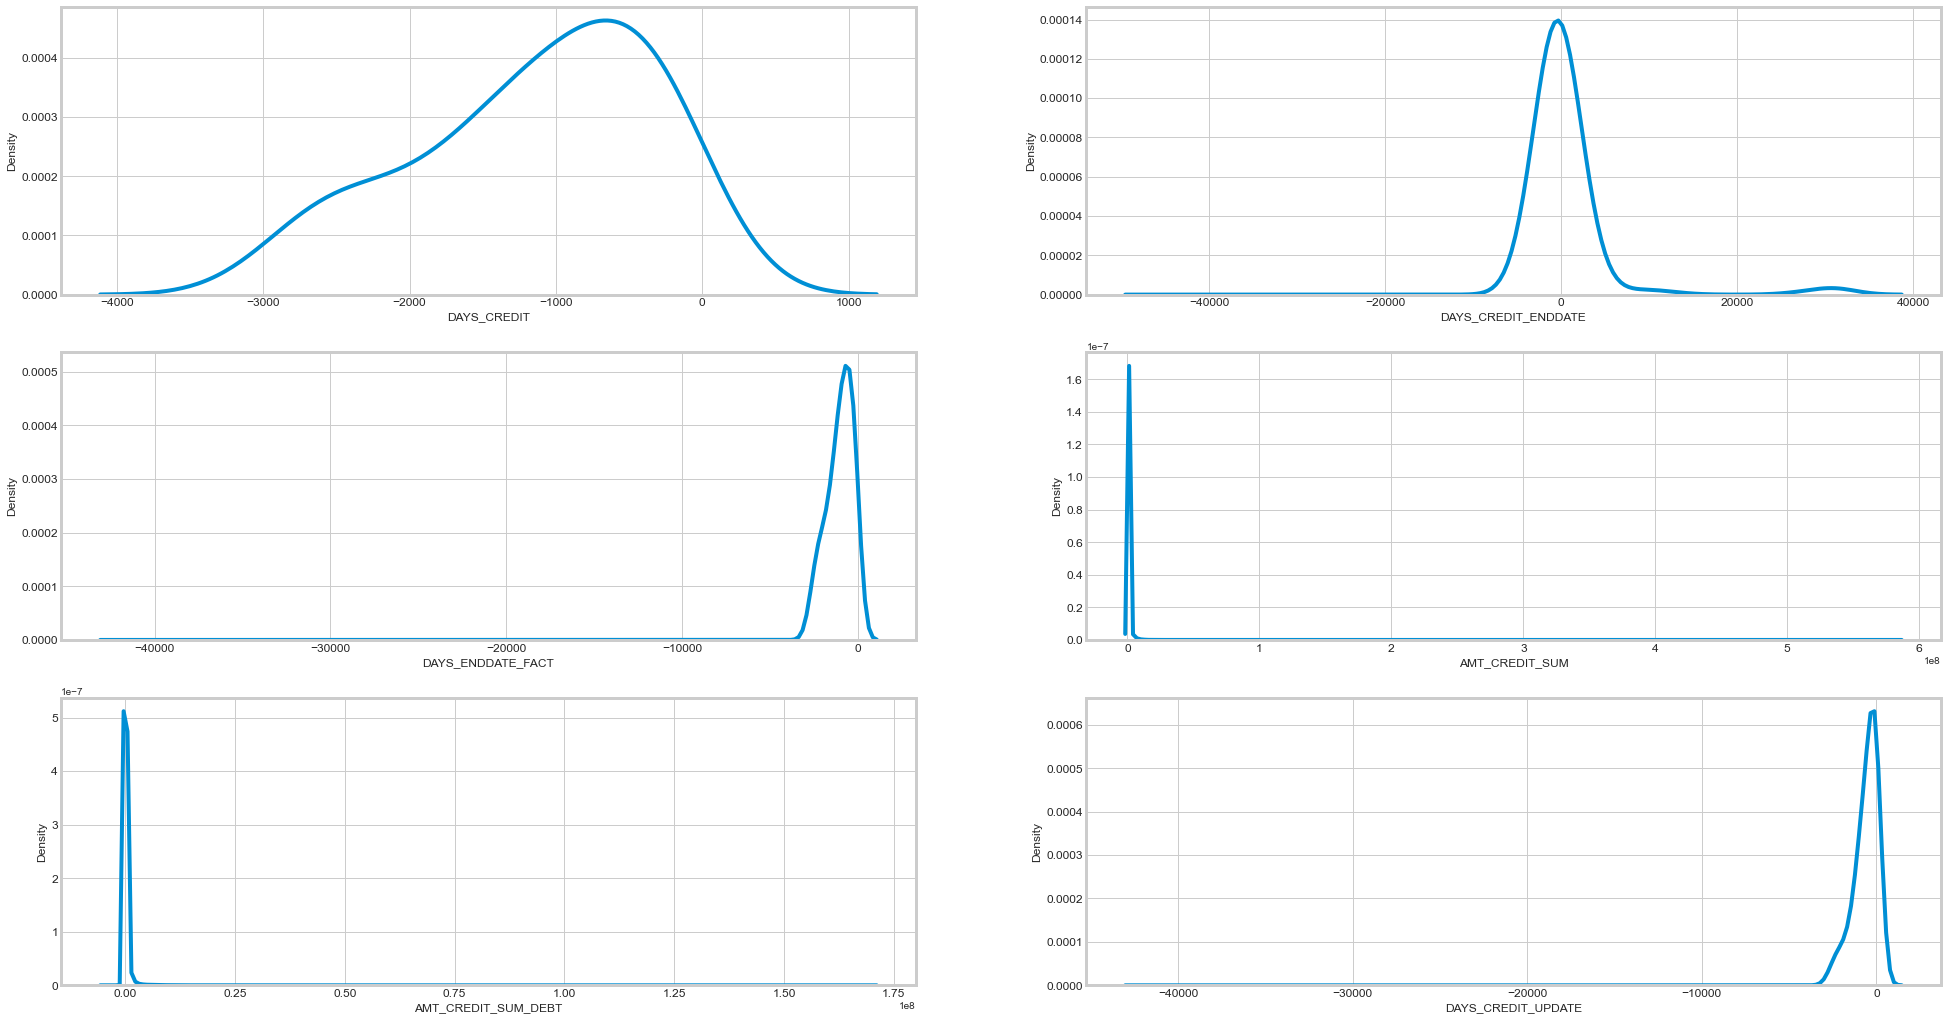

In [82]:
disp_dist(df_bueau, collist)

<Figure size 432x288 with 0 Axes>

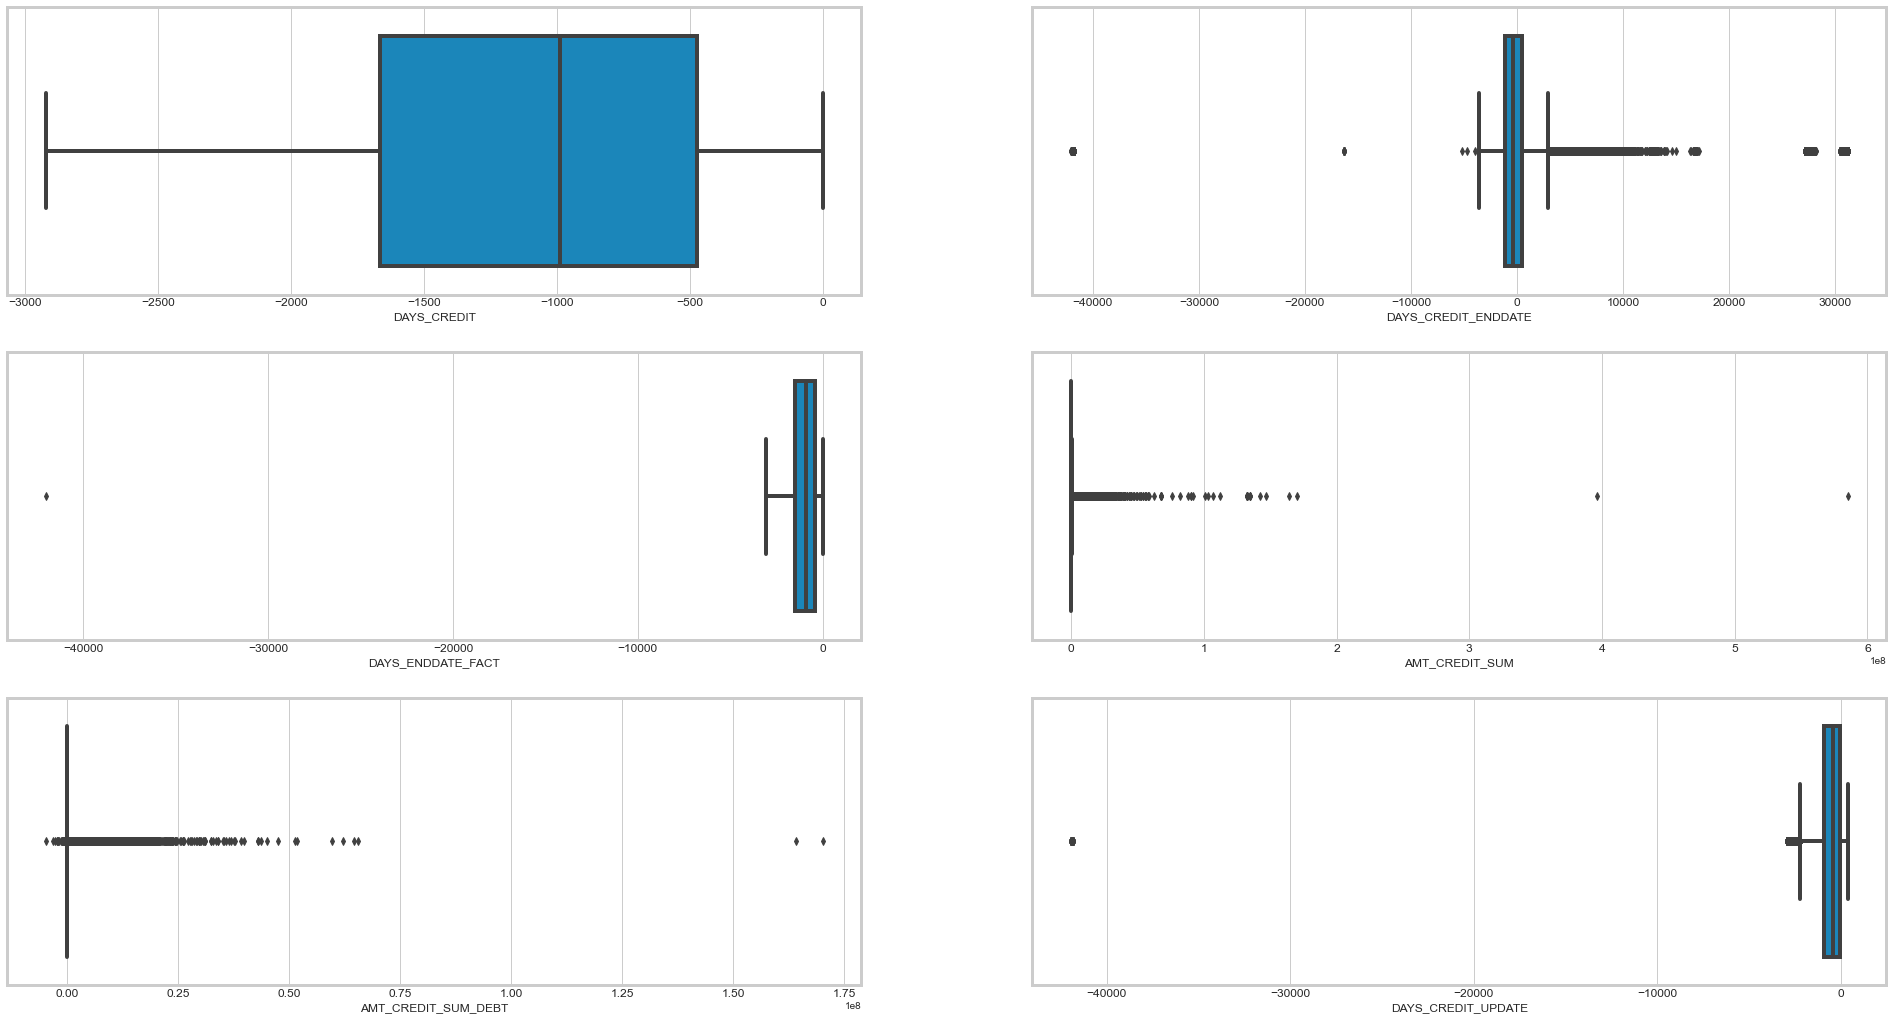

In [83]:
disp_box(df_bueau, collist)

#### TREAT MISSING VALUES, ANOMALIES, OUTLIERS 

In [84]:
df_bueau = treat_missing_values_bureau(df_bueau)

#### AFTER TREATMENT

<Figure size 432x288 with 0 Axes>

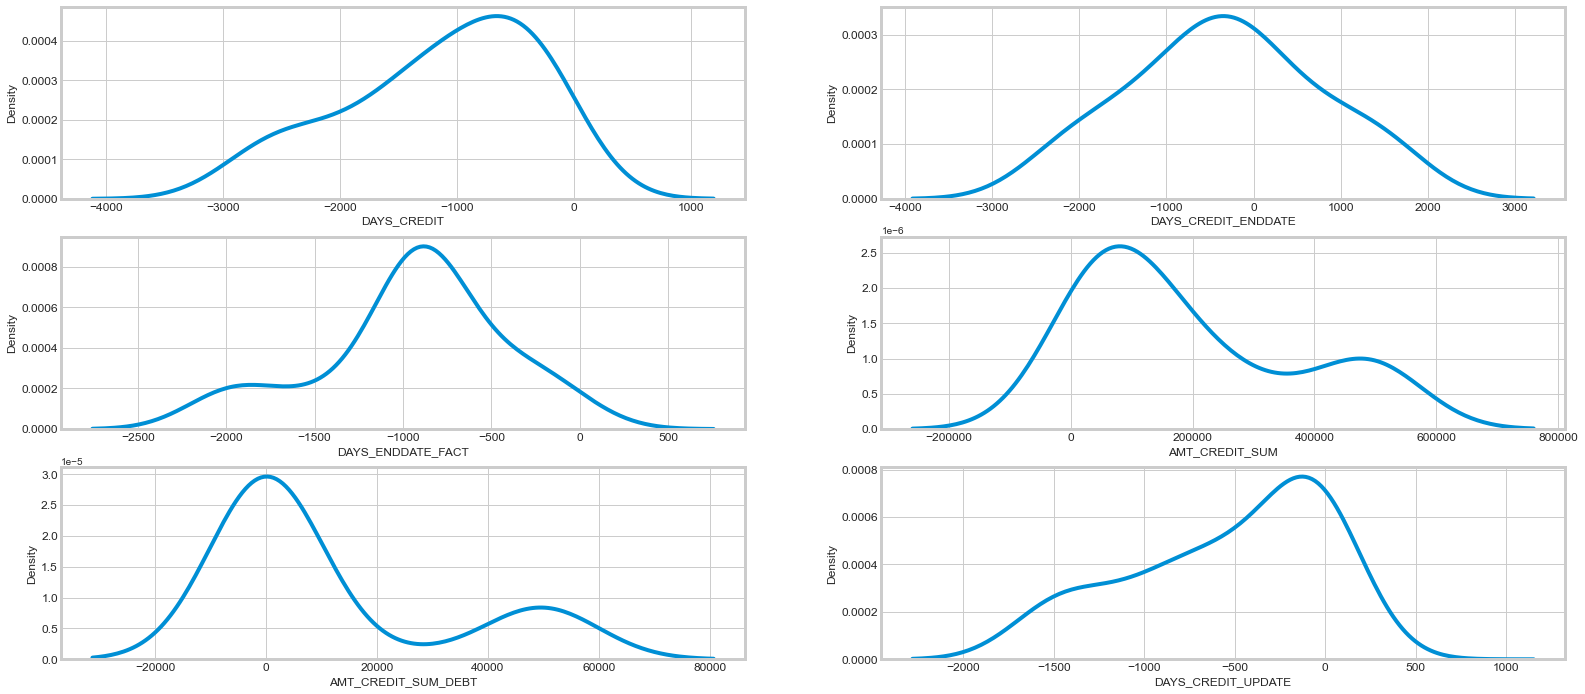

In [91]:
disp_dist(df_bueau, collist)

<Figure size 432x288 with 0 Axes>

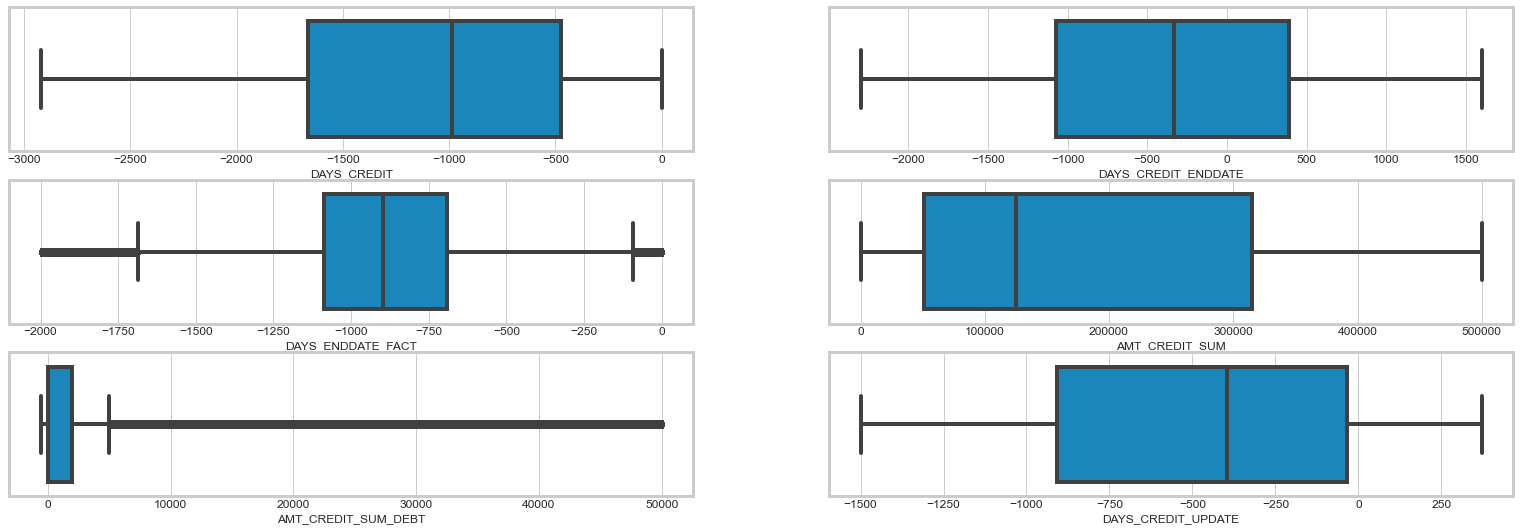

In [92]:
disp_box(df_bueau, collist)

#### ADDING TARGET TO BUREAU

In [199]:
df_target = app_train[['SK_ID_CURR','TARGET']]
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   SK_ID_CURR  307511 non-null  int64
 1   TARGET      307511 non-null  int64
dtypes: int64(2)
memory usage: 4.7 MB


In [200]:
df_bueau = df_bueau.merge(right=df_target.reset_index(), how='left', on='SK_ID_CURR')
coldrop = ['index']
df_bueau.drop(coldrop, axis = 1, inplace=True)

In [201]:
del df_target
gc.collect()

0

In [202]:
# Preprocess bureau.csv and bureau_balance.csv
#def bureau_and_balance(df_bueau, df_bueau_balance, num_rows = None, nan_as_category = True):
nan_as_category = True
bureau = df_bueau
bb = df_bueau_balance
#FEATURE ENCODING
bb, bb_cat = old_one_hot_encoder(bb, nan_as_category)
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)


# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(columns= 'SK_ID_BUREAU', inplace= True)
del bb, bb_agg
gc.collect()

# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
# Bureau: Active credits - using only numerical aggregations
# active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
# active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
# active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
# bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
# del active, active_agg
# gc.collect()
# # Bureau: Closed credits - using only numerical aggregations
# closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
# closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
# closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
# bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
del  bureau
gc.collect()
#return bureau_agg



0

In [203]:
print("Bureau df shape:", bureau_agg.shape)

Bureau df shape: (305811, 32)


In [204]:
#bureau = bureau_and_balance(df_bueau, df_bueau_balance, num_rows)
print("Bureau df shape:", bureau_agg.shape)
fill_missing_columns(bureau_agg)
find_missing_columns(bureau_agg)
app_train = app_train.join(bureau_agg, how='left', on='SK_ID_CURR')
fill_missing_columns_other_than_target(app_train)
find_missing_columns(app_train)
del bureau_agg
gc.collect()
del  df_bueau, df_bueau_balance
gc.collect()

Bureau df shape: (305811, 32)


0

18099

# PREVIOUS APPLICATION

#### LOADING DATASETS

In [94]:
dataset_path = 'previous_application.csv'
df_prev_app = pd.read_csv(dataset_path, parse_dates=True, keep_date_col=True)
print('Previous Loans Dataset shape: ', df_prev_app.shape)

Previous Loans Dataset shape:  (1670214, 37)


#### FEATURE ELIMINATION

In [95]:
remove_columns_prev_app(df_prev_app)

#### BEFORE TREATMENT

In [96]:
collist = []
for col in df_prev_app.columns:
    if str(df_prev_app[col].dtype) not in ("object"):
        collist.append(col)
collist.remove('SK_ID_PREV')        
collist.remove('SK_ID_CURR')  
collist

['AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

<Figure size 432x288 with 0 Axes>

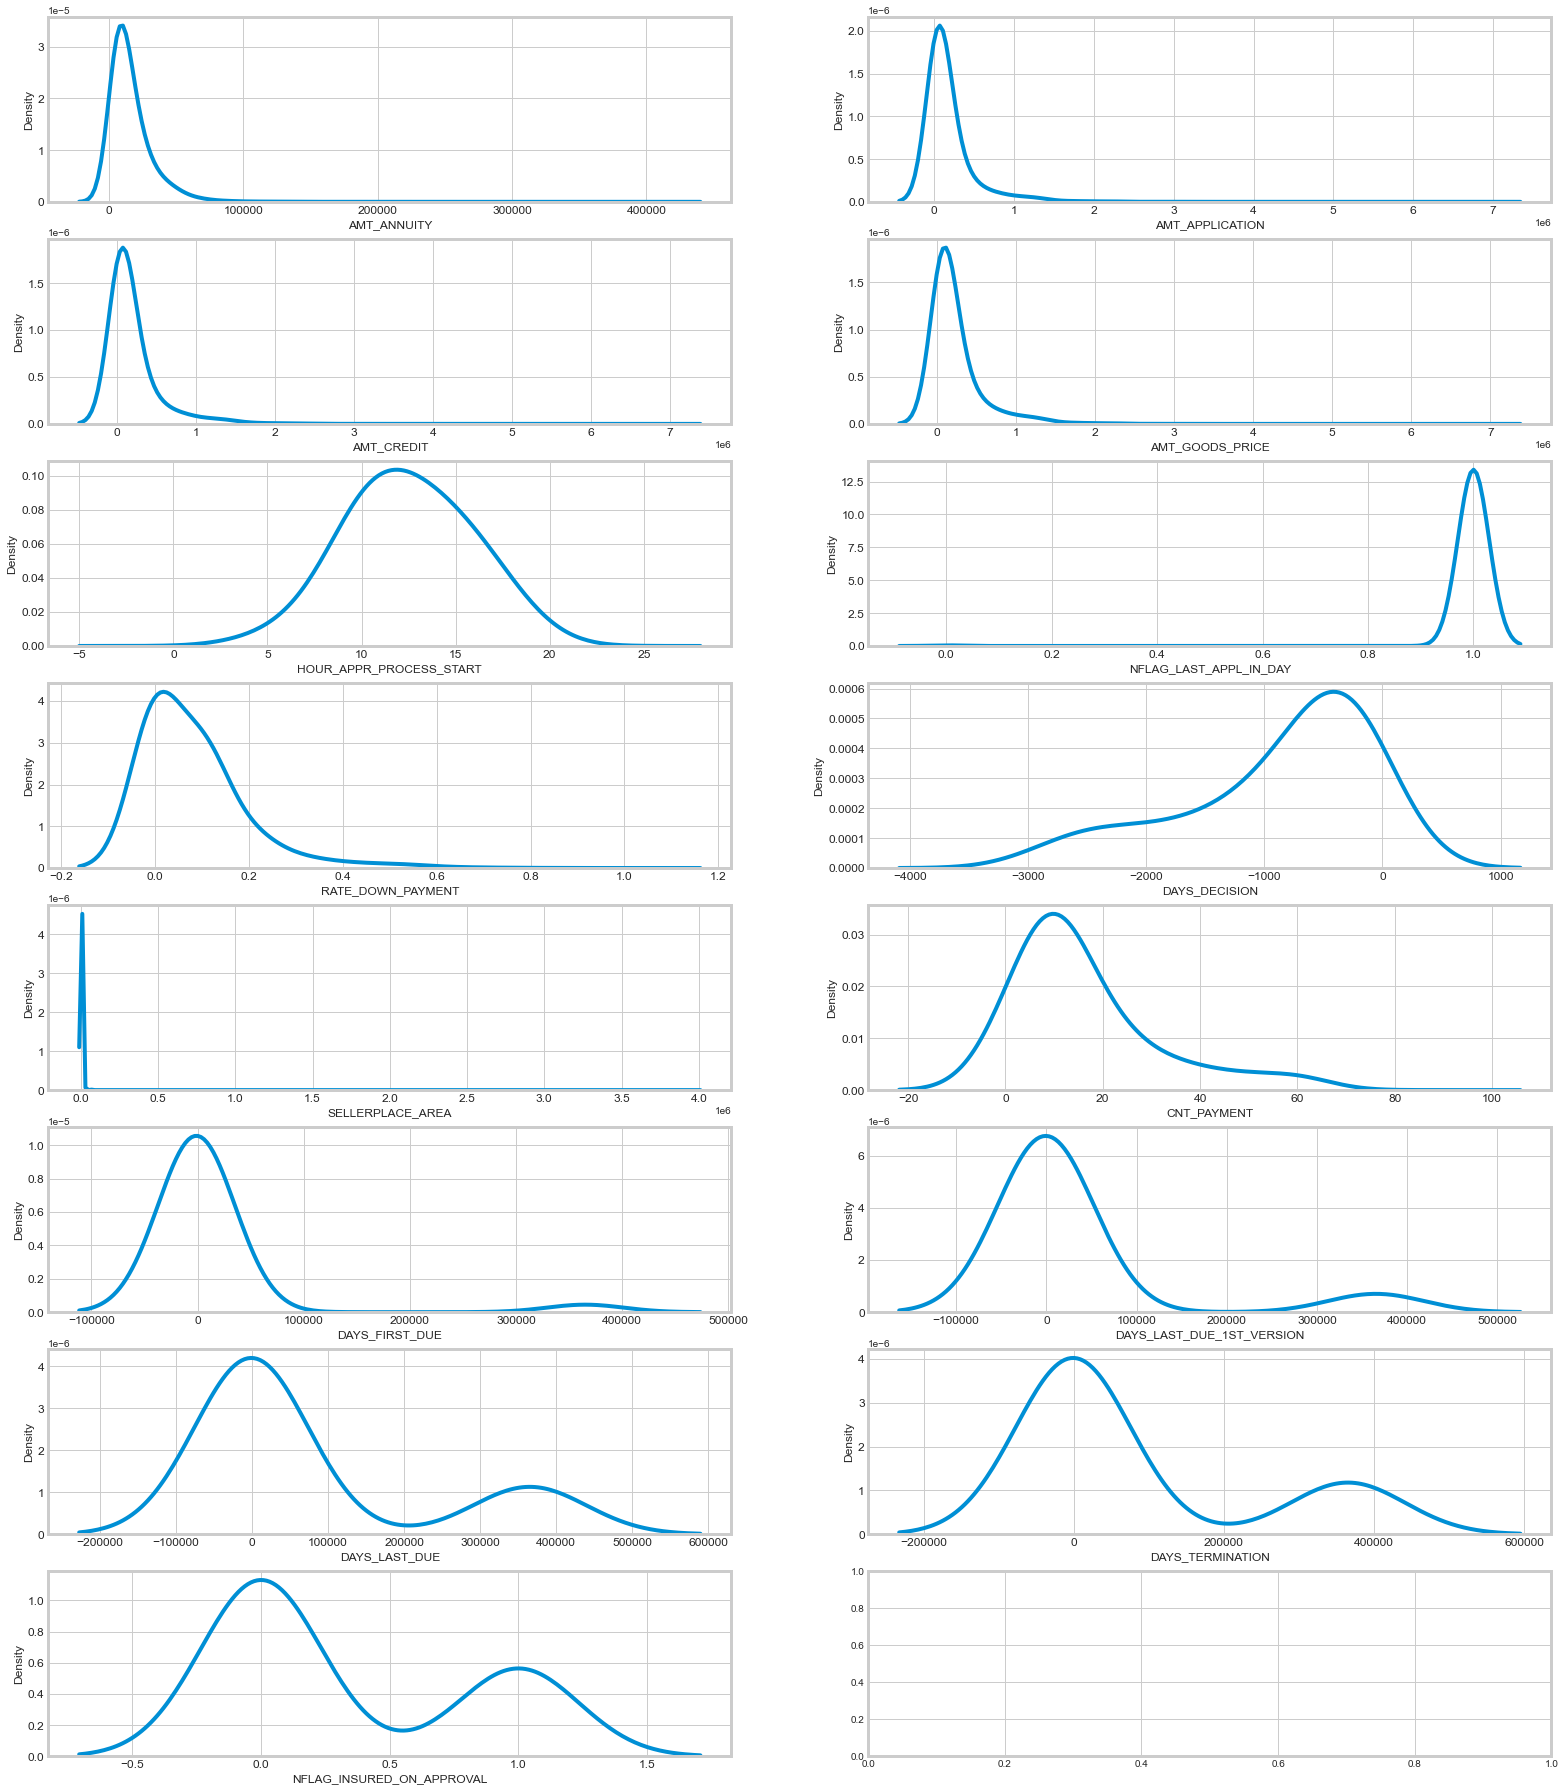

In [97]:
disp_dist(df_prev_app, collist,8)

<Figure size 432x288 with 0 Axes>

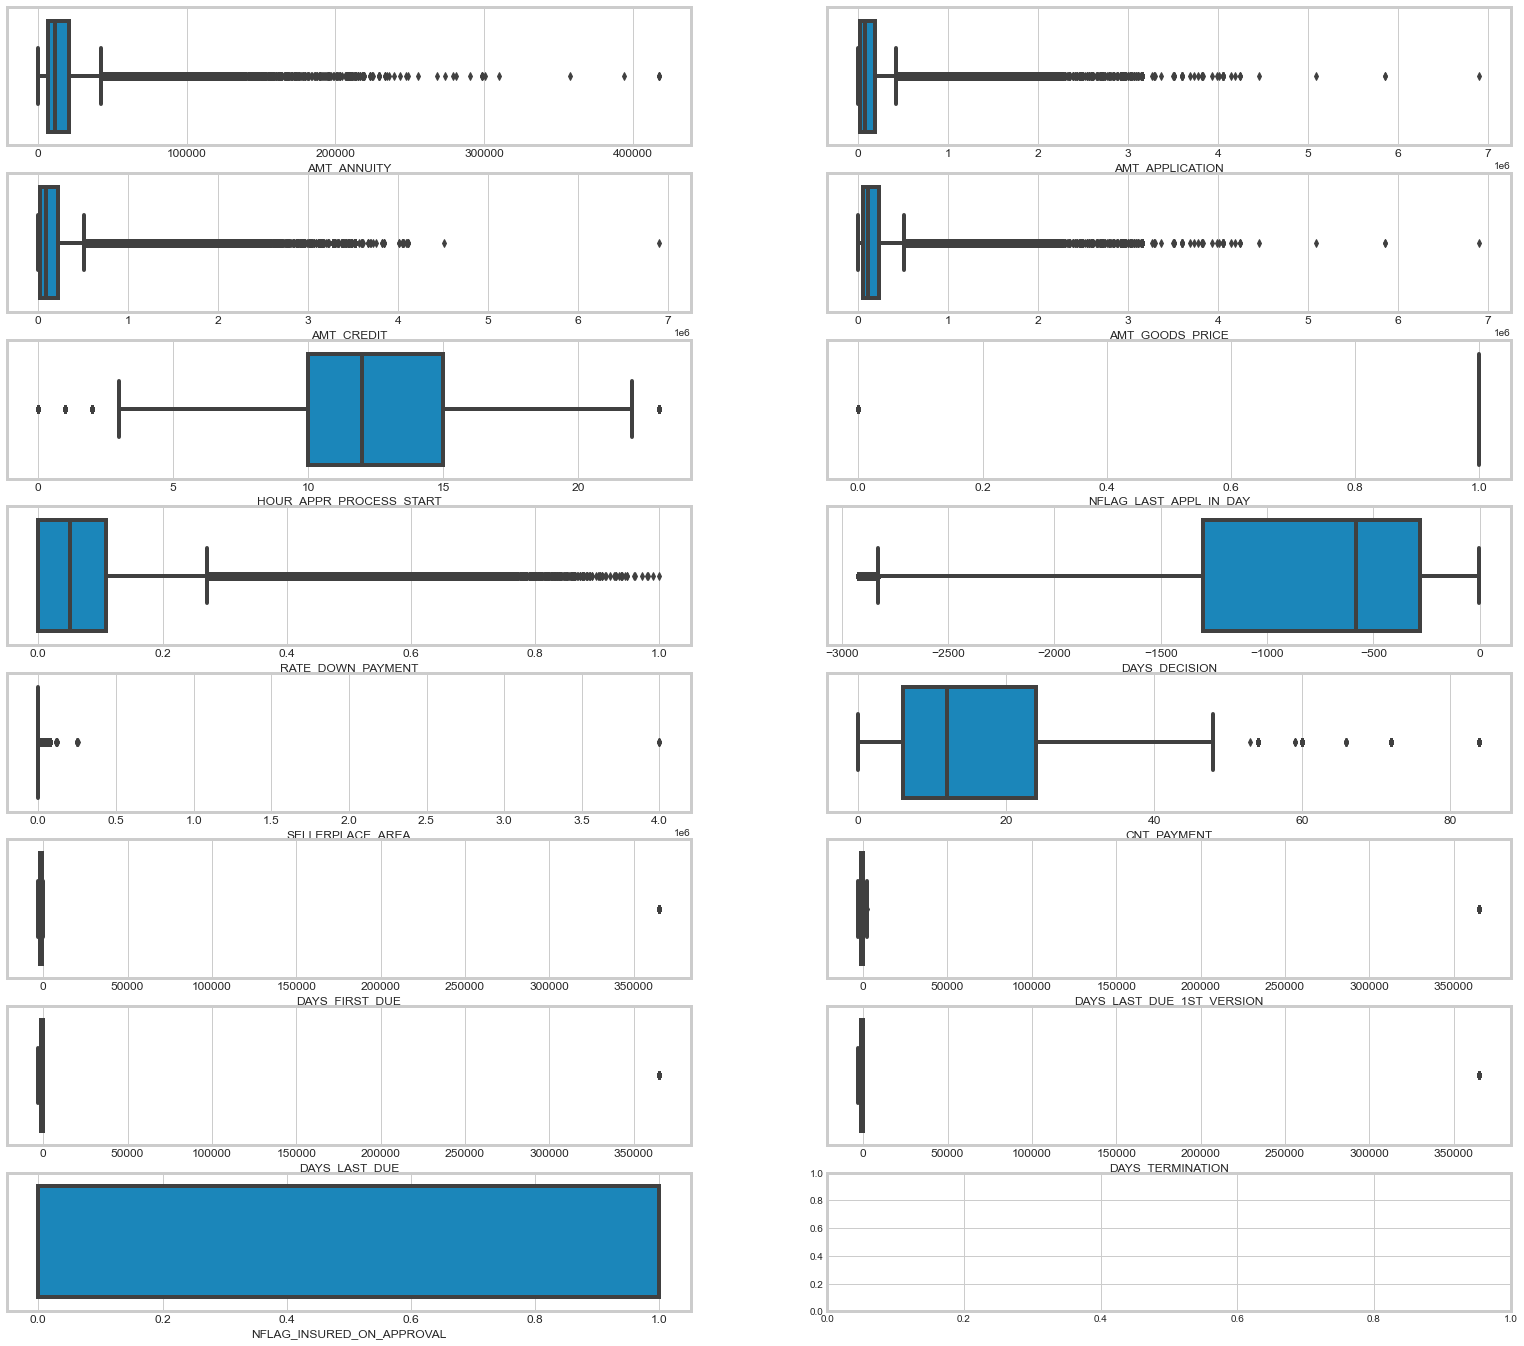

In [98]:
disp_box(df_prev_app, collist,8)

#### TREAT MISSING VALUES, OUTLIER AND ANOMALIES

In [99]:
df_prev_app = treat_missing_values_prev_app(df_prev_app)

#### AFTER TREATMENT

<Figure size 432x288 with 0 Axes>

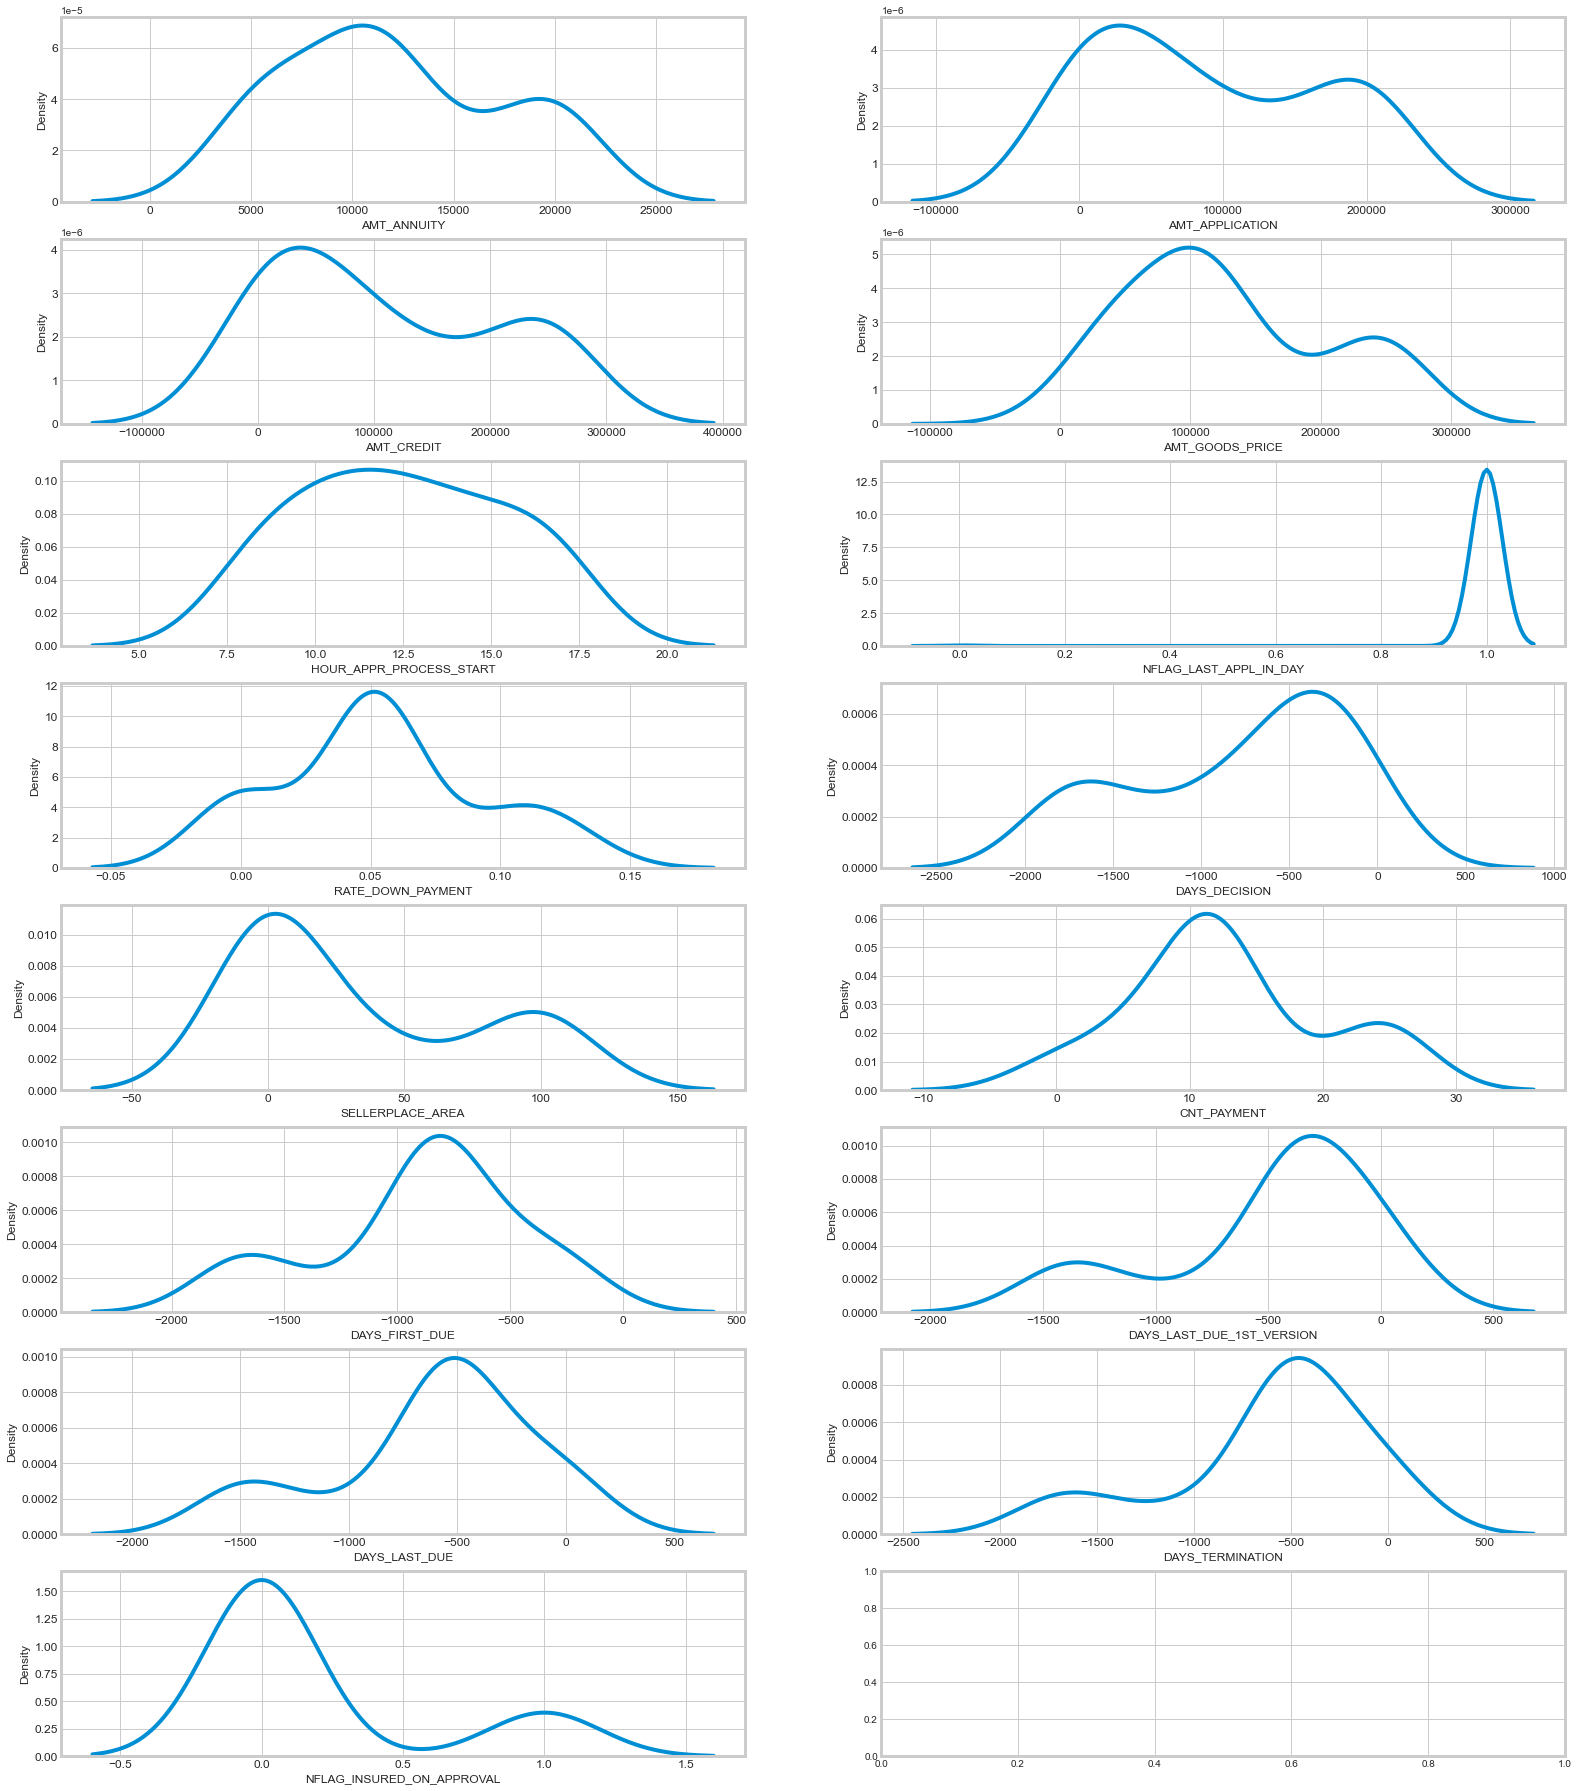

In [100]:
disp_dist(df_prev_app, collist,8)

<Figure size 432x288 with 0 Axes>

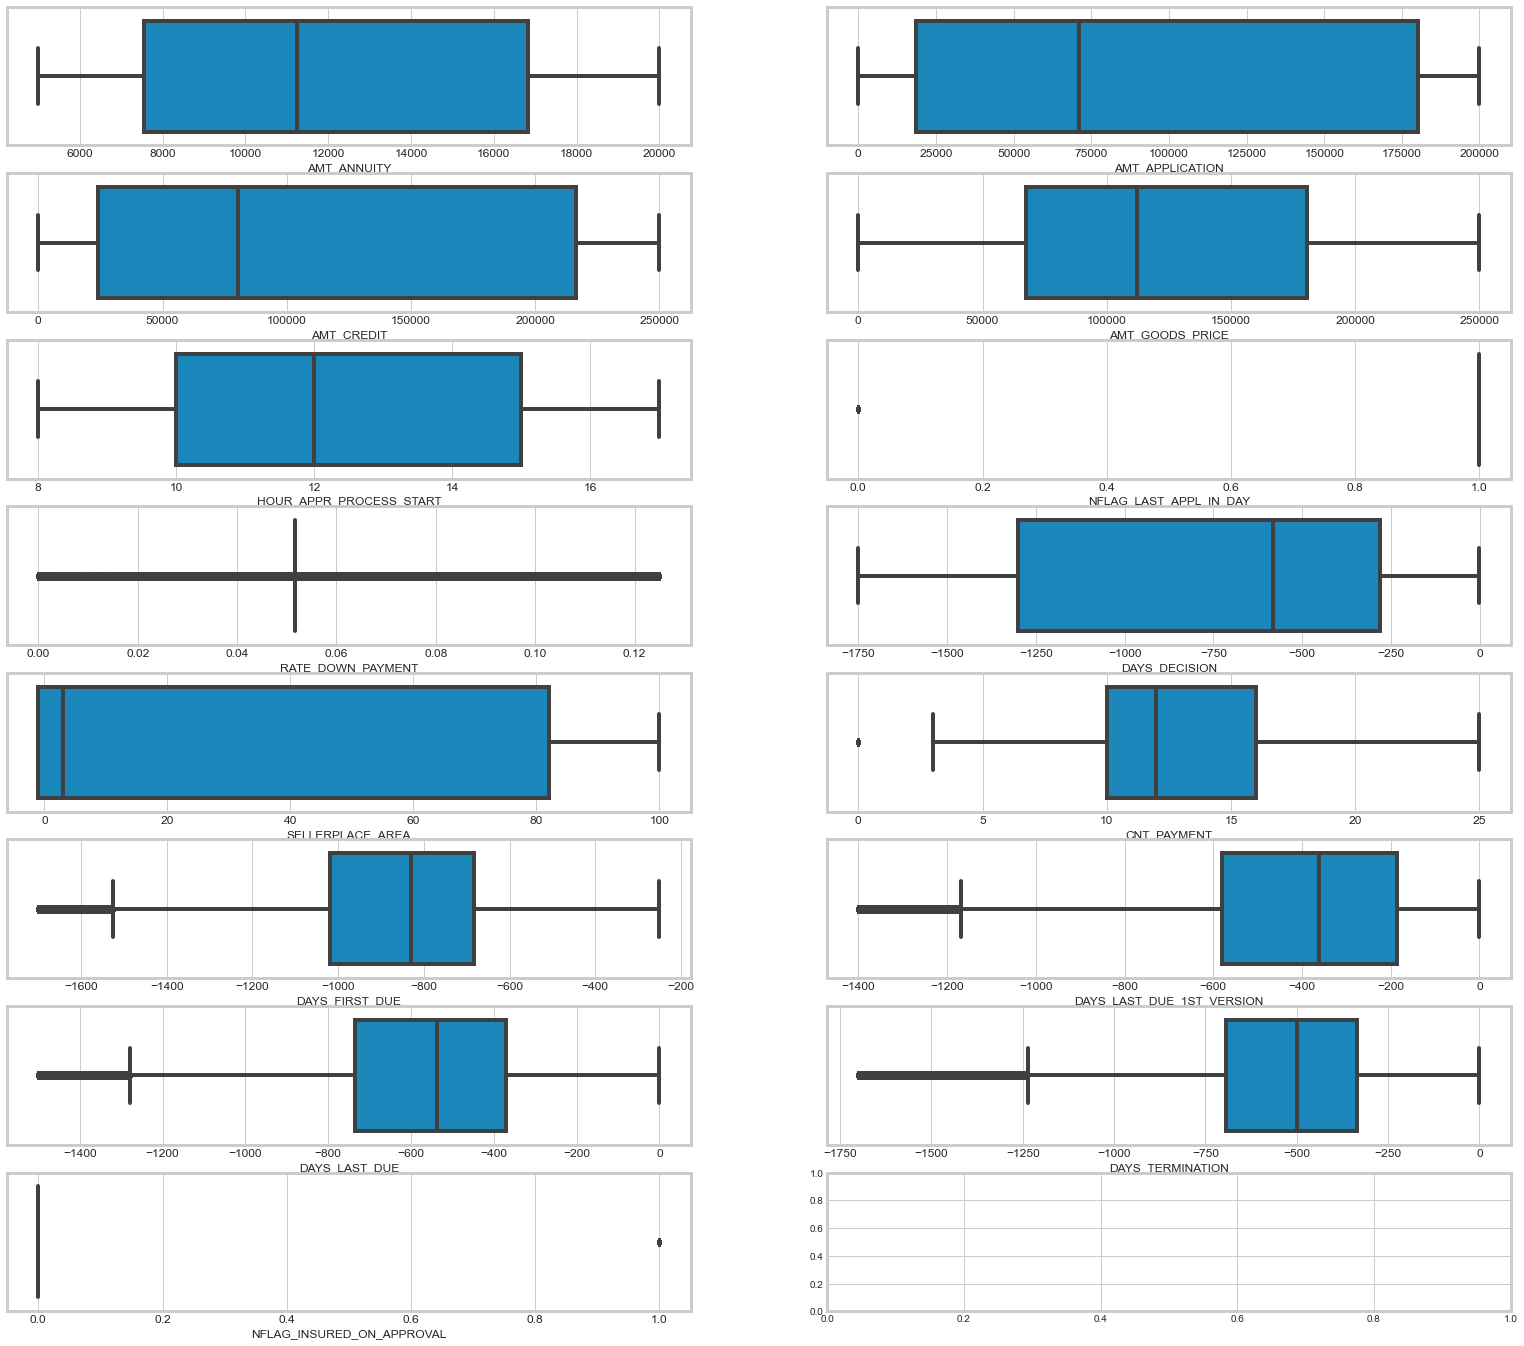

In [101]:
disp_box(df_prev_app, collist,8)

#### ADD TARGET TO PREV APPLICATION

In [213]:
df_target = app_train[['SK_ID_CURR','TARGET']]
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   SK_ID_CURR  307511 non-null  int64
 1   TARGET      307511 non-null  int64
dtypes: int64(2)
memory usage: 4.7 MB


In [214]:
df_prev_app = df_prev_app.merge(right=df_target.reset_index(), how='left', on='SK_ID_CURR')
coldrop = ['index']
df_prev_app.drop(coldrop, axis = 1, inplace=True)

In [215]:
del df_target
gc.collect()

46866

In [216]:
# Preprocess previous_applications.csv
#def previous_applications(df_prev_app, num_rows = None, nan_as_category = True):
nan_as_category = True
prev = df_prev_app
del df_prev_app
gc.collect()
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)

# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
# Previous Applications: Approved Applications - only numerical features
# approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
# approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
# approved_agg.columns = pd.Index(['APR_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
# prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
# # Previous Applications: Refused Applications - only numerical features
# refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
# refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
# refused_agg.columns = pd.Index(['REF_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
# prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
#del refused, refused_agg, approved, approved_agg, prev

gc.collect()
#return prev_agg

0

In [217]:
#prev = previous_applications(df_prev_app, num_rows)
print("Previous applications df shape:", prev_agg.shape)
fill_missing_columns(prev_agg)
find_missing_columns(prev_agg)
app_train = app_train.join(prev_agg, how='left', on='SK_ID_CURR')
fill_missing_columns_other_than_target(app_train)
find_missing_columns(app_train)

del prev_agg
gc.collect()

Previous applications df shape: (338857, 42)


0

46876

# POS_CASH_BALANCE DATASET

#### LOAD DATASET

In [103]:
dataset_path = 'POS_CASH_balance.csv'
df_pos_cash_bal = pd.read_csv(dataset_path, parse_dates=True, keep_date_col=True)
print('POS Balance Dataset shape: ', df_pos_cash_bal.shape)


POS Balance Dataset shape:  (10001358, 8)


#### FEATURE ELIMINATION

In [104]:
remove_columns_pos_cash_bal(df_pos_cash_bal)

#### DATA ANALYSIS BEFORE TREATMENT 

In [105]:
collist = []
for col in df_pos_cash_bal.columns:
    if str(df_pos_cash_bal[col].dtype) not in ("object"):
        collist.append(col)
collist.remove('SK_ID_PREV')        
collist.remove('SK_ID_CURR')  
collist

['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']

<Figure size 432x288 with 0 Axes>

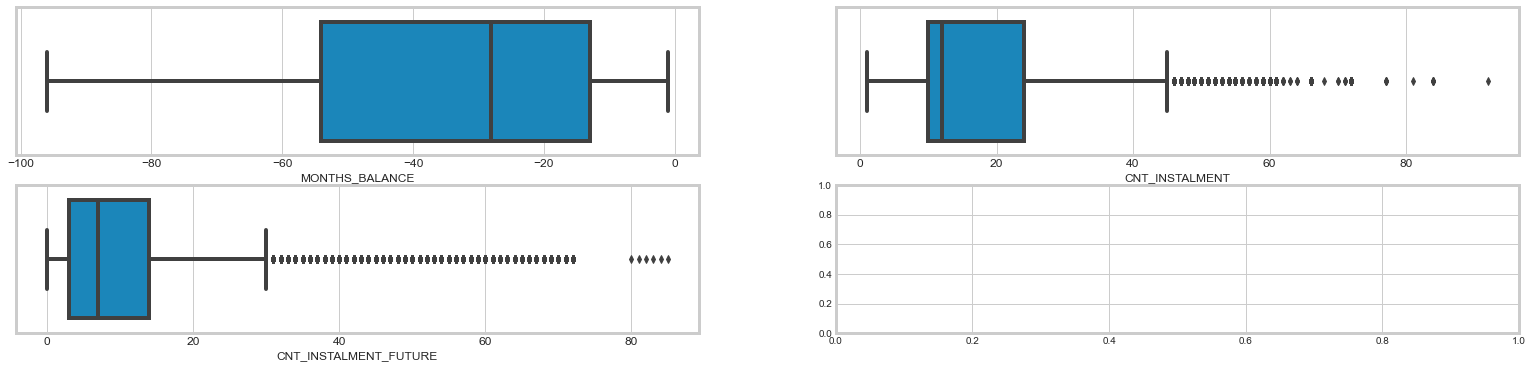

In [106]:
disp_box(df_pos_cash_bal, collist,2)

<Figure size 432x288 with 0 Axes>

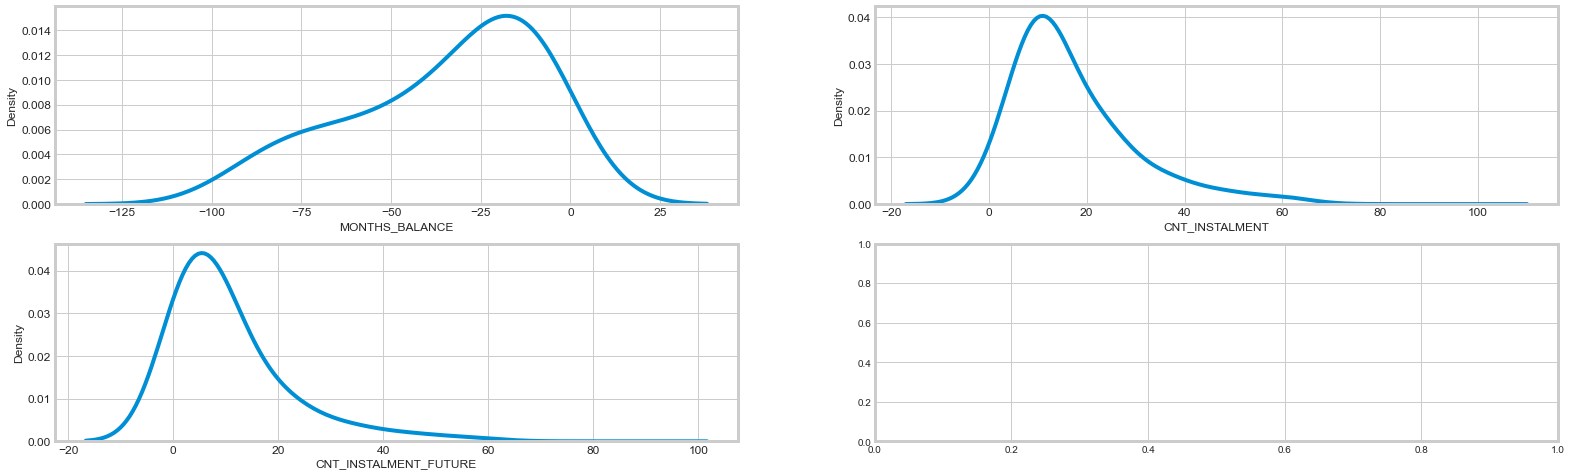

In [107]:
disp_dist(df_pos_cash_bal, collist,2)

#### TREAT FOR OUTLIER, MISSING VALUES AND ANOMALIES

In [108]:
df_pos_cash_bal = treat_missing_values_pos_cash_bal(df_pos_cash_bal)

#### AFTER TREATMENT

<Figure size 432x288 with 0 Axes>

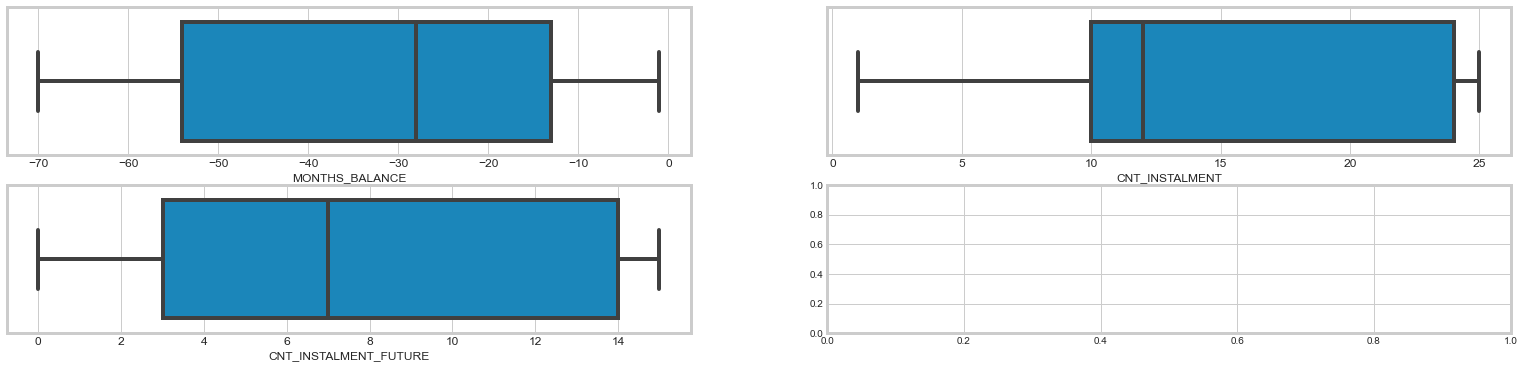

In [109]:
disp_box(df_pos_cash_bal, collist,2)

<Figure size 432x288 with 0 Axes>

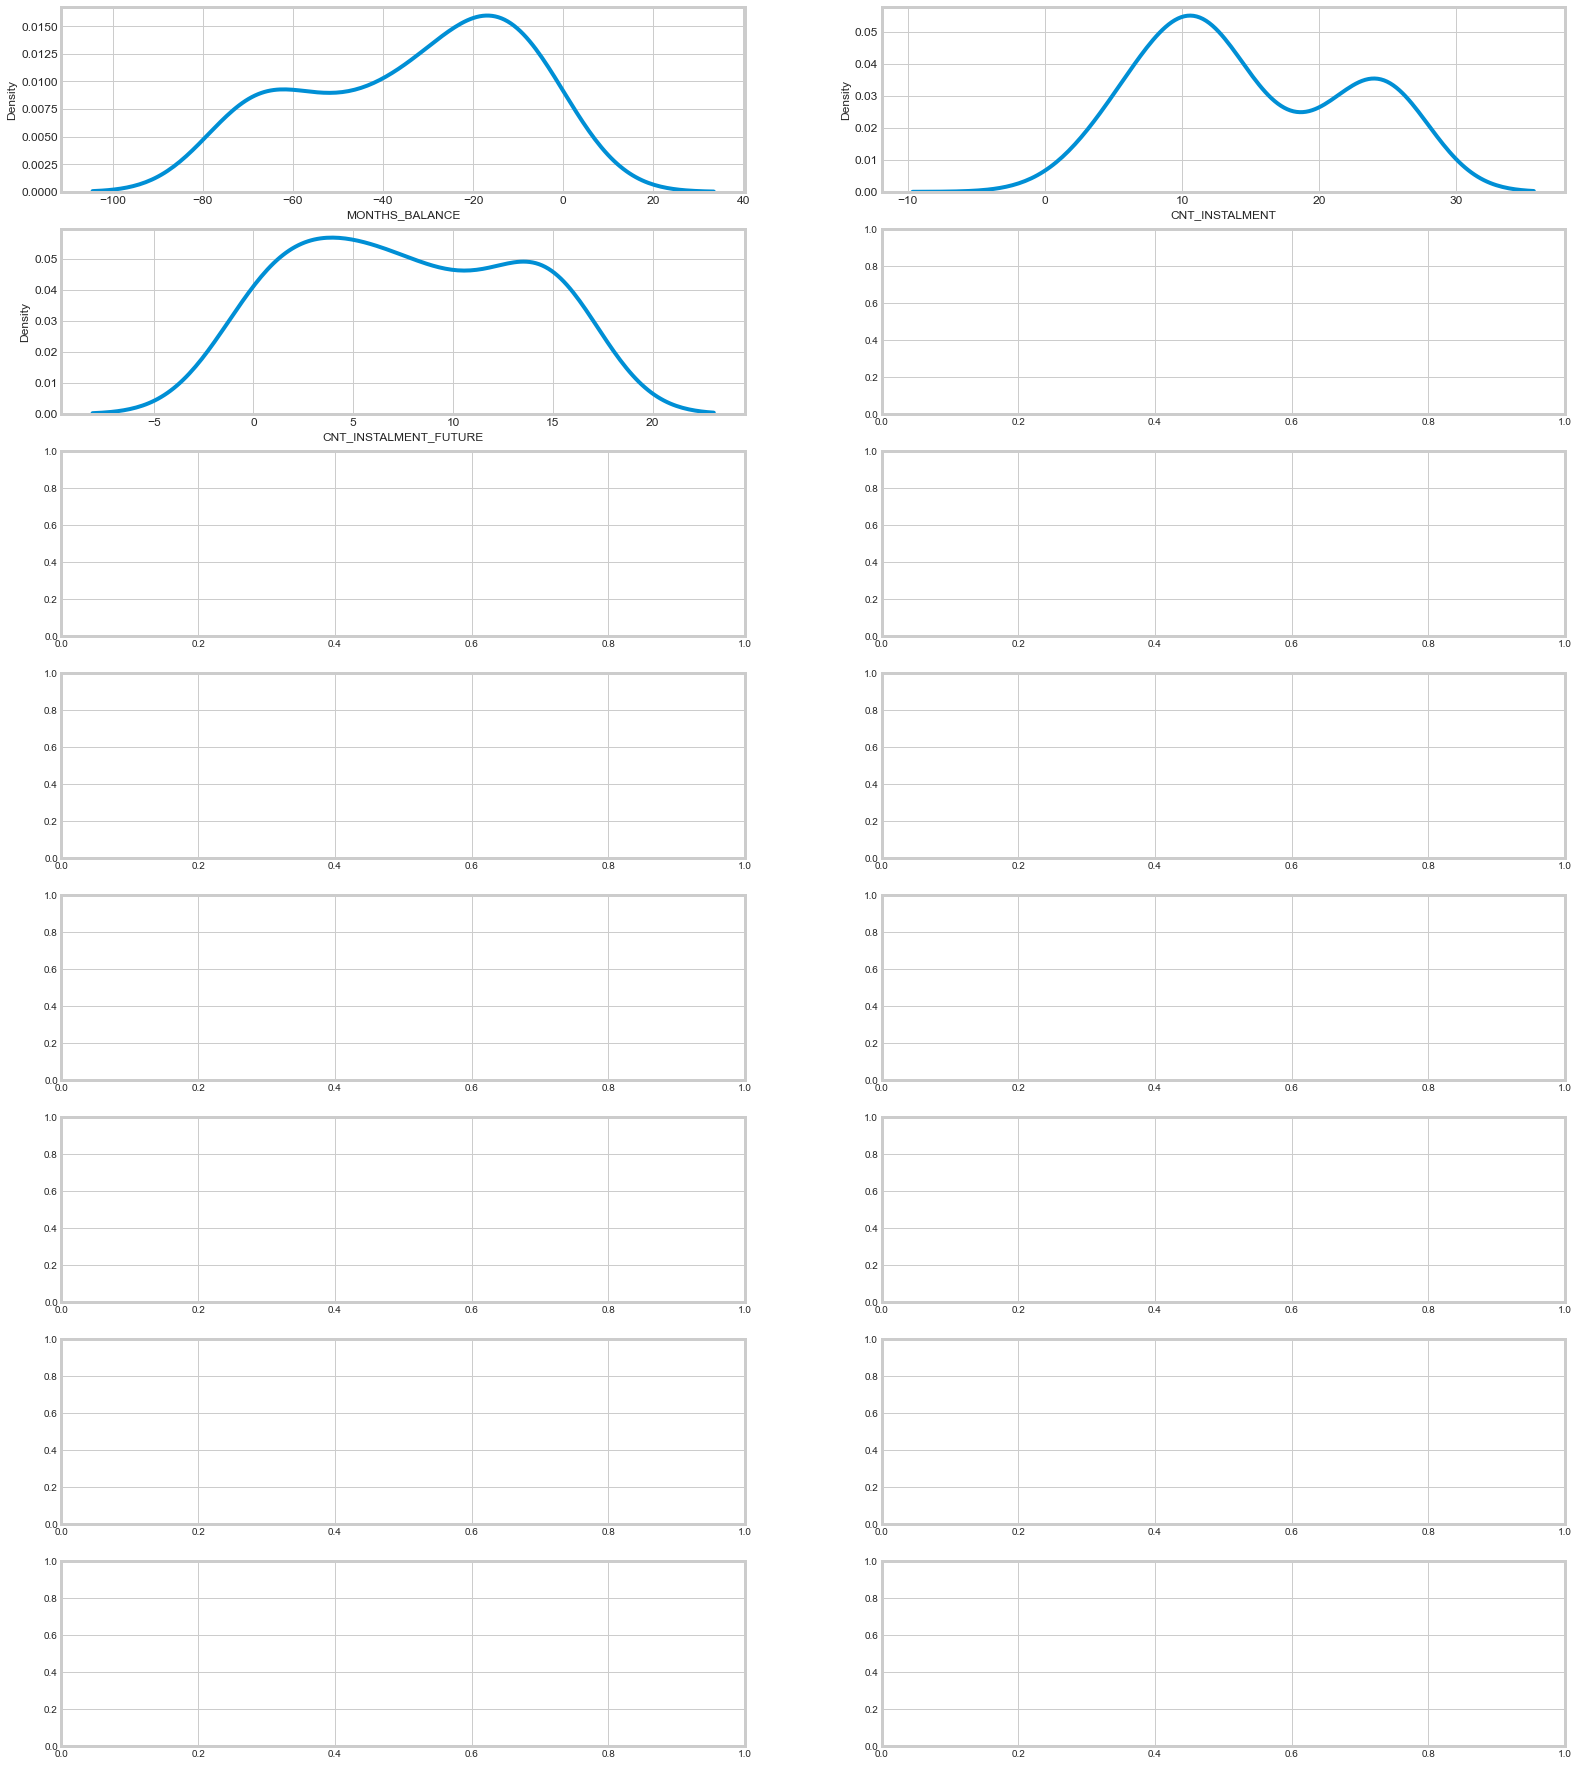

In [110]:
disp_dist(df_pos_cash_bal, collist,8)

#### ADD TARGET

In [226]:
df_target = app_train[['SK_ID_CURR','TARGET']]
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   SK_ID_CURR  307511 non-null  int64
 1   TARGET      307511 non-null  int64
dtypes: int64(2)
memory usage: 4.7 MB


In [227]:
df_pos_cash_bal = df_pos_cash_bal.merge(right=df_target.reset_index(), how='left', on='SK_ID_CURR')
coldrop = ['index']
df_pos_cash_bal.drop(coldrop, axis = 1, inplace=True)

In [228]:
del df_target
gc.collect()

40902

In [229]:
# Preprocess POS_CASH_balance.csv
#def pos_cash(df_pos_cash_bal, num_rows = None, nan_as_category = True):
nan_as_category = True
pos = df_pos_cash_bal
del df_pos_cash_bal
gc.collect()
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
del pos
gc.collect()
#return pos_agg

0

In [230]:
#pos = pos_cash(df_pos_cash_bal, num_rows)
print("Pos-cash balance df shape:", pos_agg.shape)
fill_missing_columns(pos_agg)
find_missing_columns(pos_agg)
app_train = app_train.join(pos_agg, how='left', on='SK_ID_CURR')
fill_missing_columns_other_than_target(app_train)
find_missing_columns(app_train)

del pos_agg
gc.collect()


Pos-cash balance df shape: (337252, 5)


0

40763

# INSTALLMENT BALANCE

In [231]:
#### LOAD DATASETS

In [112]:
dataset_path = 'installments_payments.csv'
df_inst_pay = pd.read_csv(dataset_path, parse_dates=True, keep_date_col=True)

print('Installments Payments data shape: ', df_inst_pay.shape)

Installments Payments data shape:  (13605401, 8)


#### NO FEATURE ELIMINATION ON THIS ONE 

#### ANALYSIS BEFORE TREATMENT

In [113]:
collist = []
for col in df_inst_pay.columns:
    if str(df_inst_pay[col].dtype) not in ("object"):
        collist.append(col)
collist.remove('SK_ID_PREV')        
collist.remove('SK_ID_CURR')  
collist

['NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_INSTALMENT',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT']

<Figure size 432x288 with 0 Axes>

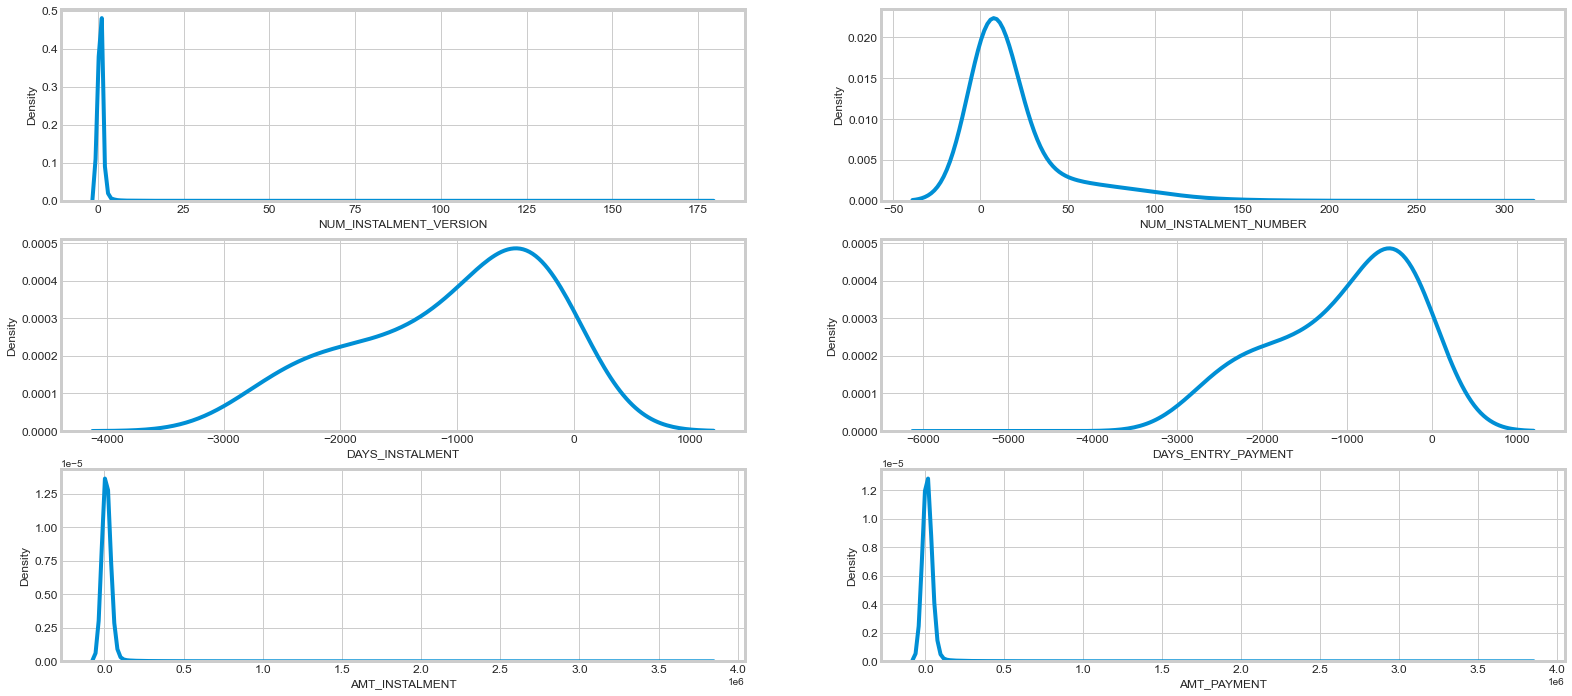

In [114]:
disp_dist(df_inst_pay, collist,3)

<Figure size 432x288 with 0 Axes>

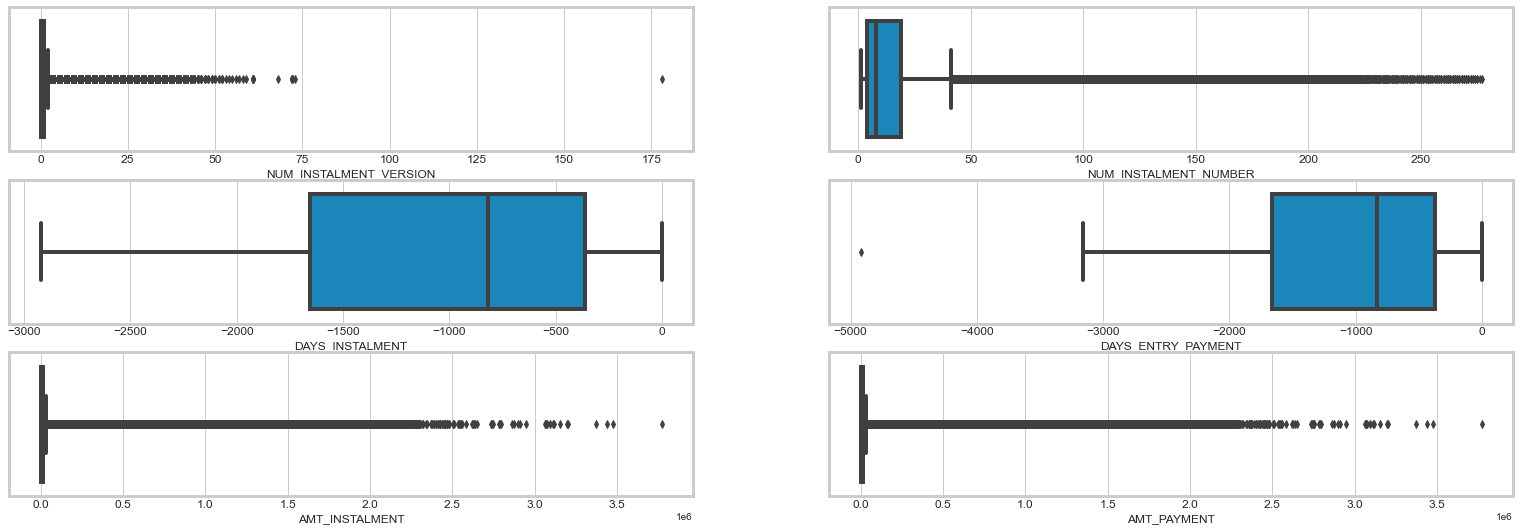

In [115]:
disp_box(df_inst_pay, collist,3)

In [237]:
#### TREAT FOR OUTLIER, MISSING VALUES AND ANOMALIES

In [116]:
df_inst_pay = treat_missing_values_inst_pay(df_inst_pay)

In [239]:
#### ANALYSIS AFTER TREATMENT 

<Figure size 432x288 with 0 Axes>

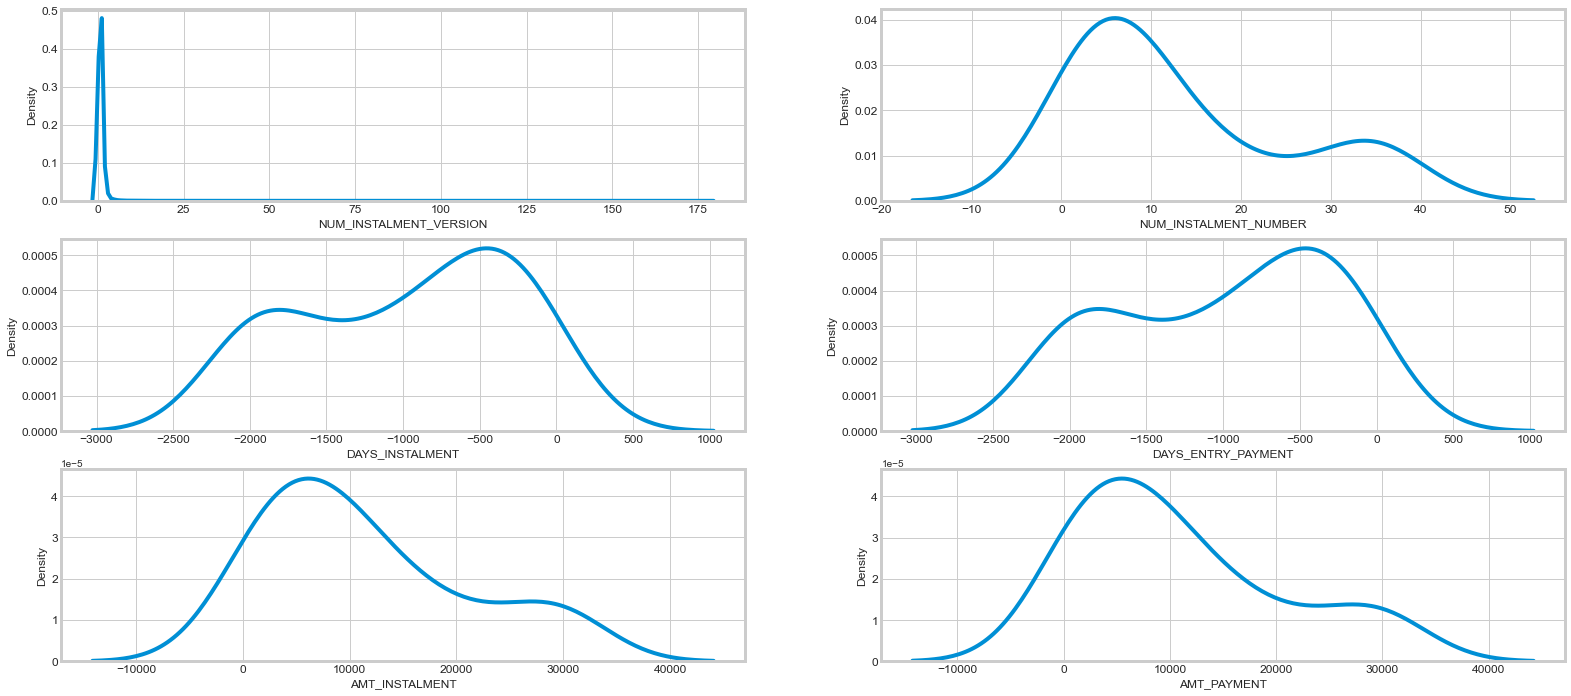

In [117]:
disp_dist(df_inst_pay, collist,3)

<Figure size 432x288 with 0 Axes>

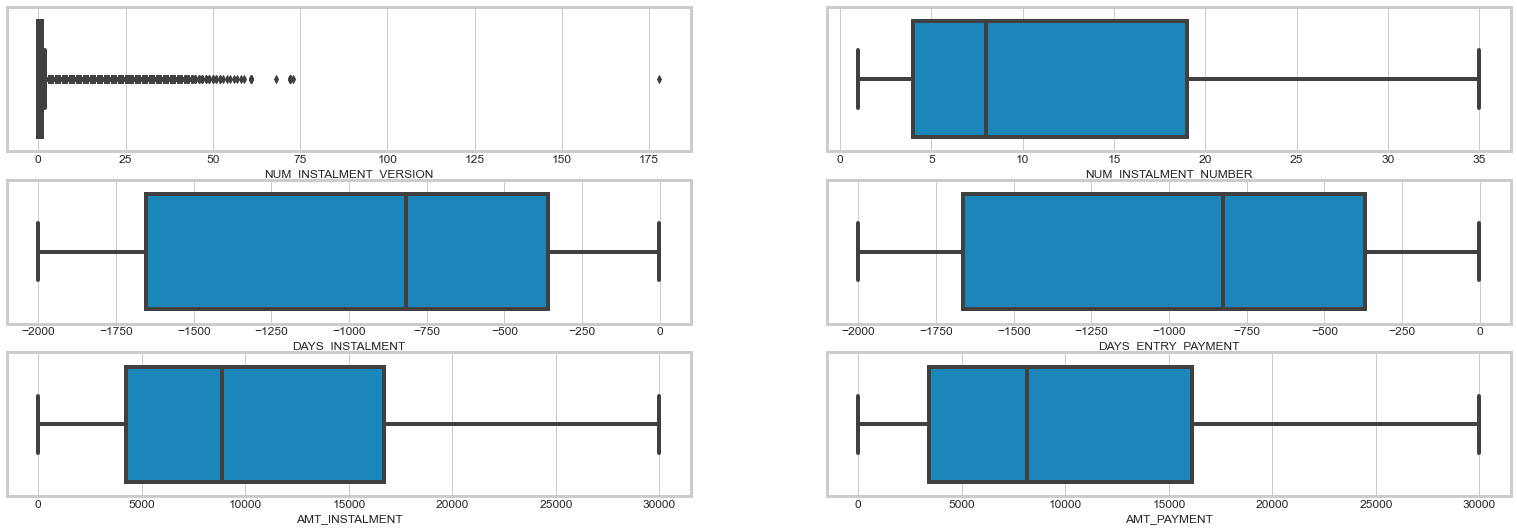

In [118]:
disp_box(df_inst_pay, collist,3)

In [242]:
# Preprocess installments_payments.csv
#def installments_payments(df_inst_pay, num_rows = None, nan_as_category = True):
nan_as_category = True
ins = df_inst_pay
del df_inst_pay
gc.collect()
ins, cat_cols = old_one_hot_encoder(ins, nan_as_category= True)
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()
del ins
gc.collect()
#return ins_agg

13

In [243]:
#pos = pos_cash(df_pos_cash_bal, num_rows)
print("Installment Payment df shape:", ins_agg.shape)
fill_missing_columns(ins_agg)
find_missing_columns(ins_agg)
app_train = app_train.join(ins_agg, how='left', on='SK_ID_CURR')
fill_missing_columns_other_than_target(app_train)
find_missing_columns(app_train)

del ins_agg
gc.collect()


Installment Payment df shape: (339587, 26)


0

# CREDIT CARD BALANCE

#### LOAD DATASET

In [ ]:
# Dataset_path = 'credit_card_balance.csv'
# df_cc_bal = pd.read_csv(dataset_path, parse_dates=True, keep_date_col=True)
# print('Credit Card dataset shape: ', df_cc_bal.shape)

#### FEATURE ELIMINATION

In [ ]:
# remove_columns_cc_bal(df_cc_bal)

#### DATA ANALYSIS BEFORE TREATMENT

In [ ]:
# collist = get_collist(df_cc_bal)
# collist.remove('SK_ID_PREV')        
# collist

In [ ]:
# disp_dist(df_cc_bal, collist,8)

#### TREAT FOR OUTLIER, MISSING VALUE AND ANOMALY

In [ ]:
# df_cc_bal = treat_missing_values_cc_bal(df_cc_bal)

#### DATA ANALYSIS AFTER TREATMENT 

In [ ]:
# disp_dist(df_cc_bal, collist,8)

#### ADD TARGET 

In [ ]:
# df_target = app_train[['SK_ID_CURR','TARGET']]
# df_target.info()

In [ ]:
# df_cc_bal = df_cc_bal.merge(right=df_target.reset_index(), how='left', on='SK_ID_CURR')
# coldrop = ['index']
# df_cc_bal.drop(coldrop, axis = 1, inplace=True)

In [ ]:
# del df_target
# gc.collect()

In [ ]:

# # Preprocess credit_card_balance.csv
# #def credit_card_balance(df_cc_bal, num_rows = None, nan_as_category = True):
# nan_as_category = True
# cc = df_cc_bal
# del df_cc_bal
# gc.collect()
# cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
# # General aggregations
# cc.drop(columns = ['SK_ID_PREV'], inplace = True)
# cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
# cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# # Count credit card lines
# cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
# del cc
# gc.collect()
# #return cc_agg

In [ ]:
# print("Credit Card df shape:", cc_agg.shape)
# fill_missing_columns(cc_agg)
# find_missing_columns(cc_agg)
# app_train = app_train.join(cc_agg, how='left', on='SK_ID_CURR')
# fill_missing_columns_other_than_target(app_train)
# find_missing_columns(app_train)

# del cc_agg
# gc.collect()

In [ ]:
print('Current Loans Train dataset shape: ',app_train.shape)

In [34]:
#GOOD EDA LINK 
#https://github.com/rakshithvasudev/Home-Credit-Default-Risk/blob/master/EDA/Exploratory%20Data%20Analysis%20-%20Application%20Train.ipynb

In [35]:
# plt.figure(figsize=(12,10))
# sns.boxplot(x='OCCUPATION_TYPE',y='AMT_CREDIT',data=app_train,hue='CODE_GENDER')
# plt.xticks(rotation=70)

In [244]:
find_missing_columns(app_train)

In [245]:
app_train.shape

(307511, 167)

In [246]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 167 entries, SK_ID_CURR to INS_COUNT
dtypes: float64(142), int32(6), int64(19)
memory usage: 384.8 MB


In [247]:
app_train.to_csv("app_train_all_df_merged3NOV.csv")

In [262]:
# dataset_path = 'app_train_all_df_merged3NOV.csv'
# app_train = pd.read_csv(dataset_path, parse_dates=True, keep_date_col=True)
# print(' Train data shape: ', app_train.shape)

 Train data shape:  (307511, 168)


In [263]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')

### Splitting into train and test set

In [264]:
np.random.seed(0)


In [265]:
df_train, df_test = train_test_split(app_train, train_size = 0.7, test_size = 0.3, random_state = 100)

In [266]:
app_train.to_csv("3NOVtrain_alldataset.csv")

In [267]:
df_test.to_csv("3NOVtest_alldataset.csv")

In [268]:
del app_train, df_train, df_test
gc.collect()

16

# Load merged dataset and run feature importance tests 

In [269]:
dataset_path = '3NOVtrain_alldataset.csv'
train = pd.read_csv(dataset_path, parse_dates=True, keep_date_col=True)
print(' Train data shape: ', train.shape)

dataset_path = '3NOVtest_alldataset.csv'
test = pd.read_csv(dataset_path, parse_dates=True, keep_date_col=True)
print(' Test dataset shape: ',test.shape)


 Train data shape:  (307511, 169)
 Test dataset shape:  (92254, 169)


# APPLY CLASS IMBALANCE TECHNIQUE

In [166]:
#test_subset = test.iloc[10000:40000,:]
test_subset = test

In [167]:
#train_wo_imbalance = train.iloc[0:200000,:]
train_wo_imbalance = train


In [168]:
train_wo_imbalance = train_wo_imbalance[~train_wo_imbalance.isin([np.nan, np.inf, -np.inf]).any(1)]

In [122]:
# columns = train_wo_imbalance.columns.tolist()
# train_wo_imbalance.reindex(columns=columns)

In [169]:
train_imbalanced = run_method(apply_sm_tomek_sampling, train_wo_imbalance, 'TARGET')

Before run size majority:197728, minority:17299
After run size majority:197231, minority:197231


In [170]:
# train_imbalanced.to_csv("30OCTtrain_sm_tomek_balanced.csv")

In [171]:
del train, test, train_wo_imbalance
gc.collect()

0

# FIND FEATURE IMPORTANCE USING LIGHTGBM AND KFOLD CROSS VALIDATION

In [178]:
o_submission = pd.DataFrame()
o_feature_importances = pd.DataFrame()
o_metrics = pd.DataFrame()

Training Data Shape:  (394462, 166)
Testing Data Shape:  (92254, 166)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	train's auc: 0.984732	train's binary_logloss: 0.156855	valid's auc: 0.726067	valid's binary_logloss: 0.282648
[400]	train's auc: 0.986947	train's binary_logloss: 0.114007	valid's auc: 0.748589	valid's binary_logloss: 0.249499
[600]	train's auc: 0.988649	train's binary_logloss: 0.10447	valid's auc: 0.761126	valid's binary_logloss: 0.243967
[800]	train's auc: 0.990047	train's binary_logloss: 0.0989935	valid's auc: 0.767245	valid's binary_logloss: 0.24165
[1000]	train's auc: 0.991238	train's binary_logloss: 0.0948653	valid's auc: 0.77028	valid's binary_logloss: 0.24054
[1200]	train's auc: 0.992252	train's binary_logloss: 0.0913639	valid's auc: 0.772257	valid's binary_logloss: 0.239838
[1400]	train's auc: 0.993177	train's binary_logloss: 0.0880586	valid's auc: 0.773462	valid's binary_logloss: 0.239376
[1

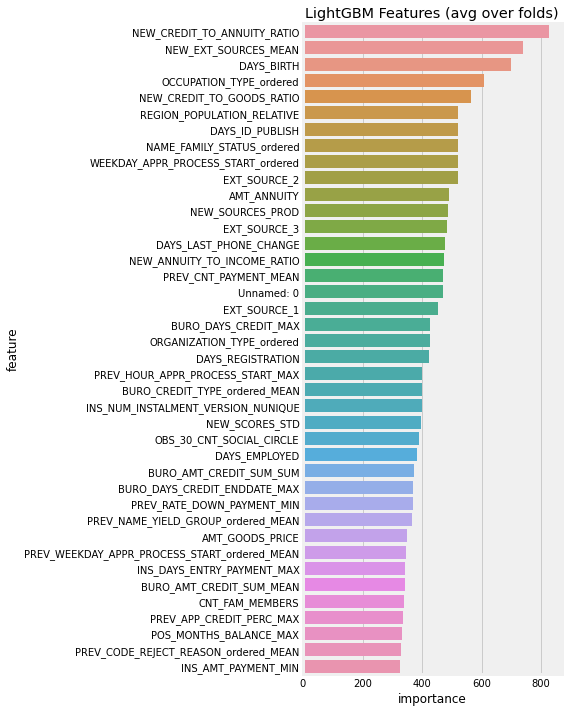

In [179]:
 o_submission, o_feature_importances, o_metrics = model(train_imbalanced, test_subset)
 display_importances(o_feature_importances)

In [183]:
o_feature_importances.to_csv("30OCTfeat_imp_all_data.csv")

### SELECT COLUMNS WITH FEATURE IMPORTANCES FOR FEATURE SELECTION

In [ ]:
train_imbalanced.drop(coldrop, axis = 1, inplace=True)

In [190]:
coldrop = ['BURO_CREDIT_ACTIVE_ordered_MEAN','PREV_AMT_GOODS_PRICE_MIN','PREV_HOUR_APPR_PROCESS_START_MEAN','PREV_CHANNEL_TYPE_ordered_MEAN','POS_MONTHS_BALANCE_SIZE','PREV_AMT_ANNUITY_MEAN','PREV_APP_CREDIT_PERC_MIN','BURO_AMT_CREDIT_SUM_DEBT_SUM','BURO_DAYS_CREDIT_VAR','BURO_DAYS_CREDIT_ENDDATE_MIN','PREV_NAME_CLIENT_TYPE_ordered_MEAN','PREV_NAME_PAYMENT_TYPE_ordered_MEAN','PREV_CNT_PAYMENT_SUM','PREV_DAYS_DECISION_MEAN','INS_DAYS_ENTRY_PAYMENT_SUM','PREV_NAME_GOODS_CATEGORY_ordered_MEAN','PREV_NAME_PRODUCT_TYPE_ordered_MEAN','BURO_STATUS_0_MEAN_MEAN','BURO_DAYS_CREDIT_MEAN','BURO_DAYS_CREDIT_MIN','AMT_REQ_CREDIT_BUREAU_YEAR','POS_MONTHS_BALANCE_MEAN','INS_AMT_INSTALMENT_MEAN','PREV_DAYS_DECISION_MIN','BURO_AMT_CREDIT_SUM_DEBT_MEAN','NAME_HOUSING_TYPE_ordered','PREV_AMT_ANNUITY_MIN','PREV_AMT_CREDIT_MIN','BURO_AMT_CREDIT_SUM_MAX','BURO_DAYS_CREDIT_UPDATE_MEAN','PREV_AMT_CREDIT_MEAN','OBS_60_CNT_SOCIAL_CIRCLE','INS_AMT_INSTALMENT_SUM','PREV_AMT_GOODS_PRICE_MEAN','PREV_AMT_APPLICATION_MEAN','INS_PAYMENT_DIFF_SUM','CODE_GENDER','INS_PAYMENT_DIFF_MAX','INS_PAYMENT_DIFF_MEAN','BURO_MONTHS_BALANCE_SIZE_MEAN','BURO_DAYS_CREDIT_UPDATE_MIN','PREV_NAME_PORTFOLIO_ordered_MEAN','BURO_STATUS_X_MEAN_MEAN','INS_PAYMENT_PERC_SUM','INS_PAYMENT_DIFF_VAR','PREV_NAME_CASH_LOAN_PURPOSE_ordered_MEAN','INS_PAYMENT_PERC_VAR','INS_DPD_SUM','PREV_AMT_APPLICATION_MIN','BURO_STATUS_C_MEAN_MEAN','INS_PAYMENT_PERC_MEAN','INS_COUNT','PREV_NAME_CONTRACT_TYPE_ordered_MEAN','FLAG_EMP_PHONE','PREV_AMT_ANNUITY_MAX','BURO_MONTHS_BALANCE_SIZE_SUM','INS_AMT_PAYMENT_MAX','BURO_MONTHS_BALANCE_MIN_MIN','CNT_CHILDREN','FLAG_OWN_CAR','FLAG_PHONE','INS_AMT_INSTALMENT_MAX','DEF_60_CNT_SOCIAL_CIRCLE','FLAG_DOCUMENT_3','FLAG_WORK_PHONE','PREV_AMT_GOODS_PRICE_MAX','PREV_AMT_CREDIT_MAX','REGION_RATING_CLIENT_W_CITY','FLAG_OWN_REALTY','BURO_STATUS_1_MEAN_MEAN','BURO_AMT_CREDIT_SUM_DEBT_MAX','PREV_AMT_APPLICATION_MAX','INS_PAYMENT_PERC_MAX','REGION_RATING_CLIENT','NAME_CONTRACT_TYPE','REG_CITY_NOT_WORK_CITY','REG_CITY_NOT_LIVE_CITY','FLAG_EMAIL','LIVE_CITY_NOT_WORK_CITY','BURO_STATUS_2_MEAN_MEAN','BURO_CREDIT_CURRENCY_ordered_MEAN','REG_REGION_NOT_WORK_REGION','POS_COUNT','BURO_MONTHS_BALANCE_MAX_MAX','LIVE_REGION_NOT_WORK_REGION','PREV_FLAG_LAST_APPL_PER_CONTRACT_ordered_MEAN','REG_REGION_NOT_LIVE_REGION','BURO_STATUS_4_MEAN_MEAN','BURO_STATUS_5_MEAN_MEAN','BURO_STATUS_3_MEAN_MEAN']
train_imbalanced.drop(coldrop, axis = 1, inplace=True)
test_subset.drop(coldrop, axis = 1, inplace=True)


In [191]:
coldrop2 = ['HOUSETYPE_MODE','EMERGENCYSTATE_MODE','FLAG_MOBIL','FLAG_CONT_MOBILE','BURO_STATUS_nan_MEAN_MEAN']
train_imbalanced.drop(coldrop, axis = 1, inplace=True)
test_subset.drop(coldrop2, axis = 1, inplace=True)

# FEATURE SELECTION

In [192]:
#data = train.head(100000)
data = train_imbalanced

In [193]:
# SEPERATE DATASET INTO TRAIN AND TEST

x_train, x_test, y_train, y_test = train_test_split(
    data.drop(labels=['TARGET'], axis=1),  # drop the target
    data['TARGET'],  # just the target
    test_size=0.3,
    random_state=0)

x_train.shape, x_test.shape

((276123, 72), (118339, 72))

In [194]:
df_step_forward_selection = step_forward_selection_reg(x_train, y_train, k = 30, print_res=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  7.3min finished

[2021-10-30 16:17:33] Features: 1/30 -- score: 0.8009765058381328[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:  3.4min finished

[2021-10-30 16:20:58] Features: 2/30 -- score: 0.8194042210160115[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  3.5min finished

[2021-10-30 16:24:30] Features: 3/30 -- score: 0.8159673040205722[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 19.7min finished

[2021-10-30 21:38:38] Features: 28/30 -- score: 0.7972169530717192[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed: 21.8min finished

[2021-10-30 22:00:24] Features: 29/30 -- score: 0.7965989657210633[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed: 22.4min finished

[2021-10-30 22:22:46] Features: 30/30 -- score: 0.7962198567111174

Index(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'NEW_INC_BY_ORG',
       'NEW_EXT_SOURCES_MEAN', 'NAME_TYPE_SUITE_ordered',
       'NAME_INCOME_TYPE_ordered', 'NAME_EDUCATION_TYPE_ordered',
       'NAME_FAMILY_STATUS_ordered', 'WEEKDAY_APPR_PROCESS_START_ordered',
       'BURO_DAYS_CREDIT_ENDDATE_MAX', 'BURO_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_SUM', 'PREV_APP_CREDIT_PERC_MEAN',
       'PREV_HOUR_APPR_PROCESS_START_MIN', 'PREV_RATE_DOWN_PAYMENT_MIN',
       'INS_NUM_INSTALMENT_VERSION_NUNIQUE', 'INS_DBD_MAX', 'INS_DBD_SUM',
       'INS_AMT_PAYMENT_MIN', 'INS_AMT_PAYMENT_MEAN', 'INS_AMT_PAYMENT_SUM',
       'INS_DAYS_ENTRY_PAYMENT_MEAN'],
      dtype='object')


In [195]:
df_step_forward_selection.columns

Index(['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'NEW_INC_BY_ORG',
       'NEW_EXT_SOURCES_MEAN', 'NAME_TYPE_SUITE_ordered',
       'NAME_INCOME_TYPE_ordered', 'NAME_EDUCATION_TYPE_ordered',
       'NAME_FAMILY_STATUS_ordered', 'WEEKDAY_APPR_PROCESS_START_ordered',
       'BURO_DAYS_CREDIT_ENDDATE_MAX', 'BURO_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_SUM', 'PREV_APP_CREDIT_PERC_MEAN',
       'PREV_HOUR_APPR_PROCESS_START_MIN', 'PREV_RATE_DOWN_PAYMENT_MIN',
       'INS_NUM_INSTALMENT_VERSION_NUNIQUE', 'INS_DBD_MAX', 'INS_DBD_SUM',
       'INS_AMT_PAYMENT_MIN', 'INS_AMT_PAYMENT_MEAN', 'INS_AMT_PAYMENT_SUM',
       'INS_DAYS_ENTRY_PAYMENT_MEAN'],
      dtype='object')

In [198]:
_selection = step_backward_selection_clf(x_train, y_train, k = 30, print_res=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 19.0min finished

[2021-10-31 00:53:33] Features: 71/30 -- score: 0.9704585527522593[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed: 18.5min finished

[2021-10-31 01:12:03] Features: 70/30 -- score: 0.971250146246399[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed: 16.3min finished

[2021-10-31 01:28:24] Features: 69/30 -- score: 0.9709761296327286[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 10.3min finished

[2021-10-31 06:11:44] Features: 44/30 -- score: 0.9714258239075442[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:  7.7min finished

[2021-10-31 06:19:24] Features: 43/30 -- score: 0.9720166284031267[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:  8.0min finished

[2021-10-31 06:27:23] Features: 42/30 -- score: 0.9716705677914572[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:  6.9min finished

[2021-10-31 06:34:14] Features: 41/

Index(['SK_ID_CURR', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH',
       'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'NEW_CREDIT_TO_INCOME_RATIO', 'NEW_SOURCES_PROD', 'NEW_SCORES_STD',
       'NAME_TYPE_SUITE_ordered', 'NAME_INCOME_TYPE_ordered',
       'NAME_EDUCATION_TYPE_ordered', 'NAME_FAMILY_STATUS_ordered',
       'WEEKDAY_APPR_PROCESS_START_ordered', 'ORGANIZATION_TYPE_ordered',
       'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_DAYS_CREDIT_UPDATE_MAX',
       'PREV_APP_CREDIT_PERC_MAX', 'PREV_RATE_DOWN_PAYMENT_MIN',
       'PREV_DAYS_DECISION_MAX', 'PREV_CNT_PAYMENT_MEAN',
       'POS_MONTHS_BALANCE_MAX', 'INS_NUM_INSTALMENT_VERSION_NUNIQUE',
       'INS_DPD_MAX', 'INS_AMT_PAYMENT_MEAN', 'INS_AMT_PAYMENT_SUM',
       'INS_DAYS_ENTRY_PAYMENT_MEAN'],
      dtype='object')


In [199]:
_selection

SK_ID_CURR    AMT_CREDIT   AMT_ANNUITY  DAYS_BIRTH  DAYS_ID_PUBLISH  \
375267      163728  2.254308e+05  10028.366951  -37.062019        -7.175664   
366557      263643  7.982704e+05  39622.912645  -36.047622       -10.201369   
45914       320678  2.472750e+05  17338.500000  -63.805479       -10.101370   
56204       147718  2.673360e+05  17082.000000  -50.843836        -5.676712   
388132      158492  1.062049e+06  38884.459437  -45.481346       -12.869366   
...            ...           ...           ...         ...              ...   
359783      260722  5.723471e+05  28029.559408  -47.912980        -2.789237   
358083      214586  3.945037e+05  21085.832217  -29.834505        -8.828966   
152315      148344  9.000000e+05  29164.500000  -48.490411        -3.408219   
117952      128128  2.295000e+05  13302.000000  -52.301370        -7.202740   
305711      300489  2.098536e+05  15169.388696  -49.884651        -5.544593   

        CNT_FAM_MEMBERS  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
375267         1.747981      0.385765                  2.243943   
366557         4.608612      0.284436                  2.348329   
45914          2.000000      0.535000                  0.000000   
56204          2.000000      0.535000                  0.000000   
388132         3.249700      0.503861                  2.874550   
...                 ...           ...                       ...   
359783         3.374927      0.624768                  1.791642   
358083         3.845097      0.535000                  0.154903   
152315         2.000000      0.328063                  0.000000   
117952         3.000000      0.374021                  0.000000   
305711         3.000000      0.535000                  0.000000   

        DEF_30_CNT_SOCIAL_CIRCLE  NEW_CREDIT_TO_INCOME_RATIO  \
375267                  0.000000                    2.505037   
366557                  0.000000                    2.838036   
45914                   0.000000                    3.434375   
56204                   0.000000                    1.697371   
388132                  0.375150                    8.029610   
...                          ...                         ...   
359783                  1.583285                    4.209222   
358083                  0.154903                    5.628739   
152315                  0.000000                    4.444444   
117952                  0.000000                    1.133333   
305711                  0.000000                    1.980245   

        NEW_SOURCES_PROD  NEW_SCORES_STD  NAME_TYPE_SUITE_ordered  \
375267          0.025855        0.157820                -2.478138   
366557          0.046917        0.153520                -2.419637   
45914           0.053477        0.187023                -2.513087   
56204           0.155680        0.034688                -2.419637   
388132          0.177392        0.114937                -2.419637   
...                  ...             ...                      ...   
359783          0.237803        0.111998                -2.451529   
358083          0.032428        0.186468                -2.434113   
152315          0.095056        0.126433                -2.419637   
117952          0.099482        0.082459                -2.513087   
305711          0.100578        0.087266                -2.419637   

        NAME_INCOME_TYPE_ordered  NAME_EDUCATION_TYPE_ordered  \
375267                 -2.243810                    -2.320992   
366557                 -2.514577                    -2.536681   
45914                  -2.865931                    -2.320992   
56204                  -2.514577                    -2.872080   
388132                 -2.588743                    -2.665339   
...                          ...                          ...   
359783                 -2.373434                    -2.320992   
358083                 -2.329320                    -2.320992   
152315                 -2.243810                    -2.320992   
117952

In [196]:
df_RFE_rf_embedded = random_forest_selection_reg_rfe(x_train, y_train, print_res=True)

Index(['Unnamed: 0', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'NEW_ANNUITY_TO_INCOME_RATIO', 'NEW_CREDIT_TO_ANNUITY_RATIO',
       'NEW_CREDIT_TO_GOODS_RATIO', 'NEW_INC_BY_ORG', 'NEW_SOURCES_PROD',
       'NEW_EXT_SOURCES_MEAN', 'NAME_INCOME_TYPE_ordered',
       'NAME_EDUCATION_TYPE_ordered', 'NAME_FAMILY_STATUS_ordered',
       'OCCUPATION_TYPE_ordered', 'ORGANIZATION_TYPE_ordered',
       'BURO_DAYS_CREDIT_ENDDATE_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
       'PREV_APP_CREDIT_PERC_MAX', 'PREV_HOUR_APPR_PROCESS_START_MIN',
       'PREV_HOUR_APPR_PROCESS_START_MAX', 'PREV_RATE_DOWN_PAYMENT_MIN',
       'PREV_RATE_DOWN_PAYMENT_MAX', 'PREV_CODE_REJECT_REASON_ordered_MEAN',
       'POS_MONTHS_BALANCE_MAX', 'INS_DPD_MEAN', 'INS_AMT_PAYMENT_MIN',
       'INS_AMT_PAYMENT_SUM'],
      dtype='object')


In [197]:
df_RFE_rf_embedded

Index(['Unnamed: 0', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'NEW_ANNUITY_TO_INCOME_RATIO', 'NEW_CREDIT_TO_ANNUITY_RATIO',
       'NEW_CREDIT_TO_GOODS_RATIO', 'NEW_INC_BY_ORG', 'NEW_SOURCES_PROD',
       'NEW_EXT_SOURCES_MEAN', 'NAME_INCOME_TYPE_ordered',
       'NAME_EDUCATION_TYPE_ordered', 'NAME_FAMILY_STATUS_ordered',
       'OCCUPATION_TYPE_ordered', 'ORGANIZATION_TYPE_ordered',
       'BURO_DAYS_CREDIT_ENDDATE_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
       'PREV_APP_CREDIT_PERC_MAX', 'PREV_HOUR_APPR_PROCESS_START_MIN',
       'PREV_HOUR_APPR_PROCESS_START_MAX', 'PREV_RATE_DOWN_PAYMENT_MIN',
       'PREV_RATE_DOWN_PAYMENT_MAX', 'PREV_CODE_REJECT_REASON_ordered_MEAN',
       'POS_MONTHS_BALANCE_MAX', 'INS_DPD_MEAN', 'INS_AMT_PAYMENT_MIN',
       'INS_AMT_PAYMENT_SUM'],
      dtype='object')

In [ ]:
# Find columns that are common in feature selection algorithms
columns_from_feat_select = []

In [ ]:
coldrop = []
for col in train_imbalanced.columns: 
    if col not in (columns_from_feat_select):
        coldrop.append(col)
coldrop

In [ ]:
train_imbalanced.drop(coldrop, axis = 1, inplace=True)
test_subset.drop(coldrop, axis = 1, inplace=True)

In [200]:
rfe_feat = ['Unnamed: 0', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'NEW_ANNUITY_TO_INCOME_RATIO', 'NEW_CREDIT_TO_ANNUITY_RATIO',
       'NEW_CREDIT_TO_GOODS_RATIO', 'NEW_INC_BY_ORG', 'NEW_SOURCES_PROD',
       'NEW_EXT_SOURCES_MEAN', 'NAME_INCOME_TYPE_ordered',
       'NAME_EDUCATION_TYPE_ordered', 'NAME_FAMILY_STATUS_ordered',
       'OCCUPATION_TYPE_ordered', 'ORGANIZATION_TYPE_ordered',
       'BURO_DAYS_CREDIT_ENDDATE_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
       'PREV_APP_CREDIT_PERC_MAX', 'PREV_HOUR_APPR_PROCESS_START_MIN',
       'PREV_HOUR_APPR_PROCESS_START_MAX', 'PREV_RATE_DOWN_PAYMENT_MIN',
       'PREV_RATE_DOWN_PAYMENT_MAX', 'PREV_CODE_REJECT_REASON_ordered_MEAN',
       'POS_MONTHS_BALANCE_MAX', 'INS_DPD_MEAN', 'INS_AMT_PAYMENT_MIN',
       'INS_AMT_PAYMENT_SUM']

In [201]:
step_fwd_feat = ['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'NEW_INC_BY_ORG',
       'NEW_EXT_SOURCES_MEAN', 'NAME_TYPE_SUITE_ordered',
       'NAME_INCOME_TYPE_ordered', 'NAME_EDUCATION_TYPE_ordered',
       'NAME_FAMILY_STATUS_ordered', 'WEEKDAY_APPR_PROCESS_START_ordered',
       'BURO_DAYS_CREDIT_ENDDATE_MAX', 'BURO_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_SUM', 'PREV_APP_CREDIT_PERC_MEAN',
       'PREV_HOUR_APPR_PROCESS_START_MIN', 'PREV_RATE_DOWN_PAYMENT_MIN',
       'INS_NUM_INSTALMENT_VERSION_NUNIQUE', 'INS_DBD_MAX', 'INS_DBD_SUM',
       'INS_AMT_PAYMENT_MIN', 'INS_AMT_PAYMENT_MEAN', 'INS_AMT_PAYMENT_SUM',
       'INS_DAYS_ENTRY_PAYMENT_MEAN']

In [202]:
step_bkwd_feat = ['SK_ID_CURR', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH',
       'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'NEW_CREDIT_TO_INCOME_RATIO', 'NEW_SOURCES_PROD', 'NEW_SCORES_STD',
       'NAME_TYPE_SUITE_ordered', 'NAME_INCOME_TYPE_ordered',
       'NAME_EDUCATION_TYPE_ordered', 'NAME_FAMILY_STATUS_ordered',
       'WEEKDAY_APPR_PROCESS_START_ordered', 'ORGANIZATION_TYPE_ordered',
       'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_DAYS_CREDIT_UPDATE_MAX',
       'PREV_APP_CREDIT_PERC_MAX', 'PREV_RATE_DOWN_PAYMENT_MIN',
       'PREV_DAYS_DECISION_MAX', 'PREV_CNT_PAYMENT_MEAN',
       'POS_MONTHS_BALANCE_MAX', 'INS_NUM_INSTALMENT_VERSION_NUNIQUE',
       'INS_DPD_MAX', 'INS_AMT_PAYMENT_MEAN', 'INS_AMT_PAYMENT_SUM',
       'INS_DAYS_ENTRY_PAYMENT_MEAN']

In [203]:
s1 = set(rfe_feat)
s2 = set(step_fwd_feat)
s3 = set(step_bkwd_feat)
s4 = s1.intersection(s2) # features common to step fwd and rfe
s5 = s3.intersection(s4)
s5 # features common to rfe and step bkwd and step fwd


{'CNT_FAM_MEMBERS',
 'INS_AMT_PAYMENT_SUM',
 'NAME_EDUCATION_TYPE_ordered',
 'NAME_FAMILY_STATUS_ordered',
 'NAME_INCOME_TYPE_ordered',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'PREV_RATE_DOWN_PAYMENT_MIN'}

In [214]:
# features common to stepbkwd and rfe 
s7 = s3.intersection(s1)
s7
feat_common_stepbkwd_rfe = list(s7)
feat_common_stepbkwd_rfe.append('TARGET')
feat_common_stepbkwd_rfe

['INS_AMT_PAYMENT_SUM',
 'NEW_EXT_SOURCES_MEAN',
 'PREV_RATE_DOWN_PAYMENT_MIN',
 'INS_AMT_PAYMENT_MIN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'NAME_EDUCATION_TYPE_ordered',
 'EXT_SOURCE_2',
 'NEW_INC_BY_ORG',
 'PREV_HOUR_APPR_PROCESS_START_MIN',
 'CNT_FAM_MEMBERS',
 'NAME_FAMILY_STATUS_ordered',
 'NAME_INCOME_TYPE_ordered',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'TARGET']

In [215]:
# features common to stepbwd and step fwd
s6 = s3.intersection(s2)
feat_common_stepbkwd_stepfwd = list(s6)
feat_common_stepbkwd_stepfwd.append('TARGET')
feat_common_stepbkwd_stepfwd

['INS_AMT_PAYMENT_SUM',
 'NEW_EXT_SOURCES_MEAN',
 'PREV_RATE_DOWN_PAYMENT_MIN',
 'INS_AMT_PAYMENT_MIN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'NAME_EDUCATION_TYPE_ordered',
 'EXT_SOURCE_2',
 'NEW_INC_BY_ORG',
 'PREV_HOUR_APPR_PROCESS_START_MIN',
 'CNT_FAM_MEMBERS',
 'NAME_FAMILY_STATUS_ordered',
 'NAME_INCOME_TYPE_ordered',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'TARGET']

In [204]:
s4

{'BURO_AMT_CREDIT_SUM_SUM',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'INS_AMT_PAYMENT_MIN',
 'INS_AMT_PAYMENT_SUM',
 'NAME_EDUCATION_TYPE_ordered',
 'NAME_FAMILY_STATUS_ordered',
 'NAME_INCOME_TYPE_ordered',
 'NEW_EXT_SOURCES_MEAN',
 'NEW_INC_BY_ORG',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'PREV_HOUR_APPR_PROCESS_START_MIN',
 'PREV_RATE_DOWN_PAYMENT_MIN'}

In [205]:
s3

{'AMT_ANNUITY',
 'AMT_CREDIT',
 'BURO_AMT_CREDIT_SUM_MEAN',
 'BURO_DAYS_CREDIT_UPDATE_MAX',
 'CNT_FAM_MEMBERS',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_3',
 'INS_AMT_PAYMENT_MEAN',
 'INS_AMT_PAYMENT_SUM',
 'INS_DAYS_ENTRY_PAYMENT_MEAN',
 'INS_DPD_MAX',
 'INS_NUM_INSTALMENT_VERSION_NUNIQUE',
 'NAME_EDUCATION_TYPE_ordered',
 'NAME_FAMILY_STATUS_ordered',
 'NAME_INCOME_TYPE_ordered',
 'NAME_TYPE_SUITE_ordered',
 'NEW_CREDIT_TO_INCOME_RATIO',
 'NEW_SCORES_STD',
 'NEW_SOURCES_PROD',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'ORGANIZATION_TYPE_ordered',
 'POS_MONTHS_BALANCE_MAX',
 'PREV_APP_CREDIT_PERC_MAX',
 'PREV_CNT_PAYMENT_MEAN',
 'PREV_DAYS_DECISION_MAX',
 'PREV_RATE_DOWN_PAYMENT_MIN',
 'SK_ID_CURR',
 'WEEKDAY_APPR_PROCESS_START_ordered'}

In [211]:
s3 = {'BURO_AMT_CREDIT_SUM_SUM', 'INS_AMT_PAYMENT_SUM', 'INS_AMT_PAYMENT_MIN', 'EXT_SOURCE_2', 'NAME_EDUCATION_TYPE_ordered', 'PREV_RATE_DOWN_PAYMENT_MIN', 'NEW_INC_BY_ORG', 'CNT_FAM_MEMBERS', 'PREV_HOUR_APPR_PROCESS_START_MIN', 'NEW_EXT_SOURCES_MEAN', 'OBS_30_CNT_SOCIAL_CIRCLE', 'NAME_FAMILY_STATUS_ordered', 'NAME_INCOME_TYPE_ordered'}
feat_common_rfe_step_fwd = list(s3)
feat_common_rfe_step_fwd.append('TARGET')

In [206]:
step_bkwd_feat.remove('SK_ID_CURR')
step_bkwd_feat.append('TARGET')

In [ ]:
step_fwd_feat.append('TARGET')

In [ ]:
rfe_feat.append('TARGET')

# MODEL CREATION USING PYCARET & STEP BACKWARD FEATURES

In [207]:
data = train_imbalanced[step_bkwd_feat]

In [208]:
data = setup(data = data, target = 'TARGET', session_id=123)

In [209]:
best_model = compare_models()

# MODEL CREATION USING PYCARET & COMMON FEATURES FROM STEP FORWARD AND RFE

In [216]:
data = train_imbalanced[feat_common_rfe_step_fwd]

In [217]:
data = setup(data = data, target = 'TARGET', session_id=123)

In [218]:
best_model2 = compare_models()

# MODEL CREATION USING PYCARET &  COMMON FEATURES FROM STEP BACKWARD AND RFE 

In [219]:
data = train_imbalanced[feat_common_stepbkwd_rfe]

In [220]:
data = setup(data = data, target = 'TARGET', session_id=123)

In [221]:
best_model3 = compare_models()

In [225]:
o_submission = pd.DataFrame()
o_feature_importances = pd.DataFrame()
o_metrics = pd.DataFrame()
feat_common_stepbkwd_rfe.append('SK_ID_CURR')

In [226]:
data_df = train_imbalanced[feat_common_stepbkwd_rfe]
test_tf = test_subset[feat_common_stepbkwd_rfe]

Training Data Shape:  (394462, 13)
Testing Data Shape:  (92254, 13)
[200]	train's auc: 0.982628	train's binary_logloss: 0.161022	valid's auc: 0.714234	valid's binary_logloss: 0.283776
[400]	train's auc: 0.984839	train's binary_logloss: 0.121249	valid's auc: 0.729449	valid's binary_logloss: 0.254924
[600]	train's auc: 0.985757	train's binary_logloss: 0.114308	valid's auc: 0.733133	valid's binary_logloss: 0.251895
[800]	train's auc: 0.986416	train's binary_logloss: 0.11128	valid's auc: 0.73365	valid's binary_logloss: 0.251274
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	train's auc: 0.982792	train's binary_logloss: 0.160731	valid's auc: 0.710503	valid's binary_logloss: 0.288005
[400]	train's auc: 0.985064	train's binary_logloss: 0.120365	valid's auc: 0.728566	valid's binary_logloss: 0.259234
[600]	train's auc: 0.985918	train's binary_logloss: 0.113007	valid's auc: 0.732664	valid's binary_logloss: 0.256199
[800]	tra

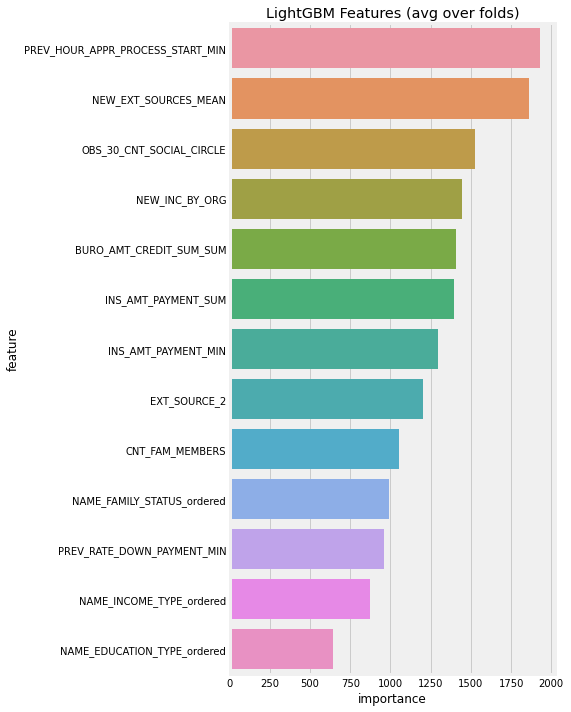

In [227]:
o_submission, o_feature_importances, o_metrics = model(data_df, test_tf)
display_importances(o_feature_importances)

In [228]:
o_metrics

fold     train     valid
0        0  0.986143  0.733743
1        1  0.986834  0.733833
2        2  0.982810  0.954383
3        3  0.886770  1.000000
4        4  0.885785  1.000000
5  overall  0.945669  0.970112

In [230]:
data = train_imbalanced[feat_common_stepbkwd_rfe]

In [231]:
data = setup(data = data, target = 'TARGET', session_id=123)

In [232]:
lgm = create_model('lightgbm')

In [233]:
evaluate_model(lgm)

NameError: name 'lgbm' is not defined

# MODEL CREATION USING PYCARET &  COMMON FEATURES FROM  STEP BACKWARD AND STEP FORWARD

In [234]:
data = train_imbalanced[feat_common_stepbkwd_stepfwd]

In [235]:
data = setup(data = data, target = 'TARGET', session_id=123)

In [236]:
best_model4 = compare_models()

In [ ]:
feat_common_stepbkwd_stepfwd

### Tuning Models

Compare model just evaluates using the default hyperparameters, tune model will use cross validation to tune the models, here we will tune top 3 models selected in compare models.

In [ ]:
tune_model(best_model[0])


In [ ]:
tune_model(best_model[1])


In [ ]:
tune_model(best_model[2])


### Dimensionality Reduction using PCA

In [81]:
features = train_imbalanced

In [82]:
# features = train_wo_imbalance

In [83]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17982 entries, 0 to 17981
Columns: 178 entries, index to TARGET
dtypes: float64(30), int64(19), uint8(129)
memory usage: 8.9 MB


In [84]:
X = features
y = features['TARGET']


In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [86]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_


In [87]:
explained_variance

array([0.94569089, 0.03947777])